<a href="https://colab.research.google.com/github/banno-0720/Deep-Learning-Projects/blob/main/Trashify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Overview

Trashify = using ML to incentivize people to pick up trash in their local area

We'll start with a collection of images with bounding box files as our dataset, fine-tune an existing computer vision model to detect items in an image and then share our model as a demo others can use.

TK image - update cover image for object detection
<!-- <figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/00-project-food-not-food-overview.png"
     alt="Project overview image for 'Food Not Food' classification at Nutrify, a food app. The project involves building and deploying a binary text classification model to identify food-related text using Hugging Face Datasets, Transformers, and deploying with Hugging Face Hub/Spaces and Gradio. Examples include labels for 'A photo of sushi rolls on a white plate' (food), 'A serving of chicken curry in a blue bowl' (food), and 'A yellow tractor driving over a grassy hill' (not food). The process is visually depicted from data collection to model training and demo deployment."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>We're going to put on our internship hats and build a food not food text classification model using tools from the Hugging Face ecosystem.</figcaption>
</figure>

## 1.1 What we're going to build

We're going to be bulding Trashify 🚮, an **object detection model** which incentivises people to pick up trash in their local area by detecting `bin`, `trash`, `hand`.

If all three items are detected, a person gets +1 point!

For example, say you were going for a walk around your neighbourhood and took a photo of yourself picking up a piece (with your **hand** or **trash arm**) of **trash** and putting it in the **bin**, you would get a point.

With this object detection model, you could deploy it to an application which would automatically detect the target classes and then save the result to an online leaderboard.

The incentive would be to score the most points, in turn, picking up the most piecces of trash, in a given area.

More specifically, we're going to follow the following steps:

1. **[Data](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images): Problem defintion and dataset preparation** - Getting a dataset/setting up the problem space.
2. **[Model](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr): Finding, training and evaluating a model** - Finding an object detection model suitable for our problem on Hugging Face and customizing it to our own dataset.
3. **[Demo](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3): Creating a demo and put our model into the real world** - Sharing our trained model in a way others can access and use.

By the end of this project, you'll have a trained model and [demo on Hugging Face](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3) you can share with others:

In [1]:
from IPython.display import HTML

HTML("""
<iframe
	src="https://mrdbourke-trashify-demo-v3.hf.space"
	frameborder="0"
	width="850"
	height="850"
></iframe>
""")

## 1.2 What is object detection?

Object detection is the process of identifying and locating an item in an image.

Where *item* can mean almost anything.

For example:

* Detecting car **licence plates** in a video feed (videos are a series of images) for a parking lot entrance.
* Detecting **delivery people** walking towards your front door on a security camera.
* Detecting **defects** on a manufacturing line.
* Detecting [**pot holes** in the road](https://ieeexplore.ieee.org/abstract/document/9968423) so repair works can automatically be scheduled.
* Detecting **small pests (Varroa Mite)** on the bodies of bees.
* Detecting [**weeds** in a field](https://ai.meta.com/blog/pytorch-drives-next-gen-intelligent-farming-machines/) so you know what to remove and what to keep.

--

Examples of actual trash identification projects, see:

- Google using machine learning for trash identification — [https://sustainability.google/operating-sustainably/stories/circular-economy-marketplace/](https://sustainability.google/operating-sustainably/stories/circular-economy-marketplace/)
- Trashify website for identifying trash — [https://www.trashify.tech/](https://www.trashify.tech/)
- Waste management with deep learning — [https://www.sciencedirect.com/science/article/abs/pii/S0956053X23001915](https://www.sciencedirect.com/science/article/abs/pii/S0956053X23001915)
- Label Studio being used for labelling a trash dataset — [https://labelstud.io/blog/ameru-labeling-for-a-greener-world/](https://labelstud.io/blog/ameru-labeling-for-a-greener-world/)

**Image classification** deals with classifying an image as a whole into a single `class`, object detection endeavours to find the specific target item and *where* it is in an image.

One of the most common ways of showing where an item is in an image is by displaying a **bounding box** (a rectangle-like box around the target item).

An object detection model will often take an input image tensor in the shape `[3, 640, 640]` (`[colour_channels, height, width]`) and output a tensor in the form `[class_name, x_min, y_min, x_max, y_max]` or `[class_name, x1, y1, x2, y2]` (this is two ways to write the same example format, there are more formats, we'll see these below in @tbl-bbox-formats).

Where:

* `class_name` = The classification of the target item (e.g. `"car"`, `"person"`, `"banana"`, `"piece_of_trash"`, this could be almost anything).
* `x_min` = The `x` value of the top left corner of the box.
* `y_min` = The `y` value of the top left corner of the box.
* `x_max` = The `x` value of the bottom right corner of the box.
* `y_max` = The `y` value of the bottom right corner of the box.

## 1.3 Why train your own object detection models?

You can customize **pre-trained models** for object detection as well as API-powered models and LLMs such as [Gemini](https://ai.google.dev/gemini-api/docs/vision?lang=python#bbox), [LandingAI](https://landing.ai/agentic-object-detection) and [DINO-X](https://github.com/IDEA-Research/DINO-X-API).

Depending on your requirements, there are several pros and cons for using your own model versus using an API.

Training/fine-tuning your own model:

| Pros | Cons |
| :----- | :----- |
| **Control:** Full control over model lifecycle. | Can be complex to get setup. |
| No usage limits (aside from compute constraints). | Requires dedicated compute resources for training/inference. |
| Can train once and deploy everywhere/whenever you want (for example, Tesla deploying a model to all self-driving cars). | Requires maintenance over time to ensure performance remains up to par. |
| **Privacy:** Data can be kept in-house/app and doesn’t need to go to a third party. | Can require longer development cycles compared to using existing APIs. |
| **Speed:** Customizing a small model for a specific use case often means it runs much faster on local hardware, for example, modern object detection models can achieve 70-100+ FPS (frames per second) on modern GPU hardware. | |

Using a pre-built model API:

| Pros | Cons |
| :----- | :----- |
| **Ease of use:** often can be setup within a few lines of code. | If the model API goes down, your service goes down. |
| No maintenance of compute resources. | Data is required to be sent to a third-party for processing. |
| Access to the most advanced models. | The API may have usage limits per day/time period. |
| Can scale if usage increases. | Can be much slower than using dedicated models due to requiring an API call. |

For this project, we're going to focus on fine-tuning our own model.

## 1.4 Workflow we're going to follow

Start with data (or skip this step and go straight to a model) -> get/customize a model -> build and share a demo.

With this in mind, our motto is *data, model, demo!*

More specifically, we're going to follow the rough workflow of:

1. Create, preprocess and load data using [Hugging Face Datasets](https://huggingface.co/docs/datasets/index).
2. Define the model we'd like use with [`transformers.AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

I say rough because machine learning projects are often non-linear in nature.

As in, because machine learning projects involve many experiments, they can kind of be all over the place.

But this worfklow will give us some good guidelines to follow.

<figure style="text-align: center; display: inline-block;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/01-hugging-face-workflow.png"
     alt="The diagram shows the Hugging Face model development workflow, which includes the following steps: start with an idea or problem, get data ready (turn into tensors/create data splits), pick a pretrained model (to suit your problem), train/fine-tune the model on your custom data, evaluate the model, improve through experimentation, save and upload the fine-tuned model to the Hugging Face Hub, and turn your model into a shareable demo. Tools used in this workflow are Datasets/Tokenizers, Transformers/PEFT/Accelerate/timm, Hub/Spaces/Gradio, and Evaluate."
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption style="width: 100%; box-sizing: border-box;">A general Hugging Face workflow from idea to shared model and demo using tools from the Hugging Face ecosystem. You'll notice some of the steps don't match with our workflow outline above. This is because the text-based workflow outline above breaks some of the steps down for educational purposes. These kind of workflows are not set in stone and are more of guide than specific directions. See information on each of the tools in the <a href="https://huggingface.co">Hugging Face documentation</a>.</figcaption>
</figure>

# 2. Importing necessary libraries

If you're running on your local computer, be sure to check out the getting [setup guide](https://www.learnhuggingface.com/extras/setup) to make sure you have everything you need.

If you're using Google Colab, many of them the following libraries will be installed by default.

However, we'll have to install a few extras to get everything working.

We'll need to install the following libraries from the Hugging Face ecosystem:

* [`transformers`](https://huggingface.co/docs/transformers/en/installation) - comes pre-installed on Google Colab but if you're running on your local machine, you can install it via `pip install transformers`.
* [`datasets`](https://huggingface.co/docs/datasets/installation) - a library for accessing and manipulating datasets on and off the Hugging Face Hub, you can install it via `pip install datasets`.
* [`evaluate`](https://huggingface.co/docs/evaluate/installation) - a library for evaluating machine learning model performance with various metrics, you can install it via `pip install evaluate`.
* [`accelerate`](https://huggingface.co/docs/accelerate/basic_tutorials/install) - a library for training machine learning models faster, you can install it via `pip install accelerate`.
* [`gradio`](https://www.gradio.app/guides/quickstart#installation) - a library for creating interactive demos of machine learning models, you can install it via `pip install gradio`.

And the following library is not part of the Hugging Face ecosystem but it is helpful for evaluating our models:

* [`torchmetrics`](https://lightning.ai/docs/torchmetrics/stable/) - a library containing many evaluation metrics compatible with PyTorch/Transformers, you can install it via `pip install torchmetrics`.

We can also check the versions of our software with `package_name.__version__`.

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
# Install/import dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import random

import numpy as np

import torch
import transformers

# Required for evaluation
# Can install with !pip install torchmetrics[detection]
import torchmetrics
import pycocotools

# Check versions (as long as you've got the following versions or higher, you should be good)
print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using torchmetrics version: {torchmetrics.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 3. Getting a dataset

Okay, now we're got the required libraries, let's get a dataset.

The dataset you often determines the type of model you use as well as the quality of the outputs of that model.

Meaning, if you have a high quality dataset, chances are, your future model could also have high quality outputs.

It also means if your dataset is of poor quality, your model will likely also have poor quality outputs.

For an object detection problem, your dataset will likely come in the form of a group of images as well as a file with annotations belonging to those images.

For example, you might have the following setup:

```
folder_of_images/
    image_1.jpeg
    image_2.jpeg
    image_3.jpeg
annotations.json
```

Where the `annotations.json` contains details about the contains of each image:

```{.json filename="annotations.json"}
[
    {
        'image_path': 'image_1.jpeg',
        'image_id': 42,
        'annotations':
            {
                'file_name': ['image_1.jpeg'],
                'image_id': [42],
                'category_id': [1],
                'bbox': [
                            [360.20001220703125, 528.5, 177.1999969482422, 261.79998779296875],
                        ],
                'area': [46390.9609375]
            },
        'label_source': 'manual_prodigy_label',
        'image_source': 'manual_taken_photo'
    },

    ...(more labels down here)
]
```

Don't worry too much about the exact meaning of everything in the above `annotations.json` file for now (this is only one example, there are many different ways object detection information could be displayed).

The main point is that each target image is paired with an assosciated label.

Now like all good machine learning cooking shows, I've prepared a dataset from earlier.

TK image - dataset on Hugging Face

It's stored on Hugging Face Datasets (also called the Hugging Face Hub) under the name [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

This is a dataset I've collected manually by hand (yes, by picking up 1000+ pieces of trash and photographing it) as well as labelled by hand (by drawing boxes on each image with a labelling tool called [Prodigy](https://prodi.gy/features/computer-vision)).


## 3.1 Loading the dataset

To load a dataset stored on the Hugging Face Hub we can use the [`datasets.load_dataset(path=NAME_OR_PATH_OF_DATASET)`](https://huggingface.co/docs/datasets/en/package_reference/loading_methods#datasets.load_dataset) function and pass it the name/path of the dataset we want to load.

In our case, our dataset name is `mrdbourke/trashify_manual_labelled_images` (you can also change this for your own dataset).

And since our dataset is hosted on Hugging Face, when we run the following code for the first time, it will download it.

If your target dataset is quite large, this download may take a while.

However, once the dataset is downloaded, subsequent reloads will be mush faster.

Let's load our dataset and check it out.

In [4]:
from datasets import load_dataset

# Load our Trashify dataset
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")

dataset

README.md:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

In [5]:
print(f"[INFO] Length of original dataset: {len(dataset['train'])}")
print(f"[INFO] Dataset features:")

from pprint import pprint

pprint(dataset['train'].features)

[INFO] Length of original dataset: 1128
[INFO] Dataset features:
{'annotations': Sequence(feature={'area': Value(dtype='float32', id=None),
                                  'bbox': Sequence(feature=Value(dtype='float32',
                                                                 id=None),
                                                   length=4,
                                                   id=None),
                                  'category_id': ClassLabel(names=['bin',
                                                                   'hand',
                                                                   'not_bin',
                                                                   'not_hand',
                                                                   'not_trash',
                                                                   'trash',
                                                                   'trash_arm'],
                                      

## 3.2 Viewing a single sample from our data

Let's check out a single sample from our dataset.

We can index on a single sample of the `"train"` set just like indexing on a Python list.

In [6]:
# View a single sample of the dataset
dataset["train"][42]

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 745,
 'annotations': {'file_name': ['094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg'],
  'image_id': [745, 745, 745],
  'category_id': [5, 1, 0],
  'bbox': [[333.1000061035156,
    611.2000122070312,
    244.89999389648438,
    321.29998779296875],
   [504.0, 612.9000244140625, 451.29998779296875, 650.7999877929688],
   [202.8000030517578,
    366.20001220703125,
    532.9000244140625,
    555.4000244140625]],
  'iscrowd': [0, 0, 0],
  'area': [78686.3671875, 293706.03125, 295972.65625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

We see a few more details here compared to just looking at the features.

We notice the `image` is a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) with size `960x1280` (width x height).

And the `file_name` is a UUID (Universially Unique Identifier, made with [`uuid.uuid4()`](https://docs.python.org/3/library/uuid.html#uuid.uuid4)).

The `bbox` field in the `annotations` key contains a list of bounding boxes assosciated with the image.

In this case, there are 3 different bounding boxes.

With the `category_id` values of `5`, `1`, `0` (we'll map these to class names shortly).

Let's inspect a single bounding box.

In [7]:
dataset["train"][42]["annotations"]["bbox"][0]

[333.1000061035156, 611.2000122070312, 244.89999389648438, 321.29998779296875]

This array gives us the coordinates of a single bounding box in the format `XYWH`.

Where:

* `X` is the x-coordinate of the top left corner of the box (`333.1`).
* `Y` is the y-coordinate of the top left corner of the box (`611.2`).
* `W` is the width of the box (`244.9`).
* `H` is the height of the box (`321.3`).

All of these values are in absolute pixel values (meaning an x-coordinate of `333.1` is `333.1` pixels across on the x-axis).

## 3.3 Extracting the category names from our data

Before we start to visualize our sample image and bounding boxes, let's extract the category names from our dataset.

We can do so by accessing the `features` attribute our of `dataset` and then following it through to find the `category_id` feature, this contains a list of our text-based class names.

Let's access the class names in our dataset and save them to a variable `categories`.


In [8]:
# Get the categories from the dataset
# Note: This requires the dataset to have been uploaded with this information setup, not all datasets will have this available.
categories = dataset["train"].features["annotations"].feature["category_id"]

# Get the names attribute
categories.names

['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']

We get the following class names:

* `bin` - A rubbish bin or trash can.
* `hand` - A person's hand.
* `not_bin` - Negative version of `bin` for items that look like a `bin` but shouldn't be identified as one.
* `not_hand` - Negative version of `hand` for items that look like a `hand` but shouldn't be identified as one.
* `not_trash` - Negative version of `trash` for items that look like `trash` but shouldn't be identified as it.
* `trash` - An item of trash you might find on a walk such as an old plastic bottle, food wrapper, cigarette butt or used coffee cup.
* `trash_arm` - A mechanical arm used for picking up trash.

The goal of our computer vision model will be: given an image, detect items belonging to these target classes if they are present.

## 3.4 Creating a mapping from numbers to labels

Now we've got our text-based class names, let's create a mapping from label to ID and ID to label.

For each of these, Hugging Face use the terminology `label2id` and `id2label` respectively.

In [9]:
# Map ID's to class names and vice versa
id2label = {i: class_name for i, class_name in enumerate(categories.names)}
label2id = {value: key for key, value in id2label.items()}

print(f"Label to ID mapping:\n{label2id}\n")
print(f"ID to label mapping:\n{id2label}")
# id2label, label2id

Label to ID mapping:
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}

ID to label mapping:
{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}


## 3.5 Creating a colour palette

Ok we know which class name matches to which ID, now let's create a dictionary of different colours we can use to display our bounding boxes.

It's one thing to plot bounding boxes, it's another thing to make them look nice.

And we always want our plots looking nice!

We'll colour the positive classes `bin`, `hand`, `trash`, `trash_arm` in nice bright colours.

And the negative classes `not_bin`, `not_hand`, `not_trash` in a light red colour to indicate they're the negative versions.

Our colour dictionary will map `class_name` -> `(red, green, blue)`  (or [RGB](https://en.wikipedia.org/wiki/RGB_color_model)) colour values.

In [10]:
# Make colour dictionary
colour_palette = {
    'bin': (0, 0, 224),         # Bright Blue (High contrast with greenery) in format (red, green, blue)
    'not_bin': (255, 80, 80),   # Light Red to indicate negative class

    'hand': (148, 0, 211),      # Dark Purple (Contrasts well with skin tones)
    'not_hand': (255, 80, 80),  # Light Red to indicate negative class

    'trash': (0, 255, 0),       # Bright Green (For trash-related items)
    'not_trash': (255, 80, 80), # Light Red to indicate negative class

    'trash_arm': (255, 140, 0), # Deep Orange (Highly visible)
}

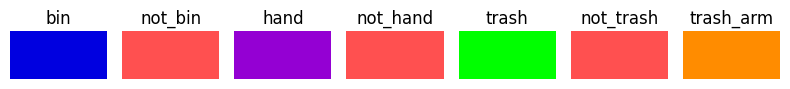

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize RGB values to 0-1 range
def normalize_rgb(rgb_tuple):
    return tuple(x/255 for x in rgb_tuple)

# Turn colors into normalized RGB values for matplotlib
colors_and_labels_rgb = [(key, normalize_rgb(value)) for key, value in colour_palette.items()]

# Create figure and axis
fig, ax = plt.subplots(1, 7, figsize=(8, 1))

# Flatten the axis array for easier iteration
ax = ax.flatten()

# Plot each color square
for idx, (label, color) in enumerate(colors_and_labels_rgb):
    ax[idx].add_patch(plt.Rectangle(xy=(0, 0),
                                    width=1,
                                    height=1,
                                    facecolor=color))
    ax[idx].set_title(label)
    ax[idx].set_xlim(0, 1)
    ax[idx].set_ylim(0, 1)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

# 4. Plotting a single image and visualizing the boxes

Let's take a random sample from our `dataset` and plot the image as well as the box on it.

To save some space in our notebook (plotting many images can increase the size of our notebook dramatically), we'll create two small helper functions:

1. `half_image` - Halves the size of a given image.
2. `half_boxes` - Divides the input coordinates of a given input box by 2.

These functions aren't 100% necessary in our workflow.

They're just to make the images slightly smaller so they fit better in the notebook.

In [12]:
import PIL

def half_image(image: PIL.Image) -> PIL.Image:
    """
    Resizes a given input image by half and returns the smaller version.
    """
    return image.resize(size=(image.size[0] // 2, image.size[1] // 2))

def half_boxes(boxes):
    """
    Halves an array/tensor of input boxes and returns them. Necessary for plotting them on a half-sized image.

    For example:

    boxes = [100, 100, 100, 100]
    half_boxes = half_boxes(boxes)
    print(half_boxes)

    >>> [50, 50, 50, 50]
    """
    if isinstance(boxes, list):
        # If boxes are list of lists, then we have multiple boxes
        for box in boxes:
            if isinstance(box, list):
                return [[coordinate // 2 for coordinate in box] for box in boxes]
            else:
                return [coordinate // 2 for coordinate in boxes]

    if isinstance(boxes, np.ndarray):
        return (boxes // 2)

    if isinstance(boxes, torch.Tensor):
        return (boxes // 2)

# Test the functions
image_test = dataset["train"][42]["image"]
image_test_half = half_image(image_test)
print(f"[INFO] Original image size: {image_test.size} | Half image size: {image_test_half.size}")

boxes_test_list = [100, 100, 100, 100]
print(f"[INFO] Original boxes: {boxes_test_list} | Half boxes: {half_boxes(boxes_test_list)}")

boxes_test_torch = torch.tensor([100.0, 100.0, 100.0, 100.0])
print(f"[INFO] Original boxes: {boxes_test_torch} | Half boxes: {half_boxes(boxes_test_torch)}")

[INFO] Original image size: (960, 1280) | Half image size: (480, 640)
[INFO] Original boxes: [100, 100, 100, 100] | Half boxes: [50, 50, 50, 50]
[INFO] Original boxes: tensor([100., 100., 100., 100.]) | Half boxes: tensor([50., 50., 50., 50.])


To plot an image and its assosciated boxes, we'll do the following steps:

1. Select a random sample from the `dataset`.
2. Extract the `"image"` (our image is in `PIL` format) and `"bbox"` keys from the random sample.
    * We can also *optionally* halve the size of our image/boxes to save space. In our case, we will halve our image and boxes.
3. Turn the box coordinates into a `torch.tensor` (we'll be using `torchvision` utilities to plot the image and boxes).
4. Convert the box format from `XYXY` to `XYWH` using [`torchvision.ops.box_convert`](https://pytorch.org/vision/main/generated/torchvision.ops.box_convert.html) (we do this because `torchvision.utils.draw_bounding_boxes` requires `XYXY` format as input).
5. Get a list of label names (e.g. `"bin", "trash"`, etc) assosciated with each of the boxes as well as a list of colours to match (these will be from our `colour_palette`).
6. Draw the boxes on the target image by:
    * Turning the image into a tensor with [`torchvision.transforms.functional.pil_to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.pil_to_tensor.html).
    * Draw the bounding boxes on our image tensor with [`torchvision.utils.draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html).
    * Turn the image and bounding box tensors back into a `PIL` image with [`torchvision.transforms.functional.pil_to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.pil_to_tensor.html).

[INFO] Showing training sample from index: 265
Boxes in XYWH format: tensor([[133., 166., 223., 270.],
        [180., 290., 121., 115.],
        [ 32., 354., 219., 276.]])
Boxes XYXY: tensor([[133., 166., 356., 436.],
        [180., 290., 301., 405.],
        [ 32., 354., 251., 630.]])
Label names: ['bin', 'trash', 'hand']
Colour names: [(0, 0, 224), (0, 255, 0), (148, 0, 211)]


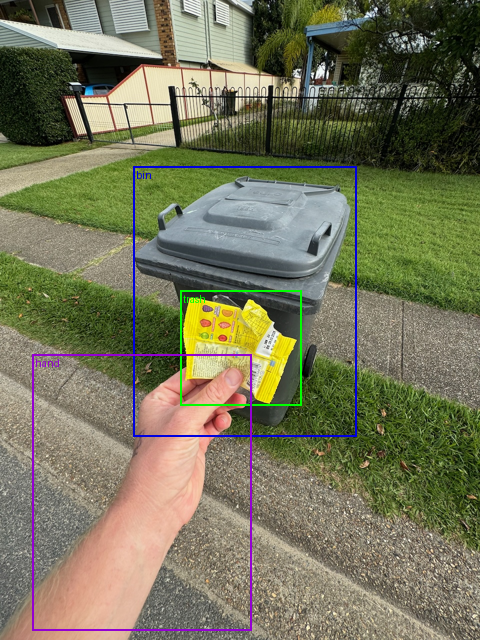

In [13]:
# Plotting a bounding box on a single image
import random

import torch

from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes

from torchvision.transforms.functional import pil_to_tensor, to_pil_image

# 1. Select a random sample from our dataset
random_index = random.randint(0, len(dataset["train"]))
print(f"[INFO] Showing training sample from index: {random_index}")
random_sample = dataset["train"][random_index]

# 2. Get image and boxes from random sample
random_sample_image = random_sample["image"]
random_sample_boxes = random_sample["annotations"]["bbox"]

# Optional: Half the image and boxes for space saving (all of the following code will work with/without half size images)
half_random_sample_image = half_image(random_sample_image)
half_random_sample_boxes = half_boxes(random_sample_boxes)

# 3. Turn box coordinates in a tensor
boxes_xywh = torch.tensor(half_random_sample_boxes)
print(f"Boxes in XYWH format: {boxes_xywh}")

# 4. Convert boxes from XYWH -> XYXY
# torchvision.utils.draw_bounding_boxes requires input boxes in XYXY format (X_min, y_min, X_max, y_max)
boxes_xyxy = box_convert(boxes=boxes_xywh,
                         in_fmt="xywh",
                         out_fmt="xyxy")
print(f"Boxes XYXY: {boxes_xyxy}")

# 5. Get label names of target boxes and colours to match
random_sample_label_names = [categories.int2str(x) for x in random_sample["annotations"]["category_id"]]
random_sample_colours = [colour_palette[label_name] for label_name in random_sample_label_names]
print(f"Label names: {random_sample_label_names}")
print(f"Colour names: {random_sample_colours}")

# 6. Draw the boxes on the image as a tensor and then turn it into a PIL image
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_random_sample_image),
        boxes=boxes_xyxy,
        colors=random_sample_colours,
        labels=random_sample_label_names,
        width=2,
        label_colors=random_sample_colours
    )
)

# 5. Different bounding box formats

When drawing our bounding box, we discussed the terms `XYXY` and `XYWH`.

One of the most confusing things in the world of object detection is the different formats bounding boxes come in.

Are your boxes in `XYXY`, `XYWH` or `CXCYWH`?

Are they in absolute format?

Or normalized format?

The following table contains a non-exhaustive list of some of the most common bounding box formats you'll come across in the wild.

| **Box format** | **Description** | **Absolute Example** | **Normalized Example** | **Source** |
| ----- | ----- | ----- | ----- | ----- |
| XYXY | Describes the top left corner coordinates `(x1, y1)` as well as the bottom right corner coordinates of a box. <br> Also referred to as: <br> `[x1, y1, x2, y2]`  <br> or <br> `[x_min, y_min, x_max, y_max]` | `[8.9, 275.3, 867.5, 964.0]` | `[0.009, 0.215, 0.904, 0.753]` | [PASCAL VOC Dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#SECTION00053000000000000000) uses the absolute version of this format, [`torchvision.utils.draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html#draw-bounding-boxes) defaults to the absolute version of this format. |
| XYWH | Describes the top left corner coordinates `(x1, y1)` as well as the width (`box_width`) and height (`box_height`) of the target box. The bottom right corners `(x2, y2)` are found by adding the width and height to the top left corner coordinates `(x1 + box_width, y1 + box_height)`. <br> Also referred to as: <br> `[x1, y1, box_width, box_height]` <br> or <br> `[x_min, y_min, box_width, box_height]` | `[8.9, 275.3, 858.6, 688.7]` | `[0.009, 0.215, 0.894, 0.538]` | The [COCO (Common Objects in Context) dataset](https://cocodataset.org/#format-data) uses the absolute version of this format, see the section under "bbox". |
| CXCYWH | Describes the center coordinates of the bounding box `(center_x, center_y)` as well as the width (`box_width`) and height (`box_height`) of the target box. <br> Also referred to as: <br> `[center_x, center_y, box_width, box_height]` | `[438.2, 619.65, 858.6, 688.7]` | `[0.456, 0.484, 0.894, 0.538]` | Normalized version introduced in the [YOLOv3 (You Only Look Once) paper](https://arxiv.org/abs/1804.02767) and is used by many later forms of YOLO. |

: Different bounding box formats {#tbl-bbox-formats}

## 5.1 Absolute or normalized format?

In **absolute** coordinate form, bounding box values are in the same format as the width and height dimensions (e.g. our image is `960x1280` pixels).

For example in `XYXY` format: `["bin", 8.9, 275.3, 867.5, 964.0]`

An `(x1, y1)` (or `(x_min, y_min)`) coordinate of `(8.9, 275.3)` means the top left corner is `8.9` pixels in on the x-axis, and `275.3` pixels down on the y-axis.

In **normalized** coordinate form, values are between `[0, 1]` and are proportions of the image width and height.

For example in `XYXY` format: `["bin", 0.009, 0.215, 0.904, 0.753]`

A normalized `(x1, y1)` (or `(x_min, y_min)`) coordinate of `(0.009, 0.215)` means the top left corner is `0.009 * image_width` pixels in on the x-axis and `0.215 * image_height` down on the y-axis.

To convert absolute coordinates to normalized, you can divide x-axis values by the image width and y-axis values by the image height.

$$
x_{\text{normalized}} = \frac{x_{\text{absolute}}}{\text{image\_width}} \quad y_{\text{normalized}} = \frac{y_{\text{absolute}}}{\text{image\_height}}
$$

## 5.2 Which bounding box format should you use?

The bounding box format you use will depend on the framework, model and existing data you're trying to use.

For example, the take the following frameworks:

* **PyTorch** - If you're using PyTorch pre-trained models, for example, [`torchvision.models.detection.fasterrcnn_resnet50_fpn`](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn), you'll want **absolute** `XYXY` (`[x1, y1, x2, y2]`) format.
* **Hugging Face Transformers** - If you're using a Hugging Face Transformers model such as [Conditional DETR](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr), you'll want to take note that [outputs from the model can be of one type](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward) (e.g. `CXCYWH`) but they can be [post-processed into another type](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrFeatureExtractor.post_process_object_detection) (e.g. **absolute** `XYXY`).
* **Ultralytics YOLO** - If you're using a YOLO-like model such as [Ultralytics YOLO](https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format), you'll want **normalized** `CXCYWH` (`[center_x, center_y, width, height]`) format.
* **Google Gemini** - If you're using [Google Gemini to predict bounding boxes on your images](https://ai.google.dev/gemini-api/docs/vision?lang=python#bbox), then you'll want to pay attention to the special `[y_min, x_min, y_max, x_max]` (`YXYX`) normalized coordinates.

Or if you note that someone has said their model is pre-trained on the COCO dataset, chances are the data has been formatted in `XYWH` format (see @tbl-bbox-formats).

# 6. Getting an object detection model

There are two main ways of getting an object detection model:

1. **Building it yourself.** For example, constructing it layer by layer, testing it and training it on your target problem.
2. **Using an existing one.** For example, find an existing model on a problem space similar to your own and then adapt it via **transfer learning** (TK - add link to glossary) to your own task.

In our case, we're going to focus on the latter.

We'll be taking a pre-trained object detection model and fine-tuning it on our Trashify 🚮 dataset so it outputs the boxes and labels we're after.

## 6.1 Places to get object detection models

Instead of building your own machine learning model from scratch, it's common practice to take an existing model that works on similar problem space to yours and then **fine-tune** it to your own use case.

There are several places to get object detection models:

| **Location** | **Description** |
| ----- | ----- |
| [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=object-detection&sort=trending) | One the best places on the internet to find open-source machine learning models of nearly any kind. You can find pre-trained object detection models here such as [`facebook/detr-resnet-50`](https://huggingface.co/facebook/detr-resnet-50), a model from Facebook (Meta) and [`microsoft/conditional-detr-resnet-50`](https://huggingface.co/microsoft/conditional-detr-resnet-50), a model from Microsoft and the model we're going to use as our base model. Many of the models are permissively licensed, meaning you can use them for your own projects.  |
| [`torchvision`](https://pytorch.org/vision/stable/models.html) | PyTorch's built-in domain library for computer vision has several [pre-trained object detection models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) which you can use in your own workflows. |
| [paperswithcode.com/task/object-detection](https://paperswithcode.com/task/object-detection) | Whilst not a direct place to download object detection models from, paperswithcode contains benchmarks for many machine learning tasks (including object detection) which shows the current state of the art (best performing) models and usually includes links to where to get the code. |
| [Detectron2](https://github.com/facebookresearch/detectron2) | Detectron2 is an open-source library to help with many of the tasks in detecting items in images. Inside you'll find several pre-trained and adaptable models as well as utilities such as data loaders for object detection and segmentation tasks. |
| YOLO Series | A running series of ["You Only Look Once" models](https://arxiv.org/abs/1506.02640). Usually, the higher the number, the better performing. For example, [`YOLOv11`](https://github.com/ultralytics/ultralytics) by Ultralytics should outperform [`YOLOv10`](https://github.com/THU-MIG/yolov10), however, this often requires testing on your own dataset. Beware of the license, it is under the [AGPL-3.0 license](https://en.wikipedia.org/wiki/GNU_Affero_General_Public_License) which may cause issues in some organizations. |
| [`mmdetection` library](https://github.com/open-mmlab/mmdetection) | An open-source library from the OpenMMLab which contains many different open-source models as well as detection-specific utilties. |

: Places to get pre-trained object detection models {#tbl-detection-models}

When you find a pre-trained object detection model, you'll often see statements such as:

> *Conditional DEtection TRansformer (DETR) model trained end-to-end on COCO 2017 object detection (118k annotated images).*
>
> Source: [https://huggingface.co/microsoft/conditional-detr-resnet-50](https://huggingface.co/microsoft/conditional-detr-resnet-50)

This means the model has already been trained on the [COCO object detection dataset](https://cocodataset.org/#home) which contains 118,000 images and [80 classes](https://cocodataset.org/#explore) such as `["cake", "person", "skateboard"...]`.

This is a good thing.

It means that the model should have a fairly good starting point when we try to adapt it to our own project.

## 6.2 Downloading our model from Hugging Face

For our Trashify 🚮 project we're going to be using the pre-trained object detection model [`microsoft/conditional-detr-resnet-50`](https://huggingface.co/microsoft/conditional-detr-resnet-50) which was originally introduced in the paper [*Conditional DETR for Fast Training Convergence*](https://arxiv.org/abs/2108.06152).

To use this model, there are some helpful documentation resources we should be aware of:

| **Resource** | **Description** |
|:----- |:----- |
| [Conditional DETR documentation](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#conditional-detr) | Contains detailed information on each of the `transformers.ConditionalDetr` classes. |
| [`transformers.ConditionalDetrConfig`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrConfig) | Contains the configuration settings for our model such as number of layers and other hyperparameters. |
| [`transformers.ConditionalDetrImageProcessor`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor) | Contains several preprocessing on post processing functions and settings for data going into and out of our model. Here we can set values such as `size` in the [`preprocess`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess) method which will resize our images to a certain size. We can also use the [`post_process_object_detection`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.post_process_object_detection) method to process the raw outputs of our model into a more usable format. |
| [`transformers.ConditionalDetrModelForObjectdetection`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection) | This will enable us to load the Conditional DETR model weights and enable to pass data through them via the [`forward`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward) method. |
| [`transformers.AutoImageProcessor`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoImageProcessor) | This will enable us to create an instance of `transformers.ConditionalDetrImageProcessor` by passing the model name `microsoft/conditional-detr-resnet-50` to the `from_pretrained` method. Hugging Face Transformers uses several [Auto Classes](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) for various problem spaces and models. |
| [`transformers.AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) | Enables us to load the model architecture and weights for the Conditional DETR architecture by passing the model name `microsoft/conditional-detr-resnet-50` to the [`from_pretrained` method](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection.from_pretrained). |


We'll get hands-on which each of these throughout the project.

For now, if you'd like to read up more on each, I'd highly recommend it.

Knowing how to navigate and read through a framework's documentation is a very helpful skill to have.

We can load our model with [`transformers.AutoModelForObjectDetection.from_pretrained`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection.from_pretrained) and passing in the following parameters:

* `pretrained_model_name_or_path` - Our target model, which can be a local path or Hugging Face model name (e.g. `microsoft/conditional-detr-resnet-50`).
* `label2id` - A dictionary mapping our class names/labels to their numerical ID, this is so our model will know how many classes to output.
* `id2label` - A dictionary mapping numerical IDs to our class names/labels, so our model will know how many classes we're working with and what their IDs are.
* `ignore_mismatched_sizes=True` (default) - We'll set this to `True` so that our model can be instatiated with a varying number of classes compared to what it may have been trained on (e.g. if our model was trained on the 91 classes from COCO, we only need 7).
* `backbone="resnet50"` (default) - We'll tell our model what kind of computer vision backbone to use for extracting features from our images.

See the [full documentation](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection.from_pretrained) for a full list of parameters we can use.

The term "DETR" stands for "DEtection TRansformer".

Where "Transformer" refers to the [Transformer neural network architecture](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)), specifically the [Vision Transformer](https://en.wikipedia.org/wiki/Vision_transformer) (or ViT) rather than the Hugging Face `transformers` library (quite confusing, yes).

So DETR means "performing detection with the Transformer architecture".

And the "ResNet" part stands for "[Residual Neural Network](https://en.wikipedia.org/wiki/Residual_neural_network)" which is a common computer vision backbone. The "50" refers to the number of layers in the network. Saying "ResNet-50" means the 50 layer version of ResNet. ResNet-101 and ResNet-18 are two other larger and smaller variants.

In [14]:
from transformers import AutoModelForObjectDetection

MODEL_NAME = "microsoft/conditional-detr-resnet-50"

model = AutoModelForObjectDetection.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
    backbone="resnet50"
)

# Uncomment to see full model archietecture
model

config.json:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/174M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

ConditionalDetrForObjectDetection(
  (model): ConditionalDetrModel(
    (backbone): ConditionalDetrConvModel(
      (conv_encoder): ConditionalDetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): ConditionalDetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): ConditionalDetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): ConditionalDetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (

You might've noticed a warning about the model needing to be trained on a down-stream task:

> Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
> - class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([7]) in the model instantiated
> - class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
> You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

This is because our model has a different number of target classes (7 in total) comapred to the original model (91 in total, from the COCO dataset).

So in order to get this pretrained model to work on our dataset, we'll need to **fine-tune** it.

You might also notice that if you set `ignore_mismatched_sizes=False`, you'll get an error:

> RuntimeError: Error(s) in loading state_dict for ConditionalDetrForObjectDetection:
	size mismatch for class_labels_classifier.weight: copying a param with shape torch.Size([91, 256]) from checkpoint, the shape in current model is torch.Size([7, 256]).
	size mismatch for class_labels_classifier.bias: copying a param with shape torch.Size([91]) from checkpoint, the shape in current model is torch.Size([7]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

This is a similar warning to the one above.

Keep this is mind for when you're working with pretrained models.

If you are using data slightly different to what the model was trained on, you may need to alter the setup hyperparameters as well as fine-tune it on your own data.

## 6.3 Inspecting our model's layers

The following subset of layers has been truncated for brevity.

```python
# Shortened version of the model architecture, print the full model to see all layers
ConditionalDetrForObjectDetection(
  (model): ConditionalDetrModel(
    (backbone): ConditionalDetrConvModel(
      (conv_encoder): ConditionalDetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): ConditionalDetrFrozenBatchNorm2d()
              ...
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): ConditionalDetrFrozenBatchNorm2d())))
            ...
      (position_embedding): ConditionalDetrSinePositionEmbedding()
    )
    (input_projection): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (query_position_embeddings): Embedding(300, 256)
    (encoder): ConditionalDetrEncoder(
      (layers): ModuleList(
        (0-5): 6 x ConditionalDetrEncoderLayer(
          (self_attn): DetrAttention(
              ...
          )
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True))))
    (decoder): ConditionalDetrDecoder(
      (layers): ModuleList(
        (0): ConditionalDetrDecoderLayer(...)
      (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (query_scale): MLP(
        (layers): ModuleList(
          (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)))
      (ref_point_head): MLP(
        ...
      ))))
  (class_labels_classifier): Linear(in_features=256, out_features=7, bias=True)
  (bbox_predictor): ConditionalDetrMLPPredictionHead(
    (layers): ModuleList(
      (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=4, bias=True)))))
```

If we check out a few of our model's layers, we can see that it is a combination of [convolutional](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html), [MLP (multi-layer perceptron)](https://en.wikipedia.org/wiki/Multilayer_perceptron) and [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers.


We'll feed our input image into our model and layer by layer it will manipulate the pixel values to try and extract patterns in a way so that its internal parameters matches the image to its input annotations.

More specifically, if we dive into the final two layer sections:

1. `class_labels_classifier` = classification head with `out_features=7` (one for each of our labels, `'bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']`).
2. `bbox_predictor` = regression head with `out_features=4` (one for each of our bbox coordinates, e.g. `[center_x, center_y, width, height]`).

In [15]:
print(f"[INFO] Final classification layer: {model.class_labels_classifier}\n")
print(f"[INFO] Final box regression layer: {model.bbox_predictor}")

[INFO] Final classification layer: Linear(in_features=256, out_features=7, bias=True)

[INFO] Final box regression layer: ConditionalDetrMLPPredictionHead(
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
)


These two layers are what are going to output the final predictions of our model in structure similar to our annotations.

The `class_labels_classifier` will output the predicted class label of a given bounding box output from `bbox_predictor`.

In essence, we are trying to get all of the pretrained patterns (also called **parameters**/**weights & biases**) of the previous layers to conform to the ideal outputs we'd like at the end.

## 6.4 Counting the number of parameters in our model

**Parameters** are individual values which contribute to a model's final output.

Parameters are also referred to as weights and biases.

You can think of these individual weights as small pushes and pulls on the input data to get it to match the input annotations.

If our weights were perfect, we could input an image and always get back the correct bounding boxes and class labels.

It's very unlikely to ever have perfect weights (unless your dataset is very small) but we can make them quite good (and useful).

When you have a good set of weights, this is known as a good [**representation**](https://en.wikipedia.org/wiki/Feature_learning).

Right now, our weights have been trained on COCO, a collection of 91 different common objects.

So they have a fairly good representation of detecting general common objects, however, we'd like to **fine-tune** these weights to detect our target objects.

Importantly, our model will not be starting from scratch when it begins to train.

It will instead take off from its existing knowledge of detecting common objects in images and try to adhere to our task.

When it comes to parameters and weights, generally, more is better.

Meaning the more parameters your model has, the better representation it can learn.

For example, [ResNet50](https://huggingface.co/microsoft/resnet-50) (our computer vision backbone) has ~25 million parameters, about 100 MB in `float32` precision or 50MB in `float16` precision.

Whereas a model such as [Llama-3.1-405B](https://huggingface.co/meta-llama/Llama-3.1-405B) has ~405 billion parameters, about 1.45 TB in `float32` precision or 740 GB in `float16` precision, about 16,000x more than ResNet50.

However, as we can see having more parameters comes with the tradeoff of size and latency.

For each new parameter requires to be stored and it also adds an extra computation unit to your model.

In the case of Trashify, since we'd like our model to run on-device (e.g. make predictions live on an iPhone), we'd opt for the smallest number of parameters we could get acceptable results from.

If performance is your number 1 criteria and size and latency don't matter, then you'd likely opt for the model with the largest number of parameters (though always evaluate these models on your own data, larger models are *generally* better, not *always* better).

Since our model is built using PyTorch, let's write a small function to count the number of:  

* Trainable parameters (parameters which will be tweaked during training)
* Non-trainable parameters (parameters which will *not* be tweaked during training)
* Total parameters (trainable parameters + non-trainable parameters)

In [16]:
# Count the number of parameters in the model
def count_parameters(model):
    """Takes in a PyTorch model and returns the number of parameters."""
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_parameters = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_parameters:,}")
    print(f"Trainable parameters (will be updated): {trainable_parameters:,}")
    print(f"Non-trainable parameters (will not be updated): {non_trainable_parameters:,}")

count_parameters(model)

Total parameters: 43,396,813
Trainable parameters (will be updated): 43,174,413
Non-trainable parameters (will not be updated): 222,400


Cool!

It looks like our model has a total of `43,396,813` parameters, of which, most of them are trainable.

This means that when we fine-tune our model later on, we'll be tweaking the majority of the parameters to try and represent our data.

In practice, this is known as **full fine-tuning**, trying to fine-tune a large portion of the model to our data.

There are other methods for fine-tuning, such as **feature extraction** (where you only fine-tune the final layers of the model) and **partial fine-tuning** (where you fine-tune a portion of the model).

And even methods such as [**LoRA** (Low-Rank Adaptation)](https://huggingface.co/papers/2106.09685) which fine-tunes an adaptor matrix as a compliment to the model's parameters.

### Creating a function to build our model

Since machine learning is very experimental, we may want to create multiple instances of our `model` to test various things.

So let's functionize the creation of a new model with parameters for our target model name, `id2label` and `label2id` dictionaries.

In [17]:
from transformers import AutoModelForObjectDetection

# Setup the model
def create_model(pretrained_model_name_or_path: str = MODEL_NAME,
                 label2id: dict = label2id,
                 id2label: dict = id2label):
    """Creates and returns an instance of AutoModelForObjectDetection.

    Args:
        pretrained_model_name_or_path (str): The name or path of the pretrained model to load.
            Defaults to MODEL_NAME.
        label2id (dict): A dictionary mapping class labels to IDs. Defaults to label2id.
        id2label (dict): A dictionary mapping class IDs to labels. Defaults to id2label.

    Returns:
        AutoModelForObjectDetection: A pretrained model for object detection with number of output
            classes equivalent to len(label2id).
    """
    model = AutoModelForObjectDetection.from_pretrained(
        pretrained_model_name_or_path=MODEL_NAME,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True, # default
        backbone="resnet50", # default
    )
    return model

In [18]:
# Create a new model instance
model = create_model()
# model

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([7]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6.6 Trying to pass a single sample through our model (part 1)

Okay, now we've got a model, let's put some data through it!

When we call our `model`, because it's a PyTorch Module ([`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)) it will by default run the `forward` method.

In PyTorch, `forward` overrides the special `__call__` method on functions.

So we can pass data into our model by running:

```python
model(input_data)
```

Which is equivalent to running:

```python
model.forward(input_data)
```

To see what happens when we call our model, let's inspect the `forward` method's docstring with [`model.forward?`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrModel.forward).


In [19]:
#| output: false
# What happens when we call our model?
# Note: for PyTorch modules, `forward` overrides the __call__ method,
# so calling the model is equivalent to calling the forward method.
model.forward?

In [20]:
#| output: false
# Do a single forward pass with the model
# random_sample_outputs = model(pixel_values=random_sample["image"],
#                               pixel_mask=None)
# random_sample_outputs

Our input data might require some preprocessing before we can pass it to our model.(to fix the error)

# 7. Aside: Processor to Model Pattern

Many Hugging Face data loading and modelling workflows as well as machine learning workflows in general follow the pattern of:

* Data -> Preprocessor -> Model

Meaning, the raw input data gets preprocessed or transformed in some way before being passed to a model.

Preprocessors and models are often loaded with an [Auto Class](https://huggingface.co/docs/transformers/en/model_doc/auto).

An Auto Class pairs a preprocessor and model based on their model name or key.

For example:

```python
from transformers import AutoProcessor, AutoModel

# Load raw data
raw_data = load_data()

# Define target model name
MODEL_NAME = "..."

# Load preprocessor and model (these two are often paired)
preprocessor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Preprocess data
preprocessed_data = preprocessor.preprocess(raw_data)

# Pass preprocessed data to model
output = model(preprocessed_data)
```

This is the same for our Trashify 🚮 project.

We've got our raw data (images and bounding boxes), however, they need to be preprocessed in order for our model to be able to handle them.

Previously we tried to pass a sample of raw data to our model and this errored.

We can fix this by first preprocessing our raw data with our model's pair preprocessor and *then* passing to our model again.

# 8. Loading our model's processor

Time to get our raw data ready for our model!

To begin, let's load our model's processor.

We'll use this to prepare our input images for the model.

To do so, we'll use [`transformers.AutoImageProcessor`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoImageProcessor) and pass our target model name to the `from_pretrained` method.

In [21]:
from transformers import AutoImageProcessor

MODEL_NAME = "microsoft/conditional-detr-resnet-50"
# MODEL_NAME = "facebook/detr-resnet-50" # Could also use this model as an another experiment

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path=MODEL_NAME)

# Check out the image processor
image_processor

preprocessor_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ConditionalDetrImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConditionalDetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

Ok, a few things going on here.

These parameters will transform our input images before we pass them to our model.

One of the first things to see is the `image_processor` is expecting our bounding boxes to be in [COCO (or `coco_detection`) format](https://cocodataset.org/#format-data) (this is the default).

We'll see what this looks like later on but our processor wants this format because that's the format our model has been trained on (it's generally best practice to input data to a model in the same way its been trained on, otherwise you might get poor results).

Another thing to notice is that our input images will be resized to the values of the `size` parameter.

In our case, it's currently:

```python
"size": {
    "longest_edge": 1333,
    "shortest_edge": 800
}
```

Which means that the longest edge will have size less or equal to `1333` and the shortest edge less or equal to `800`.

For simplicity, we'll change this shortly to make both sides the same size.

You can read more about what each of these does in the [`transformers.ConditionalDetrImageProcessor` documentation](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor).

Let's update our instance of `transformers.ConditionalDetrImageProcessor` with a few custom parameters:

* `do_convert_annotations=True` - This is the default and it will convert our boxes to the format `CXCYWH` or `(center_x, center_y, width, height)` (see @tbl-bbox-formats) in the range `[0, 1]`.
* `size` - We'll update the `size` dictionary so all of our images have `"longest_edge": 640` and `"shortest_edge: 640"`. We'll use a value of `640` which is a common size in world of object detection. But there are also other sizes such as `300x300`, `480x480`, `512x512`, `800x800` and more.

::: {.callout-note}
Depending on what task you're working on, you might want to tweak the image resolution you're working with.

For example, I like this quote from [Lucas Beyer](https://lucasb.eyer.be/articles/vit_cnn_speed.html), a former research scientist at DeepMind and engineer at OpenAI:

> My conservative claim is that you can always stretch to a square, and for:
>
> natural images, meaning most photos, 224px² is enough;
> text in photos, phone screens, diagrams and charts, 448px² is enough;
> desktop screens and single-page documents, 896px² is enough.

Typically, in the case of object detection, you'll want to use a higher value.

But this is another thing that is open to experimentation.
:::

In [22]:
# Set image size
IMAGE_SIZE = 640 # we could try other sizes here: 300x300, 480x480, 512x512, 640x640, 800x800 (best to experiment and see which works best)

# Create a new instance of the image processor with the desired image size
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    format="coco_detection", # this is the default
    do_convert_annotations=True, # defaults to True, converts boxes to (center_x, center_y, width, height) in range [0, 1]
    size={"shortest_edge": IMAGE_SIZE,
          "longest_edge": IMAGE_SIZE}
)

# Optional: View the docstring of our image_processor.preprocess function
# image_processor.preprocess?

# Check out our new image processor size
image_processor.size

{'shortest_edge': 640, 'longest_edge': 640}

Beautiful!

Now our images will be resized to a square of size `640x640` when we pass them to our model.

How about we try to preprocess our `random_sample`?

To do so, we can pass its `"image"` key and `"annotations"` key to our `image_processor`'s [`preprocess`](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess) method.

Let's try!

In [23]:
# Try to process a single image and annotation pair (spoiler: this will error)
# random_sample_preprocessed = image_processor.preprocess(images=random_sample["image"],
#                                                         annotations=random_sample["annotations"])

Oh no!

We get an error:

> ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

## 8.1Preprocessing a single image

Okay so it turns out that our annotations aren't in the format that the `preprocess` method was expecting.

Since our pre-trained model was trained on the COCO dataset, the `preprocess` method expects input data to be in line with the COCO format.

We can fix this later on by adjusting our annotations.

How about we try to preprocess just a single image instead?

In [24]:
# Preprocess our target sample
random_sample_preprocessed_image_only = image_processor.preprocess(images=random_sample["image"],
                                                                   annotations=None, # no annotations this time
                                                                   return_tensors="pt") # return as PyTorch tensors

# Uncomment to see the full output
# print(random_sample_preprocessed_image_only)

# Print out the keys of the preprocessed image
print(random_sample_preprocessed_image_only.keys())

dict_keys(['pixel_values', 'pixel_mask'])


Nice! It looks like the `preprocess` method works on a single image.

And it seems like we get a dictionary output with the following keys:

* `pixel_values` - the processed pixel values of the input image.
* `pixel_mask` - a mask multiplier for the pixel values as to whether they should be paid attention to or not (a value of `0` means the pixel value should be ignored by the model and a value of `1` means the pixel value should be paid attention to by the model).

In our case, all values of the `pixel_mask` are `1` since we're not using any masks.

Let's check.

PS Do you remember where we needed these keys? `pixel_values` and `pixel_mask`? Hint: it's the reverse of `drawrof.ledom`.

In [25]:
# Check all values of the pixel_mask are 1
torch.all(random_sample_preprocessed_image_only["pixel_mask"][0]) == 1

tensor(True)

Beautiful!

Now how about we inspect our processed image's shape?

In [26]:
# Uncomment to inspect all preprocessed pixel values
# print(random_sample_preprocessed_image_only["pixel_values"][0])

print(f"[INFO] Original image shape: {random_sample['image'].size} -> [width, height]")
print(f"[INFO] Preprocessed image shape: {random_sample_preprocessed_image_only['pixel_values'].shape} -> [batch_size, colour_channles, height, width]")

[INFO] Original image shape: (960, 1280) -> [width, height]
[INFO] Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channles, height, width]


Ok wonderful, it looks like our image has been downsized to `[3, 640, 480]` (1 item in the batch, 3 colour channels, 640 pixels high, 480 pixels wide).

This is down from its original size of `[960, 1280]` (1280 pixels high, 960 pixels wide).

::: {.callout-note}

The order of image dimensions can differ between libraries and frameworks.

For example, image tensors in PyTorch typically follow the format `[colour_channels, height, width]` whereas in TensorFlow they follow `[height, width, colour_channels]`.

And in PIL, the format is `[width, height]`.

As you can imagine, this can get confusing.

However, with some practice, you'll be able to decipher which is which.

And if your images and bounding boxes start looking strange, perhaps checking the image dimension and format can help.

:::

## 8.2 Trying to pass a single sample through our model (part 2)

This is exciting!

We've processed an image into the format our model is expecting.

How about we try another forward by calling `model.forward(pixel_values, pixel_mask)`?

Which is the same as calling `model(pixel_values, pixel_mask)`.

In [27]:
# Do a single forward pass with the model
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed_image_only["pixel_values"], # model expects input [batch_size, color_channels, height, width]
    pixel_mask=random_sample_preprocessed_image_only["pixel_mask"],
)

# Inspect the outputs
random_sample_outputs

ConditionalDetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[ 0.1767,  0.2997,  0.1586,  ..., -0.4068,  0.2187,  0.4627],
         [ 0.2885,  0.4175,  0.3470,  ..., -0.1664, -0.0281,  0.1358],
         [ 0.3571,  0.3551,  0.2051,  ..., -0.0276,  0.1264,  0.5494],
         ...,
         [ 0.0784,  0.2241,  0.2551,  ..., -0.3199, -0.1203,  0.0085],
         [ 0.3182,  0.3519,  0.2403,  ..., -0.0423,  0.1038,  0.5536],
         [ 0.3976,  0.4530,  0.3214,  ...,  0.0321, -0.0065,  0.3642]]],
       grad_fn=<ViewBackward0>), pred_boxes=tensor([[[0.9099, 0.7618, 0.2109, 0.4538],
         [0.6452, 0.1187, 0.0543, 0.0353],
         [0.9887, 0.4815, 0.0237, 0.0856],
         ...,
         [0.3469, 0.4019, 0.1360, 0.1790],
         [0.9910, 0.3838, 0.0160, 0.0763],
         [0.0223, 0.2280, 0.0495, 0.0384]]], grad_fn=<SigmoidBackward0>), auxiliary_outputs=None, last_hidden_state=tensor([[[ 0.0770, -0.2839,  0.3421,  ..., -0.1090,  0.3012,  0.4874],
         [ 0.4909, -0.2589,

Nice!

It looks like it worked!

Our model processed our `random_sample_preprocessed_image_only["pixel_values"]` and returned a [`ConditionalDetrObjectDetectionOutput`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward) object as output.

Let's inspect the `keys()` method of this output and see what they are.

In [28]:
# Check the keys of the output
random_sample_outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

Breaking these down:

* `logits` - The raw outputs from the model, these are the classification [logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean) we can later apply a [**softmax function**](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)/[**sigmoid function**](https://en.wikipedia.org/wiki/Sigmoid_function) to to get **prediction probabilties**.
* `pred_boxes` - Normalized box coordinates in `CXCYWH` (`(center_x, center_y, width, height)`) format.
* `last_hidden_state` - Last hidden state of the last decoder layer of the model.
* `encoder_last_hidden_state` - Last hidden state of the last encoder layer of the model.

How about we inspect the `shape` attribute of the `logits`?

In [29]:
# Inspect logits output shape
output_logits = random_sample_outputs.logits
print(f"[INFO] Output logits shape: {output_logits.shape} -> [1 image, 300 boxes, 7 classes]")

[INFO] Output logits shape: torch.Size([1, 300, 7]) -> [1 image, 300 boxes, 7 classes]


Nice!

We get an output from our model that coincides with the shape of our data.

The final value of `7` in the `output_logits` tensor is equivalent to the number of classes we have.

And the `300` is the number of boxes our model predicts for each image (this is defined by the `num_queries` parameter of the [`transformers.ConditionalDetrConfig`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrConfig), where `num_queries=300` is the default).

In [30]:
# Inspect predicted boxes output shape
output_pred_boxes = random_sample_outputs.pred_boxes
print(f"[INFO] Output predicted boxes shape: {output_pred_boxes.shape} -> [1 image, 300 boxes, 4 coordinates (center_x, center_y, width, height)]")

[INFO] Output predicted boxes shape: torch.Size([1, 300, 4]) -> [1 image, 300 boxes, 4 coordinates (center_x, center_y, width, height)]


Reading the [documentation for the `forward` method](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward), we can determine the output format of our models predicted boxes:

> Returns:
>
> pred_boxes (torch.FloatTensor of shape (batch_size, num_queries, 4)) — Normalized boxes coordinates for all queries, represented as (center_x, center_y, width, height). These values are normalized in [0, 1], relative to the size of each individual image in the batch (disregarding possible padding). You can use [`post_process_object_detection()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.post_process_object_detection) to retrieve the unnormalized bounding boxes.

This is good to know!

It means that the raw output boxes from our model come in normalized `CXCYWH` format (see @tbl-bbox-formats for more).

How about we inspect a single box?

In [31]:
# Single example predicted bounding box coordinates
print(f"[INFO] Example output box: {output_pred_boxes[:, 0, :][0].detach()} -> (center_x, center_y, width, height)")

[INFO] Example output box: tensor([0.9099, 0.7618, 0.2109, 0.4538]) -> (center_x, center_y, width, height)


# 9. Preprocessing our annotations

One of the most tricky parts of any machine learning problem is getting your data in the right format.

We've done it for our images.

Now let's do it for our annotations.

## 9.1 Trying to preprocess a single annotation

Recall in a previous section we tried to preprocess a single image and its annotation.

And we got an error.

Let's make sure we're not crazy and this is still the case.

In [32]:
# Preprocess a single image and annotation pair
# image_processor.preprocess(
#     images=random_sample["image"],
#     annotations=random_sample["annotations"]
# )

Wonderful!

We're not crazy...

But we still get an error:

> ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

In this section, we're going to fix it.

## 9.2 Discussing the format our annotations need to be in

According the error we got in the previous segment, the [`transformers.ConditionalDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess) method expects input annotations in COCO format.

In the documentation we can read that the `annotations` parameter taks in a list of dictionaries with the following keys:

* `"image_id"` (`int`): The image id.
* `"annotations"` (`List[Dict]`): List of annotations for an image. Each annotation should be a dictionary. An image can have no annotations, in which case the list should be empty.

As for the `"annotations"` field, this should be a list of dictionaries containing individual annotations in [COCO format](https://cocodataset.org/#format-data):

```python
# COCO format, see: https://cocodataset.org/#format-data  
[{
    "image_id": 42,
    "annotations": [{
        "id": 123456,
        "category_id": 1,
        "iscrowd": 0,
        "segmentation": [
            [42.0, 55.6, ... 99.3, 102.3]
        ],
        "image_id": 42, # this matches the 'image_id' field above
        "area": 135381.07,
        "bbox": [523.70,
                 545.09,
                 402.79,
                 336.11]
    },
    # Next annotation in the same format as the previous one (one annotation per dict).
    # For example, if an image had 4 bounding boxes, there would be a list of 4 dictionaries
    # each containing a single annotation.
    ...]
}]
```

Let's breakdown each of the fields in the COCO annotation:

| Field | Requirement | Data Type | Description |
|-----|-----|-----|-----|
| `image_id` (top-level) | Required | Integer | ID of the target image. |
| `annotations`| Required | List[Dict] | List of dictionaries with one box annotation per dict. Can be empty if there are no boxes. |
| `id` | Not required | Integer | ID of the particular annotation. |
| `category_id` | Required | Integer | ID of the class the box relates to (e.g. `{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash'}`). |
| `segmentation` | Not required | List or None | Segmentation mask related to an annotation instance. Focus is on boxes, not segmentation. |
| `image_id` (inside `annotations` field) | Required | Integer | ID of the target image the particular box relates to, should match `image_id` on the top-level field.   |
| `area`  | Not required    | Float | Area of the target bounding box (e.g. box height * width). |
| `bbox`  | Required  | List[Float] | Coordinates of the target bounding box in `XYWH` (`[x, y, width, height]`) format. `(x, y)` are the top left corner coordinates, `width` and `height` are dimensions. |
| `is_crowd` | Not required | Int | Boolean flag (0 or 1) to indicate whether or not an object is multiple (a crowd) of the same thing. For example, a crowd of "people" or a group of "apples" rather than a single apple. |

: COCO data format keys breakdown {#tbl-coco-format}

And now our annotation data comes in the format:

```python
{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 292,
 'annotations': {'file_name': ['00347467-13f1-4cb9-94aa-4e4369457e0c.jpeg',
   '00347467-13f1-4cb9-94aa-4e4369457e0c.jpeg'],
  'image_id': [292, 292],
  'category_id': [1, 0],
  'bbox': [[523.7000122070312,
    545.0999755859375,
    402.79998779296875,
    336.1000061035156],
   [10.399999618530273,
    163.6999969482422,
    943.4000244140625,
    1101.9000244140625]],
  'iscrowd': [0, 0],
  'area': [135381.078125, 1039532.4375]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}
```

How about we write some code to convert our current annotation format to COCO format?

::: {.callout-note}
It's common practice to get a dataset in a certain format and then have to preprocess it into another format before you can use it with a model.

We're getting hands-on and practicing here so when it comes to working on converting another dataset, you've already had some practice.
:::

## 9.3 Creating dataclasses to represent the COCO bounding box format

Let's write some code to transform our existing annotation data into the format required by `transformers.ConditionalDetrImageProcessor.preprocess`.

We'll start by creating two [Python dataclasses](https://docs.python.org/3/library/dataclasses.html#module-dataclasses) to house our desired COCO annotation format.

To do this we'll:

1. Create `SingleCOCOAnnotation` which contains the format structure of a single COCO annotation.
2. Create `ImageCOCOAnnotations` which contains all of the annotations for a given image in COCO format. This may be a single instance of `SingleCOCOAnnotation` or multiple.

We'll decorate both of these with the [`@dataclass`](https://docs.python.org/3/library/dataclasses.html#dataclasses.dataclass) decorator.

Using a `@dataclass` gives several benefits:

* Type hints - we can define the types of objects we want in the class definition, for example, we want `image_id` to be an `int`.
* Helpful built-in methods - we can use methods such as [`asdict`](https://docs.python.org/3/library/dataclasses.html#dataclasses.asdict) to convert our `@dataclass` into a dictionary (COCO wants lists of dictionaries).
* Data validation - we can use methods such as [`__post_init__`](https://docs.python.org/3/library/dataclasses.html#dataclasses.__post_init__) to run checks on our `@dataclass` as it's initialized, for example, we always want the length of `bbox` to be 4 (bounding box coordinates in `XYWH` format).

In [33]:
from dataclasses import dataclass, asdict
from typing import List, Tuple

# 1. Create a dataclass for a single COCO annotation
@dataclass
class SingleCOCOAnnotation:
    """An instance of a single COCO annotation.

    Represent a COCO-formatted (see: https://cocodataset.org/#format-data) single instance of an object
    in an image.

    Attributes:
        image_id: Unique integer identifier for the image which the annotation belongs to.
        category_id: Integer identifier for the target object label/category (e.g. "0" for "bin").
        bbox: List of floats containing target bounding box coordinates in absolute XYWH format ([x_top_left, y_top_left, width, height]).
        area: Area of the target bounding box. Defaults to 0.0.
        iscrowd: Boolean flag (0 or 1) indicating whether the target is a crowd of objects, for example, a group of
            apples rather than a single apple. Defaults to 0.
    """
    image_id: int
    category_id: int
    bbox: List[float] # bboxes in XYWH format ([x_top_left, y_top_left, width, height])
    area: float = 0.0
    iscrowd: int = 0

    # Make sure the bbox is always a list of 4 values (XYWH format)
    def __post_init__(self):
        if len(self.bbox) != 4:
            raise ValueError(f"bbox must contain exactly 4 values, current length: {len(self.bbox)}")


# 2. Create a dataclass for a collection of COCO annotations for a single image
@dataclass
class ImageCOCOAnnotations:
    """A collection of COCO annotations for a single image_id.

    Attributes:
        image_id: Unique integer identifier for the image which the annotations belong to.
        annotations: List of SingleCOCOAnnotation instances.
    """
    image_id: int
    annotations: List[SingleCOCOAnnotation]

Beautiful!

Let's now inspect our `SingleCOCOAnnotation` dataclass.

We can use the `SingleCOCOAnnotation?` syntax to view the docstring of the class.

In [34]:
# One of the benefits of using a dataclass is that we can inspect the attributes with the `?` syntax
SingleCOCOAnnotation?

We can also see the error handling of our `__post_init__` method in action by trying to create an instance of `SingleCOCOAnnotation` with an incorrect number of bbox values.

In [35]:
# Let's try our SingleCOCOAnnotation dataclass (this will error since the bbox doesn't have 4 values)
# SingleCOCOAnnotation(image_id=42,
#                      category_id=0,
#                      bbox=[100, 100, 100]) # missing a 4th value

And now if we pass the correct number of values to our `SingleCOCOAnnotation`, it should work.

In [36]:
SingleCOCOAnnotation(image_id=42,
                     category_id=0,
                     bbox=[100, 100, 100, 100]) # correct number of values

SingleCOCOAnnotation(image_id=42, category_id=0, bbox=[100, 100, 100, 100], area=0.0, iscrowd=0)

## 9.4 Creating a function to format our annotations as COCO format

Now we've got the COCO data format in our `SingleCOCOAnnotation` and `ImageCOCOAnnotation` dataclasses, let's write a function to take our existing image annotations and format them in COCO style.

Our `format_image_annotations_as_coco` function will:

1. Take in an `image_id` to represent a unique identifier for the image as well as lists of category integers, area values and bounding box coordinates.
2. Perform a list comprehension on a zipped version of each category, area and bounding box coordinate value in the input lists creating an instance of `SingleCOCOAnnotation` as a dictionary (using the `asdict` method) each time, this will give us a list of `SingleCOCOAnnotation` formatted dictionaries.
3. Return a dictionary version of `ImageCOCOAnnotations` using `asdict` passing it the `image_id` as well as list of `SingleCOCOAnnotation` dictionaries from 2.

Why does our function take in lists of categories, areas and bounding boxes?

Because that's the current format our existing annotations are in (how we downloaded them from Hugging Face in the beginning).

Let's do it!

In [37]:
# 1. Take in a unique image_id as well as lists of categories, areas, and bounding boxes
def format_image_annotations_as_coco(
        image_id: int,
        categories: List[int],
        areas: List[float],
        bboxes: List[Tuple[float, float, float, float]] # bboxes in XYWH format ([x_top_left, y_top_left, width, height])
) -> dict:
    """Formats lists of image annotations into COCO format.

    Takes in parallel lists of categories, areas, and bounding boxes and
    then formats them into a COCO-style dictionary of annotations.

    Args:
        image_id: Unique integer identifier for an image.
        categories: List of integer category IDs for each annotation.
        areas: List of float areas for each annotation.
        bboxes: List of tuples containing bounding box coordinates in XYWH format
            ([x_top_left, y_top_left, width, height]).

    Returns:
        A dictionary of image annotations in COCO format with the following structure:
        {
            "image_id": int,
            "annotations": [
                {
                    "image_id": int,
                    "category_id": int,
                    "bbox": List[float],
                    "area": float
                },
                ...more annotations here
            ]
        }

    Note:
        All input lists much be the same length and in the same order.
        Otherwise, there will be mismatched annotations.
    """

    # 2. Turn input lists into a list of dicts in SingleCOCOAnnotation format
    coco_format_annotations = [
        asdict(SingleCOCOAnnotation(
            image_id=image_id,
            category_id=category,
            bbox=list(bbox),
            area=area,
        ))
        for category, area, bbox in zip(categories, areas, bboxes)
    ]

    # 3. Return a of annotations with format {"image_id": ..., "annotations": [...]} (required COCO format)
    return asdict(ImageCOCOAnnotations(image_id=image_id,
                                       annotations=coco_format_annotations))

Nice!

Having those pre-built dataclasses makes everything else fall into place.

Now let's try our `format_image_annotations_as_coco` function on a new *not so* `random_sample` (we'll make a `random_sample` with a known index for reproducibility).

First, we'll remind ourselves what our `random_sample` looks like.

In [38]:
# Create a not so random sample and inspect it
random_sample = dataset["train"][77]
random_sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 558,
 'annotations': {'file_name': ['13df7e4a-1a5c-4da9-a5d3-204b6119670c.jpeg',
   '13df7e4a-1a5c-4da9-a5d3-204b6119670c.jpeg',
   '13df7e4a-1a5c-4da9-a5d3-204b6119670c.jpeg'],
  'image_id': [558, 558, 558],
  'category_id': [5, 0, 1],
  'bbox': [[261.8999938964844, 734.5, 181.8000030517578, 216.3000030517578],
   [99.80000305175781, 215.1999969482422, 730.0, 685.7999877929688],
   [0.0, 769.2999877929688, 367.8999938964844, 508.70001220703125]],
  'iscrowd': [0, 0, 0],
  'area': [39323.33984375, 500634.0, 187150.734375]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

Ok wonderful, looks like we can extract the `image_id`, `category_id` `bbox` and `area` fields from our `random_sample` to get the required inputs to our `format_image_annotations_as_coco` function.

Let's try it out.

In [39]:
# Extract image_id, categories, areas, and bboxes from the random sample
random_sample_image_id = random_sample["image_id"]
random_sample_categories = random_sample["annotations"]["category_id"]
random_sample_areas = random_sample["annotations"]["area"]
random_sample_bboxes = random_sample["annotations"]["bbox"]

# Format the random sample annotations as COCO format
random_sample_coco_annotations = format_image_annotations_as_coco(image_id=random_sample_image_id,
                                                                  categories=random_sample_categories,
                                                                  areas=random_sample_areas,
                                                                  bboxes=random_sample_bboxes)
random_sample_coco_annotations

{'image_id': 558,
 'annotations': [{'image_id': 558,
   'category_id': 5,
   'bbox': [261.8999938964844, 734.5, 181.8000030517578, 216.3000030517578],
   'area': 39323.33984375,
   'iscrowd': 0},
  {'image_id': 558,
   'category_id': 0,
   'bbox': [99.80000305175781, 215.1999969482422, 730.0, 685.7999877929688],
   'area': 500634.0,
   'iscrowd': 0},
  {'image_id': 558,
   'category_id': 1,
   'bbox': [0.0, 769.2999877929688, 367.8999938964844, 508.70001220703125],
   'area': 187150.734375,
   'iscrowd': 0}]}

Woohoo!

Looks like we may have just fixed our `ValueError` from before:

> ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

Our COCO formatted annotations have the `image_id` and `annotations` keys and our `annotations` are a list of annotations in COCO format.

Perfect!

## 9.5 Preprocess a single image and set of COCO format annotations

Now we've preprocessed our annotations to be in COCO format, we can use them with [`transformers.ConditionalDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess).

Let's pass our `random_sample` image and COCO formatted annotations to the `preprocess` method.

::: {.callout-note}
The default value for the [parameter `do_convert_annotations`](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess.do_convert_annotations) of the `preprocess` method is `True`.

This means our boxes will go into the `preprocess` method in absolute `XYWH` format (the format we downloaded them in) and will be returned in normalized `CXCYWH` (or `(center_x, center_y, width, height)`) format.

Whenever you perform adjustments or preprocessing steps on your annotations, it's always good to keep track of the format that they are in, otherwise it can lead to unexpected bugs later on.
:::

In [40]:
# Preprocess random sample image and assosciated annotations
random_sample_preprocessed = image_processor.preprocess(images=random_sample["image"],
                                                        annotations=random_sample_coco_annotations,
                                                        do_convert_annotations=True, # defaults to True, this will convert our annotations to normalized CXCYWH format
                                                        return_tensors="pt" # can return as tensors or not, "pt" returns as PyTorch tensors
                                                        )

::: {.callout-note}

When processing our single image and annotation, you may see a warning similar to the following:

> The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.

If you are not using the `max_size` parameter and are using a version of `transformers` > 4.26, you can ignore this or disable it (as shown below).

:::

In [41]:
# Optional: Disable warnings about `max_size` parameter being deprecated
import warnings

warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated*")

Excellent!

It looks like the `preprocess` method worked on our single sample.

Let's inspect the `keys()` method of our `random_sample_preprocessed`.

In [42]:
# Check the keys of our preprocessed example
random_sample_preprocessed.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Wonderful, we get a preprocessed image and labels:

* `pixel_values` = preprocessed pixels (the preprocessed image).
* `pixel_mask` = whether or not to mask the pixels (e.g. 0 = mask, 1 = no mask, in our case, all values will be `1` since we want the model to see all pixels).
* `labels` = preprocessed labels (the preprocessed annotations).

In [43]:
# Inspect preprocessed image shape
print(f"[INFO] Preprocessed image shape: {random_sample_preprocessed['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

[INFO] Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


Since we only passed a single sample to `preprocess`, we get back a batch size of 1.

Now how do our labels look?

In [44]:
# Inspect the preprocessed labels (our boxes and other metadata)
pprint(random_sample_preprocessed["labels"])

[{'area': tensor([  9830.8350, 125158.5000,  46787.6836]),
  'boxes': tensor([[0.3675, 0.6583, 0.1894, 0.1690],
        [0.4842, 0.4360, 0.7604, 0.5358],
        [0.1916, 0.7997, 0.3832, 0.3974]]),
  'class_labels': tensor([5, 0, 1]),
  'image_id': tensor([558]),
  'iscrowd': tensor([0, 0, 0]),
  'orig_size': tensor([1280,  960]),
  'size': tensor([640, 480])}]


Let's break this down:

* `area` - An array/tensor of floats containing the area (`box_width * box_height`) of our boxes.
* `boxes` - An array/tensor containing all of the bounding boxes for our image in normalized `CXCYWH` (`(center_x, center_y, width, height)`) format.
* `class_labels` - An array/tensor of integer labels assosciated with each box (e.g. `tensor([5, 1, 0, 0, 4])` -> `['trash', 'hand', 'bin', 'bin', 'not_trash']`).
* `image_id` - A unique integer identifier for our target image.
* `is_crowd` - An array/tensor of a boolean value (0 or 1) for whether an annotation is a group or not.
* `orig_size` - An array/tensor containing the original size in `(height, width)` format (this is important for drawing conversion factors when using originally sized images).
* `size` - An array/tensor with the current size in `(height, width)` format of the processed image tensor contained within `random_sample_preprocessed["pixel_values"]`.

Woohoo!

We've done it!

We've officially preprocessed a single sample of our own data, both the image and its annotation pair.

We'll write some code later on to scale this up to our whole dataset.

For now, let's see what it looks like postprocessing a single output.

# 10. Postprocessing a single output

We've got our inputs processed and successfully passed them through our model.

How about we postprocess the outputs of our model?

Doing so will make our model's outputs far more usable.


# 11. Going end-to-end on a single sample

When working on a new problem or with a custom dataset and an existing model, it's good practice to go end-to-end on a single sample.

For example, preprocess one of your samples, pass it through the model and then postprocess it (just like we're in the middle of doing here).

Being able to go end-to-end on a single sample will help you see the overall process and discover any bugs that may hinder you later on.

To postprocess the outputs of our model we can use the [`transformers.ConditionalDetrImageProcessor.post_process_object_detection()`](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.post_process_object_detection) method.

Let's frist recompute the model's outputs for our preprocessed single sample.

In [45]:
# Recompute the random sample outputs with our preprocessed sample
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed["pixel_values"], # model expects input [batch_size, color_channels, height, width]
    pixel_mask=random_sample_preprocessed["pixel_mask"],
)

# Inspect the output type
type(random_sample_outputs)

transformers.models.conditional_detr.modeling_conditional_detr.ConditionalDetrObjectDetectionOutput

Wonderful!

We get the exact output our `post_process_object_detection()` method is looking for.

Now we can fill in the following parameters:

* `outputs` - Raw outputs of the model (for us, this is `random_sample_outputs`).
* `threshold` - A float score value to keep or discard boxes (e.g. `threshold=0.3` means all boxes under `0.3` will be discarded). This value can be adjusted as needed. A higher value means only the boxes the model is most confident on will be kept. A lower value means more boxes will be kept, however, these may be over lower quality. Best to be experimented with.
* `target_sizes` - Size of target image in `(height, width)` format for bounding boxes. For example, if our image is 960 pixels wide by 1280 high, we could pass in `[1280, 960]`. Number of `target_sizes` must match number of `outputs`. For example, if pass in 1 set of outputs, only 1 `target_sizes` is needed. If we pass in a batch of 32 `outputs`, 32 `target_sizes` are required, else it will error. If `None`, postprocessed outputs won't be resized (this can be lead to poor looking boxes as the coordinates don't match your image).
* `top_k` - Integer defining the number of boxes you'd like to prepare for postprocessing before thresholding. Defaults to `100`. For example, `top_k=100` and `threshold=0.3` means sample 100 boxes and then of those 100 boxes, only keep those with a score over 0.3.

You can see what happens behind the scenes of `post_process_object_detection` in the [source code](https://github.com/huggingface/transformers/blob/a22a4378d97d06b7a1d9abad6e0086d30fdea199/src/transformers/models/conditional_detr/image_processing_conditional_detr.py#L1574).


In [46]:
# Set the score threshold for postprocessing
THRESHOLD = 0.63

# Post process a single output from our model
random_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_sample_outputs,
    threshold=THRESHOLD, # all boxes with scores under this value will be discarded (best to experiment with it)
    target_sizes=[random_sample_preprocessed["labels"][0]["orig_size"]] # original input image size (or whichever target size you'd like), required to be same number of input items in a list
)

random_sample_outputs_post_processed

[{'scores': tensor([0.6617, 0.6590, 0.6589, 0.6570, 0.6544, 0.6530, 0.6528, 0.6519, 0.6510,
          0.6492, 0.6480, 0.6471, 0.6467, 0.6456, 0.6455, 0.6436, 0.6432, 0.6430,
          0.6424, 0.6419, 0.6416, 0.6410, 0.6410, 0.6404, 0.6403, 0.6401, 0.6397,
          0.6394, 0.6388, 0.6383, 0.6380, 0.6376, 0.6374, 0.6371, 0.6369, 0.6368,
          0.6363, 0.6360, 0.6359, 0.6356, 0.6352, 0.6351, 0.6350, 0.6345, 0.6342,
          0.6342, 0.6340, 0.6339, 0.6335, 0.6334, 0.6331, 0.6328, 0.6328, 0.6327,
          0.6327, 0.6325, 0.6324, 0.6324, 0.6321, 0.6321, 0.6320, 0.6318, 0.6317,
          0.6317, 0.6313, 0.6312, 0.6305, 0.6305, 0.6303, 0.6302, 0.6300],
         grad_fn=<IndexBackward0>),
  'labels': tensor([6, 6, 6, 6, 0, 6, 1, 6, 1, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 0, 6, 6, 6,
          6, 6, 0, 2, 6, 6, 1, 2, 1, 0, 2, 2, 6, 0, 6, 6, 2, 6, 6, 0, 6, 6, 0, 1,
          6, 6, 6, 0, 2, 2, 1, 0, 6, 2, 2, 6, 2, 2, 6, 1, 2, 6, 0, 6, 6, 6, 2]),
  'boxes': tensor([[ 9.5641e+02,  8.0199e+01,  9.6

Perfect!

This looks like something we can use.

Let's break down each of the keys in `random_sample_outputs_post_processed`.

We get three equal length tensors:

* `scores` - The prediction probabilities for each box, higher means the model is more confident in this prediction (though it doesn't mean the prediction is correct). Notice how all the values in this tensor are over our `threshold` value. This value is acquired by applying [`torch.sigmoid()`](https://pytorch.org/docs/main/generated/torch.sigmoid.html) to the models raw output logits.
* `labels` - The predicted classification label values for each box. These will be random as our model hasn't been trained for our dataset. We can turn these into class names by mapping them to the `id2label` dictionary.
* `boxes` - The predicted bounding boxes whose scores are above the `threshold` parameter. These are normalized and in the format `XYXY` or `(x_top_left, y_top_left, x_bottom_right, y_bottom_right)`.

## 11.1 Reproducing our postprocessed box scores by hand

When a raw prediction output from our model goes through the `post_process_object_detection` method, a few steps happen.

One of them is that the raw logits from our model get converted into prediction probabilities.

This happens by:

1. Applying the [`torch.sigmoid()`](https://pytorch.org/docs/main/generated/torch.sigmoid.html) function to the logits to turn them into prediction probabilities.
2. Finding the max value for each prediction using [`torch.max()`](https://pytorch.org/docs/main/generated/torch.max.html) (e.g. the class index with the highest prediction probability).
3. Removing the predictions with prediction probabilities which are not above the `threshold`.
4. Sorting the top 100 (`post_process_object_detection` returns the top 100 values by default) predictions in descending order using [`torch.topk()`](https://pytorch.org/docs/main/generated/torch.topk.html) followed by [`torch.sort()`](https://pytorch.org/docs/stable/generated/torch.sort.html) (so the predictions with the highest prediction probability come first).

`torch.max()` and `torch.sort()` will return both raw tensor values and the indicies of where they occur in a tuple `(values, indicies)`.

These index values are the predicted label ID.

::: {.callout-note}

When a prediction probability is assigned to a prediction, it usually falls between 0 and 1.

With 1 being the highest possible score.

The value with the highest prediction probability is the value the model is predicting to the be the *most likely* value.

However, just because a prediction has being assigned a high prediction probability does not mean it is correct.

A high prediction probability is essentially the model saying, "based on the training data I have and the patterns I've learned, this is the *most likely* outcome".

A workflow using prediction probabilities could be to automatically send samples with low prediction probabilities for manual review.

For now, our model will likely assign close to random prediction probabilities as it has not been trained on our data.
:::

To see this happen, let's reproduce the `"scores"` key in `random_sample_outputs_post_processed` by hand.

In [47]:
# Get the output scores from our post processed single output
output_scores = random_sample_outputs_post_processed[0]["scores"]
len(output_scores), output_scores

(71,
 tensor([0.6617, 0.6590, 0.6589, 0.6570, 0.6544, 0.6530, 0.6528, 0.6519, 0.6510,
         0.6492, 0.6480, 0.6471, 0.6467, 0.6456, 0.6455, 0.6436, 0.6432, 0.6430,
         0.6424, 0.6419, 0.6416, 0.6410, 0.6410, 0.6404, 0.6403, 0.6401, 0.6397,
         0.6394, 0.6388, 0.6383, 0.6380, 0.6376, 0.6374, 0.6371, 0.6369, 0.6368,
         0.6363, 0.6360, 0.6359, 0.6356, 0.6352, 0.6351, 0.6350, 0.6345, 0.6342,
         0.6342, 0.6340, 0.6339, 0.6335, 0.6334, 0.6331, 0.6328, 0.6328, 0.6327,
         0.6327, 0.6325, 0.6324, 0.6324, 0.6321, 0.6321, 0.6320, 0.6318, 0.6317,
         0.6317, 0.6313, 0.6312, 0.6305, 0.6305, 0.6303, 0.6302, 0.6300],
        grad_fn=<IndexBackward0>))

And we can reproduce these scores by following the steps outlined above.

In [48]:
# UPTOHERE:
# TK - fix the output from the model to the post-processed output so these line up...
# Fix this so it works for various samples by editing out the scores under a certain threshold...

# 1. Perform sigmoid on the logits to get predictions probabilities and take the max value for each prediction
output_scores_manual = random_sample_outputs.logits.sigmoid()
print(f"[INFO] Output scores shape: {output_scores_manual.shape}")
print(f"[INFO] First scores:\n{output_scores_manual[0][0].detach().cpu()}\n")

# 2. Get the max value of each prediction and the index of the max value
output_scores_manual_max, output_scores_manual_max_indices = output_scores_manual.max(dim=-1)
print(f"[INFO] Max scores shape: {output_scores_manual_max.shape}")
print(f"[INFO] First max score:\n{output_scores_manual_max[0][0].detach().cpu():.4f}\n")

# 3. Get the top 100 scores (this the default setting in post_process_object_detection)
output_scores_manual_top_100, output_scores_manual_top_100_indices = torch.topk(input=output_scores_manual_max,
                                                                                k=100,
                                                                                dim=-1)
print(f"[INFO] Top 100 scores shape: {output_scores_manual_top_100.shape}")
print(f"[INFO] First top 100 score:\n{output_scores_manual_top_100[0][0].item():.4f}\n")

# 4. Find the values above the threshold and create a mask
output_scores_manual_mask = output_scores_manual_top_100 > THRESHOLD

# 5. Filter the top 100 scores which are above the threshold and sort them in descending order and get the indices
output_scores_manual_filtered, output_scores_manual_filtered_indices = torch.sort(input=output_scores_manual_top_100[output_scores_manual_mask],
                                                                                  descending=True)

print(f"[INFO] Filtered scores shape: {output_scores_manual_filtered.shape}")
print(f"[INFO] First filtered score:\n{output_scores_manual_filtered[0].detach().cpu():.4f}")

[INFO] Output scores shape: torch.Size([1, 300, 7])
[INFO] First scores:
tensor([0.5083, 0.5482, 0.5395, 0.4763, 0.4094, 0.5778, 0.6131])

[INFO] Max scores shape: torch.Size([1, 300])
[INFO] First max score:
0.6131

[INFO] Top 100 scores shape: torch.Size([1, 100])
[INFO] First top 100 score:
0.6617

[INFO] Filtered scores shape: torch.Size([67])
[INFO] First filtered score:
0.6617


Now we've got our own `output_scores_manual_filtered`, how about we compare it to `output_scores`?

We can see if they're close to each other with [`torch.isclose()`](https://pytorch.org/docs/stable/generated/torch.isclose.html).

In [49]:
# Compare the original output scores to our own manual version
# torch.isclose(input=output_scores, other=output_scores_manual_top_100, atol=1e-2)

In [50]:
output_scores_manual_top_100.shape, output_scores.shape


(torch.Size([1, 100]), torch.Size([71]))

Nice!

We managed to reproduce our postprocessed output scores values by hand.

How about the labels?

## 11.2 Reproducing our postprocessed box labels by hand

We've reproduce our postprocessed model prediction scores by hand.

Now let's do the same with the labels.

First, we'll get the output labels from our postprocessed object.

In [51]:
# Get the model's predicted labels
output_labels = random_sample_outputs_post_processed[0]["labels"]
print(f"[INFO] Output labels shape: {len(output_labels)}")
print(f"[INFO] Output labels:\n{output_labels}")

[INFO] Output labels shape: 71
[INFO] Output labels:
tensor([6, 6, 6, 6, 0, 6, 1, 6, 1, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 0, 6, 6, 6,
        6, 6, 0, 2, 6, 6, 1, 2, 1, 0, 2, 2, 6, 0, 6, 6, 2, 6, 6, 0, 6, 6, 0, 1,
        6, 6, 6, 0, 2, 2, 1, 0, 6, 2, 2, 6, 2, 2, 6, 1, 2, 6, 0, 6, 6, 6, 2])


Wonderful!

Now to reproduce these values, we can:

1. Filter the `output_scores_manual_max_indices` for the top 100 indices which made it past the `threshold` using `output_scores_manual_mask`.
2. Order the remaining label values from 1 in descending order according to `output_scores_manual_filtered_indices`.

In [52]:
# 1. Filter the labels for those which above the threshold
output_labels_manual_over_threshold = output_scores_manual_max_indices[:, output_scores_manual_top_100_indices[0]][output_scores_manual_mask]

# 2. Sort the labels to be in the same order as the scores
output_labels_manual = output_labels_manual_over_threshold[output_scores_manual_filtered_indices]

print(f"[INFO] Output labels manual: {output_labels_manual}")

[INFO] Output labels manual: tensor([6, 6, 6, 6, 0, 6, 1, 6, 1, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 0, 6, 6, 6,
        6, 6, 2, 6, 1, 2, 1, 0, 2, 2, 6, 6, 6, 2, 6, 6, 0, 6, 6, 0, 1, 6, 6, 6,
        0, 2, 2, 1, 0, 6, 2, 2, 6, 2, 2, 6, 1, 2, 0, 6, 6, 6, 2])


In [53]:
output_labels.shape, output_labels_manual.shape, output_scores_manual_filtered_indices.shape

(torch.Size([71]), torch.Size([67]), torch.Size([67]))

Excellent, now let's make sure these labels are equivalent to the postprocessed labels.

In [54]:
# Check our manually obtained labels match the model's postprocessed predictions
# output_labels == output_labels_manual

Perfect!

How about we repeat the same for our model's postprocessed predicted boxes?

## 11.3 Reproducing our postprocessed box coordinates by hand

Our postprocessed boxes are in absolute `XYXY` format.

And the raw boxes out of the model are in normalized `CXCYWH` format.

If we want to go from raw boxes out of the model to the same format as our postprocessed boxes or from normalized `CXCYWH` to absolute `XYXY`, we'll have to:

1. Filter for the top 100 scoring boxes coordinates which make it over the `threshold` using the `output_scores_manual_mask`.
3. Convert the filtered box coordinates from normalized `CXCYWH` to normalized `XYXY` using [`torchvision.ops.box_convert`](https://pytorch.org/vision/main/generated/torchvision.ops.box_convert.html).
4. Convert the normalized `XYXY` coordinates to absolute `XYXY` coordinates by multiplying the `x` coordinates by the desired width and the `y` coordinates by the desired height. For example, if we want to plot our boxes on the original image, we'd use the original image dimensions of `(1280, 960)` (height, width).
5. Sort the bounding box coordinates in the same order as the scores (descending).


First, let's get the postprocessed predicted boxes we're trying to reproduce.

In [55]:
# These are in absolute XYXY (x_top_left, y_top_left, x_bottom_right, y_bottom_right) format
output_boxes = random_sample_outputs_post_processed[0]["boxes"]
print(f"[INFO] Output boxes shape: {output_boxes.shape}")
print(f"[INFO] Output boxes (absolute XYXY format):\n{output_boxes}")

[INFO] Output boxes shape: torch.Size([71, 4])
[INFO] Output boxes (absolute XYXY format):
tensor([[ 9.5641e+02,  8.0199e+01,  9.6032e+02,  2.5087e+02],
        [ 2.2293e+01,  1.1959e+02,  6.2394e+01,  4.9523e+02],
        [ 7.5721e+02,  4.1837e+02,  8.7088e+02,  5.9108e+02],
        [ 9.4296e+02,  2.7047e+02,  9.5991e+02,  4.4193e+02],
        [ 9.3172e+02,  2.3747e+00,  9.6085e+02,  6.8465e+01],
        [ 9.5590e+02,  3.2101e+01,  9.6027e+02,  3.3672e+02],
        [ 4.3130e+02,  1.2597e+03,  6.2168e+02,  1.2803e+03],
        [ 9.4954e+02,  3.7080e+02,  9.6089e+02,  8.0626e+02],
        [ 1.6178e+02,  1.2456e+03,  3.4017e+02,  1.2792e+03],
        [ 9.5083e+02,  2.9313e+02,  9.6057e+02,  4.3024e+02],
        [ 9.4680e+02,  3.4749e+02,  9.6048e+02,  5.3782e+02],
        [ 8.5644e+02,  3.6375e+02,  9.6982e+02,  7.0352e+02],
        [ 2.3368e+02,  1.2565e+03,  5.9090e+02,  1.2816e+03],
        [ 9.4429e+02,  2.0331e+02,  9.6070e+02,  9.0091e+02],
        [ 7.3181e+02,  3.2358e+02,  9.874

Beautiful!

These are the boxes we'd like to reproduce.

Let's now get the raw predicted box coordinates from our model.

In [56]:
# Get model output raw boxes
# These are in format: normalized CXCYWH (center_x, center_y, width, height) format
output_boxes_manual_cxcywh = random_sample_outputs.pred_boxes[0]
print(f"[INFO] Output boxes manual shape: {output_boxes_manual_cxcywh.shape}")
print(f"[INFO] Output boxes manual (normalized CXCYWH format):\n{output_boxes_manual_cxcywh}")

[INFO] Output boxes manual shape: torch.Size([300, 4])
[INFO] Output boxes manual (normalized CXCYWH format):
tensor([[0.7510, 0.6272, 0.5453, 0.6889],
        [0.6387, 0.0282, 0.2119, 0.0660],
        [0.9950, 0.4598, 0.0118, 0.3402],
        ...,
        [0.4391, 0.4068, 0.3671, 0.1045],
        [0.9922, 0.4313, 0.0171, 0.5450],
        [0.0147, 0.2964, 0.0287, 0.1153]], grad_fn=<SelectBackward0>)


Ok, so we've got 300 boxes here, let's filter these down to only the boxes which have a score above the target `threshold` using our `output_scores_manual_mask` tensor.

In [57]:
# 1. Filter boxes for top 100 above the target threshold
output_boxes_manual_above_threshold_cxcywh = output_boxes_manual_cxcywh[output_scores_manual_top_100_indices[0]][output_scores_manual_mask[0], :]

print(f"[INFO] Output boxes manual above threshold shape: {output_boxes_manual_above_threshold_cxcywh.shape}")
print(f"[INFO] Output boxes manual above threshold (normalized CXCYWH format):\n{output_boxes_manual_above_threshold_cxcywh}")

[INFO] Output boxes manual above threshold shape: torch.Size([67, 4])
[INFO] Output boxes manual above threshold (normalized CXCYWH format):
tensor([[0.9983, 0.1293, 0.0041, 0.1333],
        [0.0441, 0.2402, 0.0418, 0.2935],
        [0.8480, 0.3943, 0.1184, 0.1349],
        [0.9911, 0.2783, 0.0177, 0.1340],
        [0.9857, 0.0277, 0.0303, 0.0516],
        [0.9980, 0.1441, 0.0046, 0.2380],
        [0.5484, 0.9922, 0.1983, 0.0161],
        [0.9950, 0.4598, 0.0118, 0.3402],
        [0.2614, 0.9862, 0.1858, 0.0263],
        [0.9955, 0.2826, 0.0102, 0.1071],
        [0.9934, 0.3458, 0.0143, 0.1487],
        [0.9512, 0.4169, 0.1181, 0.2654],
        [0.4295, 0.9914, 0.3721, 0.0196],
        [0.9922, 0.4313, 0.0171, 0.5450],
        [0.8955, 0.4826, 0.2663, 0.4595],
        [0.3221, 0.9874, 0.2732, 0.0257],
        [0.0014, 0.4618, 0.0033, 0.1073],
        [0.9540, 0.5014, 0.1040, 0.3972],
        [0.9917, 0.6353, 0.0160, 0.0774],
        [0.9990, 0.3100, 0.0023, 0.1164],
        [0.9990, 0.

Nice!

Okay, now let's convert the boxes from normalized `CXCYWH` to normalized `XYXY` format using `torchvision.ops.box_convert`.

In [58]:
from torchvision.ops import box_convert

# 2. Convert the model's predicted boxes from CXCYWH to XYXY format
output_boxes_manual_above_threshold_xyxy = box_convert(boxes=output_boxes_manual_above_threshold_cxcywh,
                                                       in_fmt="cxcywh",
                                                       out_fmt="xyxy")
print(f"[INFO] Output boxes manual above threshold (absolute XYXY format):\n{output_boxes_manual_above_threshold_xyxy}")

[INFO] Output boxes manual above threshold (absolute XYXY format):
tensor([[ 9.9626e-01,  6.2656e-02,  1.0003e+00,  1.9599e-01],
        [ 2.3222e-02,  9.3430e-02,  6.4994e-02,  3.8690e-01],
        [ 7.8876e-01,  3.2685e-01,  9.0717e-01,  4.6178e-01],
        [ 9.8225e-01,  2.1131e-01,  9.9991e-01,  3.4526e-01],
        [ 9.7054e-01,  1.8553e-03,  1.0009e+00,  5.3488e-02],
        [ 9.9573e-01,  2.5079e-02,  1.0003e+00,  2.6307e-01],
        [ 4.4927e-01,  9.8416e-01,  6.4758e-01,  1.0002e+00],
        [ 9.8910e-01,  2.8969e-01,  1.0009e+00,  6.2989e-01],
        [ 1.6852e-01,  9.7310e-01,  3.5435e-01,  9.9939e-01],
        [ 9.9045e-01,  2.2901e-01,  1.0006e+00,  3.3613e-01],
        [ 9.8625e-01,  2.7147e-01,  1.0005e+00,  4.2017e-01],
        [ 8.9212e-01,  2.8418e-01,  1.0102e+00,  5.4962e-01],
        [ 2.4342e-01,  9.8166e-01,  6.1553e-01,  1.0012e+00],
        [ 9.8364e-01,  1.5883e-01,  1.0007e+00,  7.0383e-01],
        [ 7.6231e-01,  2.5279e-01,  1.0286e+00,  7.1232e-01],
   

Excellent, we've got our box coordinates in normalized `XYXY` format.

We could keep them here.

But to fully replicate the outputs of our postprocessed boxes, we'll convert them to absolute format.

Absolute format conversion will depend on the target size of image we'd like to use.

For example, if we'd like to convert our boxes to the original dimensions of our input image so we can plot them on that image, we can use the image's original dimensions.

To get the original dimensions of our image we can access the `orig_size` attribute of our preprocessed sample.

In [59]:
# Get the image original size
random_sample_image_original_size= random_sample_preprocessed["labels"][0]["orig_size"]
print(f"[INFO] Image original size: {random_sample_image_original_size} (height, width)")

[INFO] Image original size: tensor([1280,  960]) (height, width)


Now to convert our normalized coordinates to absolute coordinates we can multiply `x` coordinates by the target width and `y` coordinates by the target height.

In [60]:
# 3. Convert normalized box coordinates to absolute pixel values

# Get image original height and width
original_height, original_width = random_sample_image_original_size

# Create an XYXY tensor to multiply by
original_dimensions = torch.tensor([original_width,   # x1
                                    original_height,  # y1
                                    original_width,   # x2
                                    original_height]) # y2

# Convert the boxes to absolute pixel values
output_boxes_manual_above_threshold_xyxy_absolute = output_boxes_manual_above_threshold_xyxy * original_dimensions
output_boxes_manual_above_threshold_xyxy_absolute

tensor([[ 9.5641e+02,  8.0199e+01,  9.6032e+02,  2.5087e+02],
        [ 2.2293e+01,  1.1959e+02,  6.2394e+01,  4.9523e+02],
        [ 7.5721e+02,  4.1837e+02,  8.7088e+02,  5.9108e+02],
        [ 9.4296e+02,  2.7047e+02,  9.5991e+02,  4.4193e+02],
        [ 9.3172e+02,  2.3747e+00,  9.6085e+02,  6.8465e+01],
        [ 9.5590e+02,  3.2101e+01,  9.6027e+02,  3.3672e+02],
        [ 4.3130e+02,  1.2597e+03,  6.2168e+02,  1.2803e+03],
        [ 9.4954e+02,  3.7080e+02,  9.6089e+02,  8.0626e+02],
        [ 1.6178e+02,  1.2456e+03,  3.4017e+02,  1.2792e+03],
        [ 9.5083e+02,  2.9313e+02,  9.6057e+02,  4.3024e+02],
        [ 9.4680e+02,  3.4749e+02,  9.6048e+02,  5.3782e+02],
        [ 8.5644e+02,  3.6375e+02,  9.6982e+02,  7.0352e+02],
        [ 2.3368e+02,  1.2565e+03,  5.9090e+02,  1.2816e+03],
        [ 9.4429e+02,  2.0331e+02,  9.6070e+02,  9.0091e+02],
        [ 7.3181e+02,  3.2358e+02,  9.8748e+02,  9.1177e+02],
        [ 1.7806e+02,  1.2474e+03,  4.4031e+02,  1.2803e+03],
        

Absolute `XYXY` coordinates acquired!

Time to order them in the same order as our descending scores.

In [61]:
# 4. Order boxes in same order as labels and scores (descending based on score)
output_boxes_manual_sorted = output_boxes_manual_above_threshold_xyxy_absolute[output_scores_manual_filtered_indices]
output_boxes_manual_sorted

tensor([[ 9.5641e+02,  8.0199e+01,  9.6032e+02,  2.5087e+02],
        [ 2.2293e+01,  1.1959e+02,  6.2394e+01,  4.9523e+02],
        [ 7.5721e+02,  4.1837e+02,  8.7088e+02,  5.9108e+02],
        [ 9.4296e+02,  2.7047e+02,  9.5991e+02,  4.4193e+02],
        [ 9.3172e+02,  2.3747e+00,  9.6085e+02,  6.8465e+01],
        [ 9.5590e+02,  3.2101e+01,  9.6027e+02,  3.3672e+02],
        [ 4.3130e+02,  1.2597e+03,  6.2168e+02,  1.2803e+03],
        [ 9.4954e+02,  3.7080e+02,  9.6089e+02,  8.0626e+02],
        [ 1.6178e+02,  1.2456e+03,  3.4017e+02,  1.2792e+03],
        [ 9.5083e+02,  2.9313e+02,  9.6057e+02,  4.3024e+02],
        [ 9.4680e+02,  3.4749e+02,  9.6048e+02,  5.3782e+02],
        [ 8.5644e+02,  3.6375e+02,  9.6982e+02,  7.0352e+02],
        [ 2.3368e+02,  1.2565e+03,  5.9090e+02,  1.2816e+03],
        [ 9.4429e+02,  2.0331e+02,  9.6070e+02,  9.0091e+02],
        [ 7.3181e+02,  3.2358e+02,  9.8748e+02,  9.1177e+02],
        [ 1.7806e+02,  1.2474e+03,  4.4031e+02,  1.2803e+03],
        

Finally, we can check to see if our manually postprocessed boxes are equivalent to original post processed boxes.

In [63]:
# Check for equivalence between original postprocessed boxes and our manually processed boxes
# output_boxes == output_boxes_manual_sorted

Excellent!

We've now successfully converted our model's raw outputs to postprocessed usable outputs.

Taking the time to do steps like this helps us understand the steps taken behind the scenes for in-built postprocessing methods.

Knowing how to do these conversion steps can also help use troubleshoot errors we may come across in the future.

## 11.4 Plotting our model's first box predictions on an image

We've got some predictions, time to follow the data explorer's motto and *visualize, visualize, visualize!*

To do so we'll:

1. Extract the scores, labels and boxes from our `random_sample_outputs_post_processed`.
2. Create a list of label names to plot by mapping label IDs to class names as well as a list of colours to colour our boxes with in accordance to our `colour_palette`.
3. Draw boxes on the image with a combination of `torchvision`'s [`pil_to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.pil_to_tensor.html), [`draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html) and [`to_pil_image`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_pil_image.html).

We'll halve the image as well as the box coordinates using `half_image` and `half_boxes` to save space in our notebook (this is not 100% necessary, just for convenience).

[INFO] Labels with scores: ['Pred: trash_arm (0.6617)', 'Pred: trash_arm (0.659)', 'Pred: trash_arm (0.6589)']...


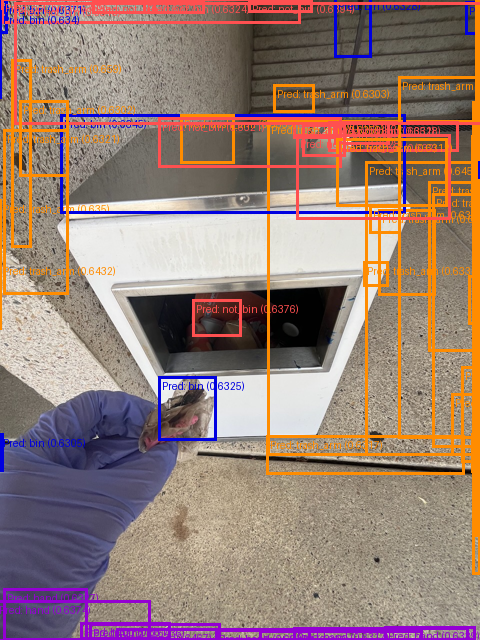

In [64]:
# 1. Extract scores, labels and boxes
random_sample_pred_scores = random_sample_outputs_post_processed[0]["scores"]
random_sample_pred_labels = random_sample_outputs_post_processed[0]["labels"]
random_sample_pred_boxes = half_boxes(random_sample_outputs_post_processed[0]["boxes"])

# 2. Create a list of labels and colours to plot on the image/boxes
random_sample_pred_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(random_sample_pred_labels, random_sample_pred_scores)]
random_sample_pred_colours = [colour_palette[id2label[label_pred.item()]] for label_pred in random_sample_pred_labels]

print(f"[INFO] Labels with scores: {random_sample_pred_labels_to_plot[:3]}...")

# 3. Plot the random sample image with randomly predicted boxes
# (these will be very poor since the model is not trained on our data yet)
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_image(random_sample["image"])),
        boxes=random_sample_pred_boxes, # boxes are in XYXY format, which is required for draw_bounding_boxes
        labels=random_sample_pred_labels_to_plot,
        colors=random_sample_pred_colours,
        width=3
    )
)

Woah! Those boxes don't look good at all both the label and the coordinates look off.

This should be expected though...

While our model has been pretrained on the COCO dataset, it hasn't been trained on our specific data.

The good news is we can hopefully (there are no guarantees in machine learning) improve our model's box predictions by fine-tuning it on our dataset.

# 12. Aside: Bounding box formats in and out of our model

We've done a fair bit of data transformation to get our data ready to go into our model and we've also taken a fair few steps to postprocess it into a usable format.

This is often a standard practice in many machine learning workflows.

Much of the work before ever training a model is preparing the data for the model.

And much of the work after training a model is preparing the data for your use case.

The following table highlights the different states our bounding boxes go in and out of.

TK image - turn this into a nice image of the workflow

| **Step** | **Box format** | **Scale** | **Goes into** |
| ----- | ----- | ----- | ----- |
| Starting data (default downloaded from Hugging Face) | `XYWH` or `[x1, y1, width, height]` | Absolute | `preprocess()` method |
| Out of [`preprocess()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess) | `CXCYWH` or `[center_x, center_y, width, height]` | Normalized | `model.forward()` |
| Out of [`model.forward()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward) | `CXCYWH` or `[center_x, center_y, width, height]` | Normalized | `post_process_object_detection()`|
| Out of [`post_process_object_detection()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.post_process_object_detection) | `XYXY` or `[x_top_left, y_top_left, x_bottom_right, y_bottom_right]` | Absolute (in relation to the `target_sizes` parameter). | Plotting or display function. |

Keeping track of these input and output formats is helpful for knowing the state of your data.

But remember, just because our current workflow is like this, doesn't mean all future workflows you work on will have the same transformation steps.

# 13. Preparing data at scale

We've performed preprocessing and postprocessing steps on a single data sample.

However, in practice, we'll likely want to work with many more samples.

Our model is hungry for more data.

So let's step it up a notch and write some code that's capable of preprocessing *many* samples to pass to our model.

We'll break it down into three subsections:

1. **Splitting the data** into training, validation and test sets. We'll train our model on the training set and check its performance on the validation and test sets (our model won't see any of these samples during training). We perform these splits before preprocessing the samples in them in case we'd like to perform different preprocessing steps depending on the split. For example, we may want to use [**data augmentation**](https://pytorch.org/vision/main/transforms.html) on the training set and not use it on the testing set.
2. **Preprocessing multiple samples at a time** by iterating over groups of samples. Rather than preprocess a single sample at a time, we'll write code capable of processing lists of examples simultaneously.
3. **Collate samples into batches** so our model can view multiple samples simultaneously. Rather than performing a forward pass on a single sample at a time, we'll pass **batches** of data to the model. For example, we may pass 32 samples (image and label pairs) at a time to our model for it to try and learn the patterns between them. We use batches of data rather than the whole dataset as it's often much more memory efficient. If you have a *really* large dataset, all of your samples may not fit into memory at once, so in practice, you break it up into smaller batches of samples.

Let's start by splitting the data into different sets.

## 13.1 Splitting the data into training and test sets

Right now our data is all in one big group.

However, it's best practice to split our data into two (or three) different sets:

1. **Training set (~70-80% of data)** - This is the data the model will learn from, all samples in this set are seen by the model during training.
2. **Validation set (~5-20% of data)** - This is the data we can fine-tune our model's hyperparameters on, all samples in this set are *not* seen by the model during training.
3. **Test set (~5-20% of data)** - This is the data we will evaluate what our model has learned after going through the training set, all samples in this set are *not* seen by the model during training.

Using the analogy of a student at univeristy, the **training set** would be the course materials throughout the semester, the **validation set** would be the practice exam and the **test set** would be the final exam.

If a student doesn't perform well on the final exam, then we would usually say perhaps the course materials weren't of the highest quality.

This is similar to our machine learning workflow.

In an ideal world, the samples in the training set are sufficiently representative of those in the test set and in turn, sufficiently representative of samples in the wild.

Before we split our dataset into different sets, let's remind ourselves of what it looks like.

In [65]:
# Original dataset (only a "train" split)
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

Wonderful! Right now, we've only got one split, `"train"`.

To make our required splits, we can call the [`train_test_split()`](https://huggingface.co/docs/datasets/en/package_reference/main_classes#datasets.Dataset.train_test_split) method on our dataset and pass in the size of the split we'd like via the `test_size` parameter.

For example, `test_size=0.3` means 30% of the data will go to the test set and 70% will go to the training set.

We'll make the following splits:

* 70% of data to training set.
* ~10% of data to validation set.
* ~20% of data to testing set.

To do so, we'll call `train_test_split()` twice with different amounts:

1. First on `dataset["train"]` with `test_size=0.3` to make the 70/30 training/test split, we'll save this split to the variable `dataset_split`.
2. Next on `dataset_split["test"]` with `test_size=0.66` to make the 66/33 test/validation split, we'll set this variable to `dataset_test_val_split`.

Once we've done this, we'll reassign all of the splits back to our original `dataset`.

We'll also set `seed=42` for reproducibility.

Let's do it!

TK image - make an image of these workflows to make it easier to understand

In [66]:
# 1. Split the data into "train" and "test" splits
dataset_split = dataset["train"].train_test_split(test_size=0.3, seed=42) # split the dataset into 70/30 train/test

# 2. Split the test split into "test" and "validation" splits
dataset_test_val_split = dataset_split["test"].train_test_split(test_size=0.66, seed=42) # split the test set into 40/60 validation/test

# Create "train" split from 1.
dataset["train"] = dataset_split["train"]

# Create a "validation" and "test" split from 2.
dataset["validation"] = dataset_test_val_split["train"]
dataset["test"] = dataset_test_val_split["test"]

# View the dataset (now with splits)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 115
    })
    test: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 224
    })
})

Perfect!

Now we've got three splits of our dataset to work with.

We'll make sure our model never sees the `validation` and `test` splits during training, so when evaluate it we know that it's only seeing new samples.

## 13.2 Writing a function for preprocessing multiple samples at a time

UPTOHERE - preprocessing multiple samples at a time

We've preprocessed and passed one sample through our model, new let's do the same for multiple samples.

We're going to work towards having a function that can go from a group or batch of samples (images and their annotations) and return them in preprocessed form (via [`transformers.ConditionalDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess)) ready to be used with our model.

Let's first remind ourselves of what a single unprocessed sample looks like.

In [67]:
# Get one sample from the training dataset
one_sample = dataset["train"][42]
one_sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 663,
 'annotations': {'file_name': ['1d2ea64a-0296-403d-93cd-31e3f116c995.jpeg',
   '1d2ea64a-0296-403d-93cd-31e3f116c995.jpeg'],
  'image_id': [663, 663],
  'category_id': [1, 5],
  'bbox': [[413.29998779296875,
    529.7000122070312,
    343.6000061035156,
    687.0999755859375],
   [435.8999938964844, 463.0, 77.19999694824219, 99.9000015258789]],
  'iscrowd': [0, 0],
  'area': [236087.5625, 7712.27978515625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

Awesome, we get an `image` in `PIL.Image.Image` form as well as a single dictionary of `annotations`.

How about if we were to inspect a group of three samples?

In [68]:
# Get three samples from the training set
group_of_samples = dataset["train"][0:3]

# Uncomment for full output (commented for brevity)
# group_of_samples

<details>

<summary>Output of random_samples</summary>

```
Signature:
{'image': [<PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>],
 'image_id': [69, 1027, 1092],
 'annotations': [{'file_name': ['c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg'],
   'image_id': [69, 69, 69, 69, 69, 69, 69, 69],
   'category_id': [5, 0, 1, 4, 4, 4, 4, 4],
   'bbox': [[360.20001220703125, 528.5, 177.1999969482422, 261.79998779296875],
    [298.29998779296875,
     495.1000061035156,
     381.1000061035156,
     505.70001220703125],
    [81.5999984741211,
     592.0999755859375,
     358.79998779296875,
     316.29998779296875],
    [1.2999999523162842,
     776.7000122070312,
     193.8000030517578,
     211.89999389648438],
    [301.1000061035156, 60.79999923706055, 146.89999389648438, 115.0],
    [501.0, 75.9000015258789, 24.200000762939453, 71.19999694824219],
    [546.4000244140625,
     54.70000076293945,
     130.3000030517578,
     115.0999984741211],
    [862.9000244140625,
     41.099998474121094,
     75.69999694824219,
     80.19999694824219]],
   'iscrowd': [0, 0, 0, 0, 0, 0, 0, 0],
   'area': [46390.9609375,
    192722.265625,
    113488.4375,
    41066.21875,
    16893.5,
    1723.0400390625,
    14997.5302734375,
    6071.14013671875]},
  {'file_name': ['b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg'],
   'image_id': [1027, 1027, 1027, 1027, 1027],
   'category_id': [5, 4, 1, 0, 0],
   'bbox': [[378.29998779296875, 657.5, 139.8000030517578, 165.10000610351562],
    [463.29998779296875, 754.5, 39.400001525878906, 30.299999237060547],
    [451.20001220703125,
     734.7999877929688,
     109.19999694824219,
     163.8000030517578],
    [140.39999389648438, 400.29998779296875, 460.8999938964844, 491.5],
    [2.299999952316284,
     322.29998779296875,
     201.6999969482422,
     429.20001220703125]],
   'iscrowd': [0, 0, 0, 0, 0],
   'area': [23080.98046875,
    1193.8199462890625,
    17886.9609375,
    226532.34375,
    86569.640625]},
  {'file_name': ['d822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg',
    'd822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg',
    'd822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg',
    'd822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg'],
   'image_id': [1092, 1092, 1092, 1092],
   'category_id': [2, 5, 1, 0],
   'bbox': [[97.80000305175781, 93.30000305175781, 177.5, 101.5999984741211],
    [342.20001220703125, 572.5999755859375, 350.0, 344.20001220703125],
    [185.1999969482422, 803.0, 304.3999938964844, 371.6000061035156],
    [219.39999389648438, 259.1000061035156, 598.7000122070312, 584.5]],
   'iscrowd': [0, 0, 0, 0],
   'area': [18034.0, 120470.0, 113115.0390625, 349940.15625]}],
 'label_source': ['manual_prodigy_label',
  'manual_prodigy_label',
  'manual_prodigy_label'],
 'image_source': ['manual_taken_photo',
  'manual_taken_photo',
  'manual_taken_photo']}
```

</details>

Okay, now we get a list of `image` objects as well as a list of `annotation` dictionaries and more in the format:

```json
{
    "image": [<PIL.Image.Image>, <PIL.Image.Image>, ...],
    "image_id": [int, int, ...],
    "annotations": [
        {
            "file_name": [str, str, ...],
            "image_id": [int, int, ...],
            "category_id": [int, int, ...],
            "bbox": [[float, float, float, float], ...],
            "iscrowd": [int, int, ...],
            "area": [float, float, ...]
        },
        {...},
        {...}
    ],
    "label_source": [str, str, ...],
    "image_source": [str, str, ...]
}
```

Knowing this structure, we'll want to write a function capable of taking it as input and then preparing it for the `preprocess` method.

::: {.callout-note}

Our data is in this structure (a dictionary of lists, rather than a list of dictionaries) because it is built on Hugging Face Datasets and [Hugging Face Datasets is built on Apache Arrow](https://huggingface.co/docs/datasets/en/about_arrow).

And [Apache Arrow](https://arrow.apache.org/) is column-orientated in nature.

So instead of our dataset being represented as many rows (list of dictionaries), it is represented as many columns (dictionary of lists).

:::

The `preprocess` method expects a list of images as well as COCO formatted annotations as input.

So to create our `preprocess_batch` function we'll:

1. Take in a list of examples (these will be in the format above), an `image_processor` and optional `transforms` (we don't need to pass these in for now but it's good to have the option).
2. Create empty lists of `images` and `coco_annotations` we'll fill throughout the rest of the function.
3. Extract the `image`, `image_id` and `annotations_dict` from our list of input examples.
4. Create lists of annotations attributes such as `bbox`, `category_id` and `area` (these are required for our `format_image_annotations_as_coco` function.
5. Optionally perform transforms/augmentations on the image and related boxes (because in object detection if you transform an image, should transform the related boxes as well).
6. Convert the annotations into COCO format using the `format_image_annotations_as_coco` helper function we created earlier.
7. Append the images and COCO formatted annotations to the empty lists created in 2.
8. Pass the list of images and COCO formatted annotations to the `image_processor.preprocess` method to get the preprocessed batch.
9. Return the preprocessed batch.

Let's do it!



In [69]:
# 1. Take in a list of examples, image processor and optional transforms
def preprocess_batch(examples,
                     image_processor,
                     transforms=None, # Note: Could optionally add transforms (e.g. data augmentation) here
                     ):
    """
    Preprocesses a batch of image data with annotations for object detection models.

    This function takes a batch of examples in a custom dataset format, extracts images and
    their corresponding annotations, and converts them into a format suitable for model training
    or inference using the provided image processor.

    Args:
        examples (dict): A dictionary containing the batch data with the following structure:
            - "image" (List[PIL.Image.Image]): List of PIL Image objects
            - "image_id" (List[int]): List of unique image identifiers
            - "annotations" (List[dict]): List of annotation dictionaries, where each contains:
                - "file_name" (List[str]): List of image filenames
                - "image_id" (List[int]): List of image identifiers
                - "category_id" (List[int]): List of object category IDs
                - "bbox" (List[List[float]]): List of bounding boxes as [x, y, width, height]
                - "iscrowd" (List[int]): List of crowd indicators (0 or 1)
                - "area" (List[float]): List of object areas
            - "label_source" (List[str]): List of label sources
            - "image_source" (List[str]): List of image sources

        image_processor: An image processor object to preprocess images for model input.
            For example, can be `transformers.ConditionalDetrImageProcessor`.

        transforms (optional): Image and annotations transforms for data augmentation.
            Defaults to None.

    Returns:
        dict: Preprocessed batch with images and annotations converted to tensors
            in the format required for a `transformers.ConditionalDetrForObjectDetection` model.

    Note:
        The `format_image_annotations_as_coco` function converts the input annotation format to COCO
        format before applying the image_processor. This is required as the image_processor is designed
        to handle COCO format annotations.
    """
    # 2. Create empty lists to store images and annotations
    images = []
    coco_annotations = []

    # 3. Extract the image, image_id and annotations from the examples
    for image, image_id, annotations_dict in zip(examples["image"],
                                                 examples["image_id"],
                                                 examples["annotations"]):

        # 4. Create lists of annotation attributes
        bbox_list = annotations_dict["bbox"]
        category_list = annotations_dict["category_id"]
        area_list = annotations_dict["area"]

        ###
        # 5. Note: Could optionally apply a transform/augmentation here.
        if transforms:
            # Perform transform on image/boxes
            pass
        ###

        # 6. Format the annotations into COCO format
        cooc_format_annotations = format_image_annotations_as_coco(image_id=image_id,
                                                                   categories=category_list,
                                                                   areas=area_list,
                                                                   bboxes=bbox_list)

        # 7. Add images/annotations to their respective lists
        images.append(image) # Note: may need to open image if it is an image path rather than PIL.Image
        coco_annotations.append(cooc_format_annotations)


    # 8. Apply the image processor to lists of images and annotations
    preprocessed_batch = image_processor.preprocess(images=images,
                                                    annotations=coco_annotations,
                                                    return_tensors="pt")

    # 9. Return the preprocessed batch
    return preprocessed_batch

Nice!

Now how about we test it out on our `group_of_samples`?

In [70]:
preprocessed_samples = preprocess_batch(examples=group_of_samples,
                                        image_processor=image_processor)

preprocessed_samples.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Perfect, we get the same `keys()` as with our single sample.

Except this time, we've got multiple samples, let's check the shape.

In [71]:
# Check the shape of our preprocessed samples
print(f"[INFO] Shape of preprocessed samples: {preprocessed_samples['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

[INFO] Shape of preprocessed samples: torch.Size([3, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


Wonderful, our batch of three samples have been preprocessed and are ready for input to our model.

## 13.3 Applying our preprocessing function to each data split

We've seen our `preprocess_batch` function in action on a small group of samples.

Now let's apply it to our different data splits.

To do so, we can call the [`with_transform()`](https://huggingface.co/docs/datasets/en/package_reference/main_classes#datasets.Dataset.with_transform) method on our target dataset split and pass it our desired `transform`.

Using `with_transform()` means our transformations will be applied on-the-fly when we call on our split datasets.

Because the `with_transform()` method expects a callable with a single argument (the input examples), we'll turn our `preprocess_batch` into a [Python partial function](https://docs.python.org/3/library/functools.html#functools.partial).

Doing this will mean we can prefill the `image_processor` and optionally the `transforms` parameter of our `preprocess_batch` function meaning it will only take `examples` as input, this is inline with the `with_transform()` method.

In [72]:
# Create a partial function for preprocessing
from functools import partial

# Note: Could create separate preprocess functions with different inputs depending on the split
# (e.g. use data augmentation on training but not on validation/test)
preprocess_batch_partial = partial(preprocess_batch,
                                   image_processor=image_processor,
                                   transforms=None) # could use transforms here if wanted

# Inspect the preprocess_batch_partial function
# preprocess_batch_partial

Beautiful, now let's pass the `preprocess_batch_partial` function to the `with_transform()` method on each of our data splits.

In [73]:
# Create a copy of the original dataset
# (we don't need to do this, this is just so we can inspect the original dataset later on)
processed_dataset = dataset.copy()

# Apply the preprocessing function to the datasets (the preprocessing will happen on the fly, e.g. when the dataset is called rather than in-place)
processed_dataset["train"] = dataset["train"].with_transform(transform=preprocess_batch_partial)
processed_dataset["validation"] = dataset["validation"].with_transform(transform=preprocess_batch_partial)
processed_dataset["test"] = dataset["test"].with_transform(transform=preprocess_batch_partial)

Now when we get (via `__getitem__`) one of our samples from a `processed_dataset` split, it will be preprocessed on the fly.

In [74]:
# Get an item from the dataset (in will be preprocessed as we get it)
processed_dataset["train"][42]

{'pixel_values': tensor([[[-1.7583, -1.1247, -1.0390,  ..., -0.6965, -0.7822, -0.4568],
          [-0.9877, -1.4158, -0.9363,  ..., -0.3712, -0.1143, -0.0801],
          [-0.9363, -0.9877, -1.0048,  ...,  0.9646,  0.3652, -0.1828],
          ...,
          [ 0.0398, -0.7479, -1.1418,  ..., -0.9192, -1.1075, -1.3987],
          [-0.0116,  0.2796, -1.0733,  ..., -1.3644, -1.4843, -1.1760],
          [-0.7308,  0.1939, -0.7479,  ..., -1.2274, -1.6555, -1.4672]],
 
         [[-1.6155, -0.9678, -0.8978,  ..., -0.6176, -0.7227, -0.3550],
          [-0.8277, -1.2829, -0.7927,  ..., -0.2850, -0.0399,  0.0126],
          [-0.7927, -0.8452, -0.8803,  ...,  1.0805,  0.4503, -0.0924],
          ...,
          [ 0.0476, -0.7752, -1.1954,  ..., -0.7402, -0.8978, -1.1429],
          [-0.0224,  0.2402, -1.1429,  ..., -1.1779, -1.2129, -0.8803],
          [-0.7752,  0.1527, -0.8277,  ..., -0.9853, -1.3529, -1.1429]],
 
         [[-1.6476, -1.0376, -1.0724,  ..., -1.0550, -1.1944, -1.0027],
          [-

And the same happens when we get multiple (a batch) samples!

In [75]:
# Now when we call one or more of our samples, the preprocessing will take place
batch_size_to_get = 32
print(f"[INFO] Shape of preprocessed images: {processed_dataset['train'][:batch_size_to_get]['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

[INFO] Shape of preprocessed images: torch.Size([32, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


In [76]:
# We can pass these straight to our model! (note: may take a while if it's on CPU)
# model(processed_dataset["train"][:batch_size_to_get]["pixel_values"]) # uncomment to view output

## 13.4 Creating a collation function

We now preprocess multiple samples at once.

Time to create a collation function which will tell our model trainer how to stack these samples together into batches.

We do this because processing more samples at once (e.g. 32 samples in a batch) in a batch is generally more efficient than one sample at a time or trying to process all samples at once.

Our collation function will be used for the [`data_collator` parameter](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.data_collator) in our [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer) instance later on.

The input to our data collation function will be the output of `image_processor.preprocess()` (a preprocessed sample).

And the output will be passed as a batch (we'll define the batch size later on) to our model's [`forward()` method](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrModel.forward).

::: {.callout-note}
What batch size should I use?

You should generally use the batch size which uses the maximum amount of GPU memory you have.

For example, if you have 16GB of GPU memory and a batch size of 32 only uses 8GB of that memory, you should try doubling the batch size to 64.

The ideal batch size for a given dataset/model/hardware is often discovered in an iterative process.
:::

In [77]:
from typing import List, Dict, Any

def data_collate_function(preprocessed_batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Stacks together groups of preprocessed samples into batches for our model.

    Args:
        preprocessed_batch: A list of dictionaries where each dictionary represnets a preprocessed sample.

    Returns:
        collated_data: A dictionary containing the batched data ready in the format our model
            is expecting. The dictionary has the following keys:
                - "pixel_values": A stacked tensor of preprocessed pixel values.
                - "labels": A list of label dictionaries.
                - "pixel_mask": (Optional) A stacked tensor of pixel masks (this will be present
                    only if the input contains a "pixel_mask" key.
    """
    # Create an empty dictionary (our model wants a dictionary input)
    collated_data = {}

    # Stack together a collection of pixel_values tensors
    collated_data["pixel_values"] = torch.stack([sample["pixel_values"] for sample in preprocessed_batch])

    # Get the labels (these are dictionaries so no need to use torch.stack)
    collated_data["labels"] = [sample["labels"] for sample in preprocessed_batch]

    # If there is a pixel_mask key, return the pixel_mask's as well
    if "pixel_mask" in preprocessed_batch[0]:
        collated_data["pixel_mask"] = torch.stack([sample["pixel_mask"] for sample in preprocessed_batch])

    return collated_data

Excellent! Now let's try out our data collation function.

In [78]:
%%time

# Try data_collate_function
example_collated_data_batch = data_collate_function(processed_dataset["train"].select(range(32)))
example_collated_data_batch.keys()

CPU times: user 4.06 s, sys: 158 ms, total: 4.22 s
Wall time: 4.25 s


dict_keys(['pixel_values', 'labels', 'pixel_mask'])

Perfect! Looks like it worked. We've now got a batch of preprocessed images and label pairs.

Let's check the shapes.

In [79]:
# Check shapes of batched preprocessed samples
print(f"[INFO] Batch of pixel value shapes: {example_collated_data_batch['pixel_values'].shape}")
print(f"[INFO] Batch of labels: {example_collated_data_batch['labels']}")
if "pixel_mask" in example_collated_data_batch:
    print(f"[INFO] Batch of pixel masks: {example_collated_data_batch['pixel_mask'].shape}")

[INFO] Batch of pixel value shapes: torch.Size([32, 3, 640, 480])
[INFO] Batch of labels: [{'size': tensor([640, 480]), 'image_id': tensor([69]), 'class_labels': tensor([5, 0, 1, 4, 4, 4, 4, 4]), 'boxes': tensor([[0.4675, 0.5152, 0.1846, 0.2045],
        [0.5092, 0.5843, 0.3970, 0.3951],
        [0.2719, 0.5861, 0.3738, 0.2471],
        [0.1023, 0.6896, 0.2019, 0.1655],
        [0.3902, 0.0924, 0.1530, 0.0898],
        [0.5345, 0.0871, 0.0252, 0.0556],
        [0.6370, 0.0877, 0.1357, 0.0899],
        [0.9383, 0.0634, 0.0789, 0.0627]]), 'area': tensor([11597.7402, 48180.5664, 28372.1094, 10266.5547,  4223.3750,   430.7600,
         3749.3826,  1517.7850]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([1280,  960])}, {'size': tensor([640, 480]), 'image_id': tensor([1027]), 'class_labels': tensor([5, 4, 1, 0, 0]), 'boxes': tensor([[0.4669, 0.5782, 0.1456, 0.1290],
        [0.5031, 0.6013, 0.0410, 0.0237],
        [0.5269, 0.6380, 0.1138, 0.1280],
        [0.3863, 0.50

Now let's try to pass the `"pixel_values"` through our model.

In [ ]:
%%time

# Try pass a batch through our model (note: this will be relatively slow if our model is on the CPU)
model = create_model()

# example_batch_outputs = model(example_collated_data_batch["pixel_values"])
example_batch_outputs = model(example_collated_data_batch["pixel_values"])
# example_batch_outputs # uncomment for full output
example_batch_outputs.keys()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [ ]:
# We get 300 predictions per image in our batch, each with a logit value for each of the classes in our dataset
example_batch_outputs.logits.shape

This is what will happen during training, our model will continually go over batches (the size of these batches will be defined by us) over data and try to match its own predictions with the ground truth labels.

In summary, we've created two major steps:

1. `preprocess_batch` - Preprocesses single or groups of samples into the specific format required by our model.
2. `data_collate_function` - Stacks together groups/batches of samples to be passed to our model's `forward()` method.

# 14. Setting up TrainingArguments and a Trainer instance to train our model

Data ready and prepared, time to train a model!

We'll use [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments) to set various hyperparameters for our model (many of these will be set by default, however, we can tweak them to our liking).

We'll also create an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer) which we can pass our preprocessed datasets for it to train/evaluate on.

To train a model, we'll go through the following steps:

1. Create a fresh instance of our model using the `create_model()` function.
2. Make a directory for saving our trained models to.
3. Define our model's hyperparameters using `transformers.TrainingArguments`, we'll take many of these settings from the assosciated research papers that introduced the models.
4. Create an instance of `transformers.Trainer` and pass it our training arguments from 2 as well as our preprocessed data.
5. Call [`transformers.Trainer.train()`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.train) to train the model from 1 on our own data.

Let's do it!

In [ ]:
# 1. Create a model instance
model = create_model()

Model ready, let's now create a folder where we can save our trained models to.

In [ ]:
from pathlib import Path

# 2. Make a models directory for saving models
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

Perfect! Time to setup our model's hyperparameters with `transformers.TrainingArguments`.

## 14.1 Setting up our TrainingArguments

The `transformers.TrainingArguments` class holds many of the hyperparameters/settings for training our model.

Many of them are set by default in the [`transformers.ConditionalDetrConfig`](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrConfig) class.

However, we can tweak any of them to our own liking.

Where do we get the settings from?

The original [*Conditional DETR for fast training convergence*](https://arxiv.org/abs/2108.06152) paper states that all hyperparameters are the same as the original DETR ([*End-to-End Object Detection with Transformers*](https://arxiv.org/abs/2005.12872)).

We can even dig into related papers such as [*DETRs Beat YOLOs on Real-time Object Detection*](https://arxiv.org/abs/2304.08069) and find the hyperaparameter settings as well.

The main hyperparameters we are going to set are:

| **Hyperparameter** | **Value** | **What does it do?** |
| ----- | ----- | ----- |
| `per_device_train_batch_size`, `per_device_eval_batch_size` | `16`, `32` or larger (hardware dependent) | Defines the number of samples passed to our model at one time. For example, if batch size is 16, our model will see 16 samples at a time. It's usually best practice to set this value to the highest your hardware can handle. |
| `learning_rate` | `0.0001` (as per the listed papers) | Defines the multiplier on the size of gradient updates during training. Too high and gradients will explode, too low and gradients won't update, both lead to poor training results. The papers mention two different learning rates for the backbone and the detection head, I tried these and got poor results (likely because of our smaller dataset), a single learning rate for the whole network turned out to be better. |
| `weight_decay` | `0.0001` (as per the listed papers) | Prevents model weights from getting too large by applying a small decay penalty over time. This prevents a single weight providing too much information. In essence, the model is forced to learn smaller, simpler weights to represent the data. A form of regularization (overfitting prevention). See more at [paperswithcode.com/method/weight-decay](https://paperswithcode.com/method/weight-decay). |
| `max_grad_norm` | `0.1` (as per the listed papers) | Prevents gradients from getting too large during training. This will help to ensure stable training. See more at [paperswithcode.com/method/gradient-clipping](https://paperswithcode.com/method/gradient-clipping). |
| `num_train_epochs` | `25` (depends on training data and available time) | Defines how many laps of the data your model will do. For example, setting epochs to 25 means the model will do 25 laps of the training data to learn different patterns. In practice, I've found this value to be a good starting point for our dataset and also because we are fine-tuning rather than training from scratch. However, if you had more data you might want to do more epochs (when training from scratch, the papers did 300 epochs). |
| `warmup_ratio` | `0.05` | Percentage of total training steps to take learning rate from `0` to to the set value (e.g. `0.0001`). Can help with training stability in the early training steps of the model by not doing too large updates when first starting out. The papers state `2000` warmup steps, however, in practice I found this to be too many for our smaller dataset. |
| `dataloader_num_workers` | `4` (hardware dependent) | Number of workers to load data from the CPU to the GPU. Higher is generally better if it is available, however, it can often cap out. Experimentally I've found that `0.5 * os.cpu_count()` generally works well. |

TK image - showcase different papers referencing the hyperparameters for the models

It's important to note that all of these values can be experimented with.

And just because a research paper mentions a specific value, doesn't mean you have to use.

For example, all the mentioned research papers tend to focus on training a model from scratch on the COCO dataset (330k images, 80 classes).

Which is a much larger dataset with more classes than our dataset (1k images, 7 classes) which we are trying to fine-tune an existing model on rather than train from scratch.

There are many more possible arguments/settings we've left out in the above table but if you'd like to explore these, I'd encourage you to check out the documentation for [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).


In [ ]:
from transformers import TrainingArguments

# Hardware dependent hyperparameters
# Set the batch size according to the memory you have available on your GPU
# e.g. on my NVIDIA RTX 4090 with 24GB of VRAM, I can use a batch size of 32
# without running out of memory
BATCH_SIZE = 32
DATALOADER_NUM_WORKERS = 4 # note: if you're on Google Colab, you may have to lower this to os.cpu_count() or to 0

# Set number of epochs to how many laps you'd like to do over the data
NUM_EPOCHS = 25

# Setup hyperameters for training from the DETR paper(s)
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
MAX_GRAD_NORM = 0.1
WARMUP_RATIO = 0.05 # learning rate warmup from 0 to learning_rate as a ratio of total steps (e.g. 0.05 = 5% of total steps)

# Create directory to save models to
OUTPUT_DIR = Path(models_dir, "detr_finetuned_trashify_box_detector_v1")
print(f"[INFO] Saving model to: {OUTPUT_DIR}")

# Create TrainingArguments to pass to Trainer
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    warmup_ratio=WARMUP_RATIO,
    # warmup_steps=2000, # number of warmup steps from 0 to learning_rate (overrides warmup_ratio, found this to be too long for our dataset)
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    fp16=True, # use mixed precision training
    dataloader_num_workers=DATALOADER_NUM_WORKERS, # note: if you're on Google Colab, you may have to lower this to os.cpu_count() or to 0
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, # want to minimize eval_loss (e.g. lower is better)
    report_to="none", # don't save experiments to a third party service
    push_to_hub=False,
    eval_do_concat_batches=False,
)

## 14.2 Optional: Setting up an optimizer for multiple learning rates

In the papers that mentioned the DETR model we're using, they state that they used a different learning rate value for the backbone (`learning_rate=1e-5`) as well as the object detection head (`learning_rate=1e-4`).

To set this up ourselves, we can extract which parameters of our model belong to the `backbone` as well as which don't.

To find the backbone parameters, we can loop through our model's `named_parameters()` method and filter for any which contain the string `"backbone"` in their name.

We'll append these to a list called `backbone_parameters` and assume any that don't have `"backbone"` in their name are not part of the model's backbone.

We can use these two lists of parameters to pass to [`torch.optim.AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) with different learning rate values for each.

::: {.callout-note}
In my experiments with our smaller dataset size (~1100 images), I found that setting two different learning rates for the backbone and the object detection head led to poorer performance than just setting a single learning rate for the whole model.

The code below is an example of how to create a custom optimizer with different learning rates for different parts of the model.

However, in our actual training code, we'll use a single learning rate for the whole model.
:::

We can then subclass [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer) and update the method [`create_optimizer()`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.create_optimizer) to use our custom optimizer.

In [ ]:
from transformers import Trainer

# Create lists for different kinds of parameters
backbone_parameters = []
other_parameters = []

# Can loop through model parameters and extract different model sections
for name, param in model.model.named_parameters():
    if "backbone" in name:
        # print(f"Backbone parameter: {name}")
        backbone_parameters.append(param)
    else:
        # print(f"Other parameter: {name}")
        other_parameters.append(param)

print(f"[INFO] Number of backbone parameter modules: {len(backbone_parameters)}")
print(f"[INFO] Number of other parameter modules: {len(other_parameters)}")

# Setup a custom subclass of Trainer to use different learning rates for different parts of the model
class CustomTrainer(Trainer):
    def create_optimizer(self):
        self.optimizer = torch.optim.AdamW([
            {"params": backbone_parameters, "lr": 1e-4},
            {"params": other_parameters, "lr": 1e-4}
        ], weight_decay=0.0001)
        return self.optimizer

Awesome!

Now if we wanted to use our custom optimizer, we could use `CustomTrainer` instead of `Trainer`.

## 14.3 Training our model with Trainer

UPTOHERE:

- training a model... (e.g. calling `trainer.train()`)
- evaluating our model with an evaluation metric
- we should make a simple mAP metric to evaluate our model (can also evaluate during training)
- I should read up on the mAP metric and take the long road to evaluate our model so I can learn how to do it...
- Next: read up on mAP metric and implement a small example in Google Colab with a demo box?

Evaluation function is comprised of the following:

* See the code on GitHub: https://github.com/huggingface/transformers/blob/336dc69d63d56f232a183a3e7f52790429b871ef/examples/pytorch/object-detection/run_object_detection.py#L160
* Mean Average Precision metric from TorchMetrics: https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html
    * See a blog post for mAP: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173
* `transformersEvalPrediction` (these come out of the `Trainer.evaluate` method) - https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction
    * See `Trainer.evaluate` - https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.evaluate

In [ ]:
import numpy as np

from typing import Optional, Mapping

from transformers import EvalPrediction

from torchvision.ops import box_convert

from torchmetrics.detection.mean_ap import MeanAveragePrecision

def convert_bbox_cxcywh_to_xyxy_absolute(boxes, image_size_target):
    # Convert normalized CXCYWH (output of model) -> absolute XYXY format (required for evaluation)
    boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

    # Convert normalized box coordinates to absolute pixel values based on the target size
    image_size_target_height = image_size_target[0]
    image_size_target_width = image_size_target[1]
    boxes = boxes * torch.tensor([image_size_target_width, image_size_target_height, image_size_target_width, image_size_target_height])

    return boxes

@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

# Source is slightly modified version of: https://github.com/huggingface/transformers/blob/336dc69d63d56f232a183a3e7f52790429b871ef/examples/pytorch/object-detection/run_object_detection.py#L160
@torch.no_grad()
def compute_metrics(
    evaluation_results: EvalPrediction, # these come out of the Trainer.evaluate method, see: https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction
    image_processor: AutoImageProcessor,
    threshold: float = 0.0,
    id2label: Optional[Mapping[int, str]] = None,
) -> Mapping[str, float]:
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch])) # turn into a list of numpy arrays first, then tensors
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_cxcywh_to_xyxy_absolute(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    # Optional: mAR@100 per class
    mar_100_per_class = metrics.pop("mar_100_per_class")
    # for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
    for class_id, class_map in zip(classes, map_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        # Optional: mAR@100 per class
        # metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics

# Create a partial function for our compute_metrics function (we'll pass this to compute_metrics in Trainer)
eval_compute_metrics_fn = partial(
        compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [ ]:
# Note: Depending on the size/speed of your GPU, this may take a while
from transformers import Trainer

model_v1_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    # data_collator=DefaultDataCollator(),
    # tokenizer=image_processor,
    data_collator=data_collate_function,
    # compute_metrics=None # TODO: TK - can add a metrics function, just see if model trains first, see here for an example: https://github.com/huggingface/transformers/blob/336dc69d63d56f232a183a3e7f52790429b871ef/examples/pytorch/object-detection/run_object_detection.py#L160
    compute_metrics=eval_compute_metrics_fn
)

model_v1_results = model_v1_trainer.train()

UPTOHERE:

- going through training steps and making sure we end with a model training
- Plot the loss curves + mAP curves (make sure the loss going down, mAP going up)
- TK - if your loss values aren't the exact same, this is because of the randomness of machine learning, what's important is that the direction is similar (e.g. loss going down)
- notes on training:
    - 25 epochs gets good baseline results
    - 50 epochs (longer training) gets better results but takes 2x the time (this is a good extension for someone to try)

In [ ]:
# # 25 epochs
# # Epoch	Training Loss	Validation Loss	Map	Map 50	Map 75	Map Small	Map Medium	Map Large	Mar 1	Mar 10	Mar 100	Mar Small	Mar Medium	Mar Large	Map Bin	Map Hand	Map Not Bin	Map Not Hand	Map Not Trash	Map Trash	Map Trash Arm
# # 1	12.257200	4.579205	0.000700	0.003100	0.000300	0.000000	0.001100	0.000700	0.005600	0.011000	0.044300	0.000000	0.014800	0.043800	0.003100	0.000000	0.000000	-1.000000	0.000000	0.001000	0.000100
# # 2	3.214800	2.093854	0.012600	0.027700	0.009400	0.000000	0.002300	0.012900	0.027500	0.091400	0.136600	0.000000	0.056800	0.142000	0.066100	0.001500	0.000000	-1.000000	0.001600	0.006700	0.000000
# # 3	2.031300	1.615478	0.022200	0.054700	0.017600	0.000000	0.005100	0.022500	0.051500	0.157800	0.202400	0.000000	0.052300	0.204500	0.107500	0.007300	0.000000	-1.000000	0.000300	0.018000	0.000000
# # 4	1.750000	1.561830	0.060300	0.118400	0.057600	0.000000	0.007500	0.063100	0.097500	0.253500	0.302300	0.000000	0.237500	0.306400	0.228100	0.055700	0.000000	-1.000000	0.001500	0.076500	0.000000
# # 5	1.617800	1.382881	0.064500	0.121800	0.061400	0.000000	0.006800	0.066900	0.130900	0.292900	0.348300	0.000000	0.105700	0.360300	0.209900	0.087600	0.000000	No Log	0.002600	0.086600	0.000000
# # 6	1.510300	1.307172	0.072900	0.132500	0.068500	0.000000	0.009700	0.075700	0.151900	0.299400	0.352800	0.000000	0.112500	0.361600	0.199800	0.117100	0.000000	-1.000000	0.002400	0.118200	0.000000
# # 7	1.405600	1.251348	0.079900	0.130500	0.078700	0.000000	0.017500	0.083700	0.175700	0.310100	0.365800	0.000000	0.056800	0.383100	0.223800	0.048100	0.000000	No Log	0.002600	0.204600	0.000000
# # 8	1.331100	1.159470	0.113300	0.180400	0.120800	0.000000	0.028400	0.116000	0.210500	0.345200	0.392100	0.000000	0.130700	0.403300	0.313500	0.154200	0.000000	No Log	0.006600	0.205600	0.000000
# # 9	1.221300	1.101122	0.144700	0.227600	0.156400	0.025200	0.019500	0.148800	0.232200	0.385000	0.416300	0.025000	0.134100	0.433900	0.377000	0.264400	0.000000	No Log	0.012300	0.214600	0.000000
# # 10	1.179900	1.075704	0.163600	0.247600	0.181500	0.000000	0.038200	0.168100	0.231600	0.387100	0.434300	0.000000	0.164800	0.455400	0.457000	0.255800	0.000000	-1.000000	0.017300	0.251400	0.000000
# # 11	1.145600	1.023341	0.204600	0.295000	0.230600	0.050500	0.039500	0.211200	0.257700	0.425600	0.457900	0.050000	0.142000	0.487100	0.557100	0.334300	0.000600	-1.000000	0.026500	0.309000	0.000000
# # 12	1.136500	1.016237	0.217600	0.319900	0.244700	0.000000	0.035900	0.225000	0.253500	0.431300	0.457300	0.000000	0.202300	0.487200	0.585900	0.347900	0.000700	-1.000000	0.027600	0.343800	0.000000
# # 13	1.117300	0.968450	0.238400	0.348400	0.265800	0.000000	0.046200	0.247500	0.274400	0.443500	0.471100	0.000000	0.294300	0.504300	0.583500	0.394100	0.000400	-1.000000	0.036700	0.415800	0.000000
# # 14	1.022700	0.964383	0.259700	0.384800	0.289100	0.000000	0.067500	0.269300	0.274300	0.475400	0.498700	0.000000	0.267000	0.544700	0.637500	0.454800	0.002400	-1.000000	0.039700	0.424200	0.000000
# # 15	1.039000	0.985401	0.260200	0.394400	0.283300	0.000000	0.049100	0.269700	0.286400	0.515200	0.536000	0.000000	0.185200	0.590000	0.621600	0.450200	0.005300	-1.000000	0.042100	0.441800	0.000500
# # 16	1.012600	0.940276	0.269900	0.411300	0.311300	0.000000	0.073900	0.279600	0.289500	0.504500	0.526500	0.000000	0.272700	0.576900	0.634600	0.460400	0.004900	-1.000000	0.053900	0.465300	0.000000
# # 17	0.928400	0.934266	0.276900	0.413600	0.309300	0.000000	0.070100	0.290400	0.297700	0.590600	0.609800	0.000000	0.308500	0.659700	0.661100	0.472700	0.006000	-1.000000	0.066200	0.452900	0.002500
# # 18	0.939700	0.919036	0.277800	0.417400	0.313000	0.000000	0.082100	0.288300	0.290600	0.634400	0.652700	0.000000	0.318700	0.697400	0.638400	0.485200	0.005000	-1.000000	0.061900	0.470600	0.006000
# # 19	0.860800	0.921640	0.279500	0.424300	0.308700	0.000000	0.068900	0.291900	0.306400	0.627100	0.648800	0.000000	0.263100	0.700300	0.646300	0.490200	0.007300	-1.000000	0.069300	0.459000	0.004700
# # 20	0.888200	0.908211	0.290500	0.435600	0.329600	0.025200	0.066200	0.303200	0.309100	0.641300	0.660500	0.025000	0.282400	0.711400	0.660700	0.519400	0.006700	-1.000000	0.079200	0.471500	0.005800
# # 21	0.865500	0.907514	0.289400	0.429000	0.333000	0.000000	0.080400	0.302600	0.303400	0.650900	0.669600	0.000000	0.304000	0.720300	0.667100	0.504400	0.006100	-1.000000	0.071600	0.480000	0.007100
# # 22	0.841000	0.897333	0.296700	0.437500	0.335400	0.000000	0.087800	0.311200	0.307200	0.651100	0.664800	0.000000	0.281800	0.718600	0.671300	0.534000	0.005100	-1.000000	0.073900	0.488800	0.006800
# # 23	0.821500	0.895820	0.299100	0.441800	0.339100	0.000000	0.087100	0.313200	0.314600	0.651800	0.670400	0.000000	0.336900	0.718500	0.670900	0.548300	0.005400	-1.000000	0.074900	0.488800	0.006400
# # 24	0.798200	0.892997	0.296100	0.441700	0.335200	0.000000	0.075000	0.310400	0.310500	0.638100	0.656000	0.000000	0.306800	0.705000	0.670700	0.534100	0.005300	-1.000000	0.076800	0.483200	0.006700
# # 25	0.786300	0.894873	0.296400	0.442700	0.335400	0.000000	0.075000	0.311800	0.309700	0.635700	0.655900	0.000000	0.293700	0.707600	0.671900	0.535700	0.005100	-1.000000	0.076700	0.482500	0.006400

# # 50 epochs
# Epoch	Training Loss	Validation Loss	Map	Map 50	Map 75	Map Small	Map Medium	Map Large	Mar 1	Mar 10	Mar 100	Mar Small	Mar Medium	Mar Large	Map Bin	Map Hand	Map Not Bin	Map Not Hand	Map Not Trash	Map Trash	Map Trash Arm
# 1	61.998300	29.889622	0.000300	0.001000	0.000100	0.000000	0.000000	0.000500	0.002800	0.011600	0.029300	0.000000	0.000000	0.030400	0.000500	0.000400	0.000000	-1.000000	0.000000	0.000600	0.000000
# 2	11.920100	3.913074	0.000000	0.000100	0.000000	0.000000	0.000000	0.000000	0.000000	0.000700	0.000700	0.000000	0.000000	0.000800	0.000000	0.000000	0.000000	No Log	0.000000	0.000100	0.000000
# 3	2.872600	1.999650	0.017200	0.042100	0.012400	0.000000	0.004700	0.017500	0.029800	0.148200	0.201100	0.000000	0.036400	0.206600	0.081900	0.005500	0.000000	-1.000000	0.000300	0.015400	0.000000
# 4	2.044500	1.702604	0.019800	0.050300	0.013200	0.000000	0.004700	0.020800	0.051700	0.157200	0.222200	0.000000	0.033000	0.228900	0.038300	0.044200	0.000000	-1.000000	0.000100	0.036300	0.000000
# 5	1.773500	1.489281	0.033800	0.075200	0.028200	0.000000	0.010100	0.035100	0.081800	0.210300	0.265600	0.000000	0.064800	0.272200	0.106600	0.047500	0.000000	No Log	0.000700	0.047800	0.000000
# 6	1.651000	1.427438	0.055900	0.104200	0.057300	0.000000	0.012600	0.056700	0.117200	0.257700	0.323200	0.000000	0.072700	0.330300	0.178000	0.098700	0.000000	No Log	0.000000	0.058800	0.000000
# 7	1.555300	1.418692	0.062700	0.115600	0.059800	0.000000	0.018700	0.063600	0.124000	0.273100	0.320400	0.000000	0.044300	0.328100	0.158000	0.141500	0.000000	-1.000000	0.000100	0.076300	0.000000
# 8	1.488100	1.246883	0.067600	0.117500	0.065600	0.000000	0.021800	0.068800	0.155800	0.306300	0.359700	0.000000	0.088600	0.375000	0.198000	0.094800	0.000000	No Log	0.001500	0.111000	0.000000
# 9	1.410900	1.337418	0.068200	0.128300	0.065800	0.000000	0.019200	0.068700	0.161000	0.282400	0.334600	0.000000	0.108000	0.340400	0.197300	0.139100	0.000000	No Log	0.000700	0.072200	0.000000
# 10	1.405900	1.198891	0.097000	0.160900	0.100100	0.000000	0.020400	0.099000	0.201600	0.327300	0.374400	0.000000	0.127300	0.384000	0.243500	0.221500	0.000000	No Log	0.001900	0.115300	0.000000
# 11	1.339600	1.184751	0.093200	0.147700	0.100400	0.000000	0.023500	0.095200	0.199100	0.342100	0.393800	0.000000	0.089800	0.412500	0.233400	0.193300	0.000000	No Log	0.005000	0.127800	0.000000
# 12	1.322600	1.155094	0.129100	0.203800	0.138700	0.000000	0.013500	0.131800	0.229300	0.355500	0.403500	0.000000	0.109100	0.422200	0.378100	0.266500	0.000000	-1.000000	0.006700	0.123400	0.000000
# 13	1.328200	1.137684	0.124100	0.190000	0.129300	0.000000	0.013200	0.127800	0.224100	0.372900	0.419500	0.000000	0.106800	0.442500	0.330900	0.229900	0.000000	No Log	0.010100	0.173800	0.000000
# 14	1.207300	1.071396	0.163700	0.243600	0.174900	0.000000	0.036600	0.167900	0.241100	0.390200	0.431400	0.000000	0.125000	0.457400	0.425600	0.336300	0.000000	No Log	0.013100	0.207000	0.000000
# 15	1.230200	1.066224	0.176400	0.271200	0.190900	0.000000	0.044600	0.180000	0.242400	0.379000	0.424400	0.000000	0.119300	0.446900	0.477700	0.363600	0.000000	No Log	0.010100	0.207200	0.000000
# 16	1.216300	1.033326	0.212500	0.331700	0.217800	0.000000	0.050400	0.217400	0.256500	0.406400	0.438000	0.000000	0.331800	0.461300	0.539800	0.450800	0.000000	-1.000000	0.018300	0.265900	0.000000
# 17	1.102900	0.971974	0.242100	0.366900	0.271200	0.000000	0.061100	0.249300	0.283700	0.445900	0.472900	0.000000	0.286400	0.505500	0.601400	0.480600	0.000800	-1.000000	0.046000	0.324100	0.000000
# 18	1.118400	0.970455	0.259500	0.387200	0.285700	0.000000	0.092200	0.266500	0.292000	0.451300	0.478300	0.000000	0.301100	0.511800	0.607900	0.504600	0.000700	-1.000000	0.043900	0.399800	0.000000
# 19	1.042000	0.967601	0.259800	0.395300	0.279900	0.000000	0.076400	0.267100	0.287500	0.507200	0.530000	0.000000	0.220500	0.569900	0.596500	0.509700	0.002400	-1.000000	0.048600	0.400700	0.001000
# 20	1.064600	0.944465	0.273800	0.412100	0.298800	0.025200	0.087900	0.282700	0.291900	0.532800	0.558100	0.025000	0.266500	0.595900	0.630500	0.485800	0.002400	-1.000000	0.078400	0.443900	0.002100
# 21	1.028700	0.944142	0.281000	0.419900	0.313000	0.000000	0.085900	0.291500	0.334500	0.611100	0.634500	0.000000	0.323900	0.672900	0.650000	0.486900	0.004900	-1.000000	0.064900	0.473900	0.005300
# 22	0.997400	0.932104	0.284800	0.432100	0.309500	0.075700	0.082800	0.294500	0.307500	0.623800	0.642300	0.075000	0.280100	0.680400	0.662000	0.490000	0.005500	-1.000000	0.070900	0.474300	0.006200
# 23	0.976200	0.916920	0.296600	0.447800	0.331300	0.050500	0.106500	0.307100	0.440900	0.608600	0.625300	0.050000	0.296000	0.661600	0.652400	0.522800	0.005000	-1.000000	0.086600	0.506100	0.006700
# 24	0.910200	0.926796	0.302600	0.454600	0.333800	0.000000	0.100200	0.312900	0.394900	0.614900	0.632800	0.000000	0.296600	0.673000	0.676300	0.529700	0.004300	-1.000000	0.093100	0.507500	0.005100
# 25	0.856500	0.927848	0.298400	0.452700	0.333100	0.025200	0.102300	0.309900	0.305100	0.596100	0.628000	0.025000	0.294900	0.665000	0.659500	0.518100	0.004400	-1.000000	0.094800	0.508600	0.005200
# 26	0.775300	0.911072	0.299500	0.458800	0.331300	0.025200	0.104800	0.311200	0.309600	0.596300	0.625900	0.025000	0.329000	0.663900	0.669500	0.537500	0.004000	-1.000000	0.077300	0.503100	0.005500
# 27	0.750800	0.904915	0.304500	0.449700	0.336000	0.041700	0.116300	0.314500	0.365000	0.611300	0.642400	0.050000	0.311900	0.677100	0.681200	0.524300	0.004000	-1.000000	0.077200	0.532100	0.007900
# 28	0.719000	0.896321	0.302000	0.445200	0.328900	0.050500	0.105400	0.313600	0.402800	0.601200	0.632200	0.050000	0.341500	0.670200	0.690700	0.518200	0.005000	-1.000000	0.089500	0.500900	0.007500
# 29	0.696800	0.876628	0.312700	0.465100	0.339100	0.025200	0.110800	0.325400	0.324300	0.636000	0.651200	0.025000	0.314200	0.687500	0.702100	0.528600	0.004600	-1.000000	0.107600	0.524600	0.008700
# 30	0.673600	0.893076	0.306200	0.459600	0.340800	0.000000	0.105400	0.319800	0.397700	0.622300	0.637500	0.000000	0.248300	0.686800	0.684300	0.527800	0.005400	-1.000000	0.104100	0.507100	0.008400
# 31	0.656000	0.880665	0.317400	0.466100	0.355800	0.101000	0.127100	0.331400	0.407000	0.640700	0.653900	0.100000	0.283000	0.699900	0.715900	0.525300	0.007600	-1.000000	0.107800	0.540300	0.007500
# 32	0.641600	0.881308	0.319100	0.469200	0.351600	0.050500	0.116600	0.335300	0.419000	0.631700	0.646500	0.050000	0.302300	0.687800	0.694800	0.541000	0.008700	-1.000000	0.115100	0.538300	0.016900
# 33	0.630900	0.872384	0.321800	0.483500	0.348600	0.025200	0.118400	0.337300	0.375800	0.631200	0.642800	0.025000	0.321000	0.686500	0.713900	0.543200	0.006600	-1.000000	0.125400	0.534800	0.006800
# 34	0.601500	0.867039	0.322600	0.474200	0.365000	0.025200	0.122200	0.338900	0.374300	0.636800	0.654000	0.025000	0.390900	0.689400	0.714800	0.531500	0.006300	-1.000000	0.127600	0.548800	0.006700
# 35	0.589100	0.865702	0.325600	0.477700	0.359800	0.012600	0.124500	0.340300	0.419100	0.631200	0.640800	0.025000	0.342000	0.679900	0.713000	0.555900	0.008400	-1.000000	0.127000	0.537900	0.011500
# 36	0.570200	0.863400	0.329900	0.487600	0.367800	0.000000	0.120900	0.344800	0.413700	0.626100	0.635300	0.000000	0.330700	0.676700	0.732300	0.562100	0.008200	-1.000000	0.135800	0.531900	0.009000
# 37	0.572800	0.867819	0.334600	0.490000	0.375500	0.000000	0.124800	0.350600	0.406900	0.620100	0.634700	0.000000	0.353400	0.679100	0.724500	0.571400	0.011300	-1.000000	0.144700	0.547700	0.007600
# 38	0.551600	0.878277	0.328400	0.489500	0.356200	0.025200	0.115700	0.344700	0.419600	0.624900	0.637700	0.025000	0.373900	0.678300	0.715600	0.558400	0.006800	-1.000000	0.154000	0.527100	0.008400
# 39	0.544900	0.875394	0.327500	0.482600	0.367100	0.075700	0.130200	0.344400	0.379400	0.629200	0.641100	0.075000	0.383000	0.676000	0.723600	0.541600	0.008400	-1.000000	0.146200	0.536900	0.008500
# 40	0.526600	0.868821	0.330400	0.486800	0.360500	0.050000	0.143700	0.346700	0.380400	0.628400	0.638700	0.050000	0.355700	0.676300	0.723500	0.542100	0.011400	-1.000000	0.160700	0.534000	0.010600
# 41	0.517000	0.870999	0.335300	0.491700	0.364400	0.025200	0.114200	0.352700	0.433600	0.626100	0.634300	0.025000	0.331800	0.669300	0.731000	0.554100	0.012400	-1.000000	0.160300	0.541300	0.012600
# 42	0.495300	0.876202	0.334900	0.492200	0.367800	0.012600	0.123700	0.352400	0.455700	0.621900	0.637400	0.025000	0.359100	0.677800	0.728100	0.557000	0.018100	-1.000000	0.155300	0.536000	0.015200
# 43	0.494200	0.860925	0.337400	0.497000	0.368300	0.050000	0.122900	0.354100	0.426900	0.619600	0.634000	0.050000	0.375600	0.667600	0.736100	0.546500	0.015700	-1.000000	0.163500	0.551300	0.011600
# 44	0.490000	0.880336	0.336900	0.498100	0.373100	0.000000	0.118500	0.355300	0.449600	0.625400	0.633400	0.000000	0.312500	0.673300	0.728800	0.546800	0.027900	-1.000000	0.160900	0.539500	0.017500
# 45	0.476800	0.873949	0.338300	0.497100	0.370800	0.000000	0.122000	0.357300	0.448100	0.621400	0.632500	0.000000	0.343200	0.672700	0.724400	0.557100	0.022300	-1.000000	0.168200	0.541900	0.015900
# 46	0.476600	0.881447	0.335800	0.494500	0.368600	0.000000	0.119000	0.353900	0.455400	0.621800	0.637500	0.000000	0.305700	0.681400	0.729700	0.550700	0.020600	-1.000000	0.163800	0.533800	0.016400
# 47	0.468400	0.881990	0.334900	0.498200	0.366200	0.000000	0.119200	0.354700	0.449900	0.616500	0.630500	0.000000	0.325600	0.674500	0.723700	0.545300	0.022100	-1.000000	0.173100	0.530000	0.015300
# 48	0.463700	0.880277	0.337800	0.497900	0.371900	0.000000	0.122900	0.356800	0.460000	0.625600	0.633100	0.000000	0.322200	0.674500	0.724000	0.555300	0.021900	-1.000000	0.175600	0.533600	0.016500
# 49	0.458200	0.878279	0.338000	0.495400	0.369900	0.000000	0.123000	0.356500	0.461000	0.629700	0.637300	0.000000	0.336400	0.677500	0.727100	0.553400	0.018100	-1.000000	0.174100	0.538700	0.016400
# 50	0.453200	0.873663	0.340100	0.499100	0.372300	0.000000	0.122000	0.359300	0.462100	0.630300	0.639900	0.000000	0.373300	0.678000	0.729100	0.553300	0.028000	-1.000000	0.173400	0.538800	0.017700

- TK - Plot loss curves
- TK - Note: May get an error at the beginning where a box is predicted a negative output. This will break training as boxes are expected to be positive floats.

# 15. Making predictions on the test dataset

Notes:
- Predicting on the whole test dataset only returns a single batch
- e.g. `test_dataset_preds = model_v1_trainer.predict(test_dataset=processed_dataset["test"])`
- Can just predict on samples individually?

In [ ]:
processed_dataset["test"][0]

In [ ]:
# Make predictions with trainer containing trained model
test_dataset_preds = model_v1_trainer.predict(test_dataset=processed_dataset["test"])
# test_dataset_preds

In [ ]:
processed_dataset["test"]

In [ ]:
test_dataset_preds.predictions[0]

In [ ]:
# Get the logits
test_pred_logits = test_dataset_preds.predictions[0][1]

# Get the boxes
test_pred_boxes = test_dataset_preds.predictions[0][2]

# Get the label IDs
test_pred_label_ids = test_dataset_preds.label_ids

# Check shapes
test_pred_logits.shape, test_pred_boxes.shape, len(test_pred_label_ids)

In [ ]:
len(processed_dataset["test"])

In [ ]:
%%time

# Get a random sample from the test preds
random_test_pred_index = random.randint(0, len(processed_dataset["test"]))
print(f"[INFO] Making predictions on test item with index: {random_test_pred_index}")

random_test_sample = processed_dataset["test"][random_test_pred_index]

# Do a single forward pass with the model
random_test_sample_outputs = model(pixel_values=random_test_sample["pixel_values"].unsqueeze(0).to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                   pixel_mask=None)
# random_test_sample_outputs

In [ ]:
# image_processor.preprocess?

TK - if your predictions aren't the exact same, this is because of the randomness of machine learning, what's important is that the direction is similar

In [ ]:
# Get a random sample from the test preds
random_test_pred_index = random.randint(0, len(processed_dataset["test"]))
print(f"[INFO] Making predictions on test item with index: {random_test_pred_index}")

random_test_sample = processed_dataset["test"][random_test_pred_index]

# # Do a single forward pass with the model
random_test_sample_outputs = model(pixel_values=random_test_sample["pixel_values"].unsqueeze(0).to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                   pixel_mask=None)

# Post process a random item from test preds
random_test_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=0.2, # prediction probability threshold for boxes (note: boxes from an untrained model will likely be bad)
    target_sizes=[random_test_sample["labels"]["orig_size"]] # original input image size (or whichever target size you'd like), required to be same number of input items in a list
)

# Plot the random sample test preds
# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = half_boxes(random_test_sample_outputs_post_processed[0]["boxes"])

# Create a list of labels to plot on the boxes
# TK - Update the colours here
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]

print(f"[INFO] Labels with scores:")
for label in random_test_sample_labels_to_plot:
    print(label)

# Plot the predicted boxes on the random test image
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_image(dataset["test"][random_test_pred_index]["image"])),
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

* TK - nice!!! these boxes look far better than our randomly predicted boxes with an untrained model...
* TK - plot the boxes versus the ground truth (e.g. ground truth = green, predictions = red)

## 15.1 Predict on image from filepath

In [ ]:
# Pred on image from pathname
from pathlib import Path
from PIL import Image
path_to_test_image_folder = Path("data/trashify_test_images")
test_image_filepaths = list(path_to_test_image_folder.rglob("*.jp*g"))
test_image_targ_filepath = random.choice(test_image_filepaths)
# test_image_targ_filepath = "data/trashify_test_images/IMG_6692.jpeg"
test_image_pil = Image.open(test_image_targ_filepath)
test_image_preprocessed = image_processor.preprocess(images=test_image_pil,
                                                     return_tensors="pt")

def get_image_dimensions_from_pil(image: Image.Image) -> torch.tensor:
    """
    Convert the dimensions of a PIL image to a PyTorch tensor in the order (height, width).

    Args:
        image (Image.Image): The input PIL image.

    Returns:
        torch.Tensor: A tensor containing the height and width of the image.
    """
    # Get (width, height) of image (PIL.Image.size returns width, height)
    width, height = image.size

    # Convert to a tensor in the order (height, width)
    image_dimensions_tensor = torch.tensor([height, width])

    return image_dimensions_tensor

# Get image original size
test_image_size = get_image_dimensions_from_pil(image=test_image_pil)

# Make predictions on the preprocessed image
random_test_sample_outputs = model(pixel_values=test_image_preprocessed["pixel_values"].to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                   pixel_mask=None)

THRESHOLD = 0.2

# Post process the predictions
random_test_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=THRESHOLD,
    target_sizes=[test_image_size] # needs to be same length as batch dimension of the logits (e.g. [[height, width]])
)

# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = random_test_sample_outputs_post_processed[0]["boxes"]

# Create a lsit of labels to plot on the boxes
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                                     for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]

print("[INFO] Labels with scores:")
for item in random_test_sample_labels_to_plot:
    print(item)

# Plot the predicted boxes on the random test image
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=test_image_pil),
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

# 16. Upload our trained model to Hugging Face Hub

TK - Let's make our model available for others to use.

In [ ]:
# TK
# Make extensions to make the model better... (e.g. data augmentation = harder training set = better overall validation loss)
# Model with data augmentation
# Model with longer training (e.g. 100 epochs)
# Research eval_do_concat_batches=False/True & see what the results do...

In [ ]:
# Save the model
from datetime import datetime

# TODO: update this save path so we know when the model was saved and what its parameters were
training_epochs_ = training_args.num_train_epochs
learning_rate_ = "{:.0e}".format(training_args.learning_rate)

model_save_path = f"models/learn_hf_microsoft_detr_finetuned_trashify_box_dataset_only_manual_data_no_aug_{training_epochs_}_epochs_lr_{learning_rate_}"
print(f"[INFO] Saving model to: {model_save_path}")
model_v1_trainer.save_model(model_save_path)

In [ ]:
# Push the model to the hub
# Note: this will require you to have your Hugging Face account setup
model_v1_trainer.push_to_hub(commit_message="upload trashify object detection model",
                    # token=None # Optional to add a token manually
                    )

# 17. Creating a demo of our model with Gradio

In [ ]:
%%writefile demos/trashify_object_detector/README.md
---
title: Trashify Demo V1 🚮
emoji: 🗑️
colorFrom: purple
colorTo: blue
sdk: gradio
sdk_version: 4.40.0
app_file: app.py
pinned: false
license: apache-2.0
---

# 🚮 Trashify Object Detector V1

Object detection demo to detect `trash`, `bin`, `hand`, `trash_arm`, `not_trash`, `not_bin`, `not_hand`.

Used as example for encouraging people to cleanup their local area.

If `trash`, `hand`, `bin` all detected = +1 point.

## Dataset

All Trashify models are trained on a custom hand-labelled dataset of people picking up trash and placing it in a bin.

The dataset can be found on Hugging Face as [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

## Demos

* [V1](https://huggingface.co/spaces/mrdbourke/trashify_demo_v1) = Fine-tuned DETR model trained *without* data augmentation.
* [V2](https://huggingface.co/spaces/mrdbourke/trashify_demo_v2) = Fine-tuned DETR model trained *with* data augmentation.
* [V3](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3) = Fine-tuned DETR model trained *with* data augmentation (same as V2) with an NMS (Non Maximum Suppression) post-processing step.

TK - add links to resources to learn more

In [ ]:
%%writefile demos/trashify_object_detector/requirements.txt
timm
gradio
torch
transformers

In [ ]:
%%writefile demos/trashify_object_detector/app.py
import gradio as gr
import torch
from PIL import Image, ImageDraw, ImageFont

from transformers import AutoImageProcessor
from transformers import AutoModelForObjectDetection

# Note: Can load from Hugging Face or can load from local
model_save_path = "mrdbourke/detr_finetuned_trashify_box_detector"

# Load the model and preprocessor
image_processor = AutoImageProcessor.from_pretrained(model_save_path)
model = AutoModelForObjectDetection.from_pretrained(model_save_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Get the id2label dictionary from the model
id2label = model.config.id2label

# Set up a colour dictionary for plotting boxes with different colours
color_dict = {
    "bin": "green",
    "trash": "blue",
    "hand": "purple",
    "trash_arm": "yellow",
    "not_trash": "red",
    "not_bin": "red",
    "not_hand": "red",
}

# Create helper functions for seeing if items from one list are in another
def any_in_list(list_a, list_b):
    "Returns True if any item from list_a is in list_b, otherwise False."
    return any(item in list_b for item in list_a)

def all_in_list(list_a, list_b):
    "Returns True if all items from list_a are in list_b, otherwise False."
    return all(item in list_b for item in list_a)

def predict_on_image(image, conf_threshold):
    with torch.no_grad():
        inputs = image_processor(images=[image], return_tensors="pt")
        outputs = model(**inputs.to(device))

        target_sizes = torch.tensor([[image.size[1], image.size[0]]]) # height, width

        results = image_processor.post_process_object_detection(outputs,
                                                                threshold=conf_threshold,
                                                                target_sizes=target_sizes)[0]
    # Return all items in results to CPU
    for key, value in results.items():
        try:
            results[key] = value.item().cpu() # can't get scalar as .item() so add try/except block
        except:
            results[key] = value.cpu()

    # Can return results as plotted on a PIL image (then display the image)
    draw = ImageDraw.Draw(image)

    # Get a font from ImageFont
    font = ImageFont.load_default(size=20)

    # Get class names as text for print out
    class_name_text_labels = []

    for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
        # Create coordinates
        x, y, x2, y2 = tuple(box.tolist())

        # Get label_name
        label_name = id2label[label.item()]
        targ_color = color_dict[label_name]
        class_name_text_labels.append(label_name)

        # Draw the rectangle
        draw.rectangle(xy=(x, y, x2, y2),
                       outline=targ_color,
                       width=3)

        # Create a text string to display
        text_string_to_show = f"{label_name} ({round(score.item(), 3)})"

        # Draw the text on the image
        draw.text(xy=(x, y),
                  text=text_string_to_show,
                  fill="white",
                  font=font)

    # Remove the draw each time
    del draw

    # Setup blank string to print out
    return_string = ""

    # Setup list of target items to discover
    target_items = ["trash", "bin", "hand"]

    # If no items detected or trash, bin, hand not in list, return notification
    if (len(class_name_text_labels) == 0) or not (any_in_list(list_a=target_items, list_b=class_name_text_labels)):
        return_string = f"No trash, bin or hand detected at confidence threshold {conf_threshold}. Try another image or lowering the confidence threshold."
        return image, return_string

    # If there are some missing, print the ones which are missing
    elif not all_in_list(list_a=target_items, list_b=class_name_text_labels):
        missing_items = []
        for item in target_items:
            if item not in class_name_text_labels:
                missing_items.append(item)
        return_string = f"Detected the following items: {class_name_text_labels}. But missing the following in order to get +1: {missing_items}. If this is an error, try another image or altering the confidence threshold. Otherwise, the model may need to be updated with better data."

    # If all 3 trash, bin, hand occur = + 1
    if all_in_list(list_a=target_items, list_b=class_name_text_labels):
        return_string = f"+1! Found the following items: {class_name_text_labels}, thank you for cleaning up the area!"

    print(return_string)

    return image, return_string

# Create the interface
demo = gr.Interface(
    fn=predict_on_image,
    inputs=[
        gr.Image(type="pil", label="Target Image"),
        gr.Slider(minimum=0, maximum=1, value=0.25, label="Confidence Threshold")
    ],
    outputs=[
        gr.Image(type="pil", label="Image Output"),
        gr.Text(label="Text Output")
    ],
    title="🚮 Trashify Object Detection Demo V1",
    description="Help clean up your local area! Upload an image and get +1 if there is all of the following items detected: trash, bin, hand.",
    # Examples come in the form of a list of lists, where each inner list contains elements to prefill the `inputs` parameter with
    examples=[
        ["examples/trashify_example_1.jpeg", 0.25],
        ["examples/trashify_example_2.jpeg", 0.25],
        ["examples/trashify_example_3.jpeg", 0.25],
    ],
    cache_examples=True
)

# Launch the demo
demo.launch()

## 17.1 Upload demo to Hugging Face Spaces to get it live

In [ ]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/trashify_object_detector" # TK - update this path
HF_TARGET_SPACE_NAME = "trashify_demo_v1"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading Trashify box detection model app.py"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

TK - see the demo here: https://huggingface.co/spaces/mrdbourke/trashify_demo_v1

## 17.2 Testing the hosted demo

> Add blockquote



In [ ]:
from IPython.display import HTML


# You can get embeddable HTML code for your demo by clicking the "Embed" button on the demo page
HTML(data='''
<iframe
    src="https://mrdbourke-trashify-demo-v1.hf.space"
    frameborder="0"
    width="850"
    height="1000"
></iframe>
''')

# 18. Improve our model with data augmentation

UPTOHERE
- Read for object detection augmentation (keep it simple)
- Check out the papers for detection augmentation
- Train a model with data augmentation
    - Compare the model's metrics between data augmentation and no data augmentation

## 18.1 Load dataset

In [ ]:
from datasets import load_dataset

# load_dataset?
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")

print(f"[INFO] Length of original dataset: {len(dataset['train'])}")

# Split the data
dataset_split = dataset["train"].train_test_split(test_size=0.3, seed=42) # split the dataset into 70/30 train/test
dataset_test_val_split = dataset_split["test"].train_test_split(test_size=0.6, seed=42) # split the test set into 40/60 validation/test

# Create splits
dataset["train"] = dataset_split["train"]
dataset["validation"] = dataset_test_val_split["train"]
dataset["test"] = dataset_test_val_split["test"]

dataset

In [ ]:
# Get the categories from the dataset
# Note: this requires the dataset to have been uploaded with this feature setup
categories = dataset["train"].features["annotations"].feature["category_id"]

# Get the names attribute
categories.names

In [ ]:
id2label = {i: class_name for i, class_name in enumerate(categories.names)}
label2id = {value: key for key, value in id2label.items()}

id2label, label2id

In [ ]:
# View a random sample
import random
random_idx = random.randint(0, len(dataset["train"]))
random_sample = dataset["train"][random_idx]
random_sample

## 18.2 Setup model

In [ ]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor

# Model config - https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrConfig
# Model docs - https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrModel
MODEL_NAME = "microsoft/conditional-detr-resnet-50"

# Set image size
IMAGE_SIZE = 640 # other common image sizes include: 300x300, 480x480, 512x512, 640x640, 800x800 (best to experiment and see which works best)

# Get the image processor (this is required for prepraring images)
# See docs: https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    format="coco_detection", # this is the default
    do_convert_annotations=True, # defaults to True, converts boxes to (center_x, center_y, width, height)
    size={"shortest_edge": IMAGE_SIZE, "longest_edge": IMAGE_SIZE},
    max_size=None # Note: this parameter is deprecated and will produce a warning if used during processing.
)

# Check out the image processor
image_processor

In [ ]:
# First create a couple of dataclasses to store our data format
from dataclasses import dataclass, asdict
from typing import List, Tuple

@dataclass
class SingleCOCOAnnotation:
    "An instance of a single COCO annotation. See COCO format: https://cocodataset.org/#format-data"
    image_id: int
    category_id: int
    bbox: List[float] # bboxes in format [x_top_left, y_top_left, width, height]
    area: float = 0.0
    iscrowd: int = 0

@dataclass
class ImageCOCOAnnotations:
    "A collection of COCO annotations for a given image_id."
    image_id: int
    annotations: List[SingleCOCOAnnotation]

def format_image_annotations_as_coco(
        image_id: int,
        categories: List[int],
        areas: List[float],
        bboxes: List[Tuple[float, float, float, float]] # bboxes in format
) -> dict:
    # Turn input lists into a list of dicts
    coco_format_annotations = [
        asdict(SingleCOCOAnnotation(
            image_id=image_id,
            category_id=category,
            bbox=list(bbox),
            area=area,
        ))
        for category, area, bbox in zip(categories, areas, bboxes)
    ]

    # Return dictionary of annotations with format {"image_id": ..., "annotations": ...}
    return asdict(ImageCOCOAnnotations(image_id=image_id,
                                       annotations=coco_format_annotations))

# Let's try it out
image_id = 0
random_idx = random.randint(0, len(dataset["train"]))
random_sample = dataset["train"][random_idx]
random_sample_categories = random_sample["annotations"]["category_id"]
random_sample_areas = random_sample["annotations"]["area"]
random_sample_bboxes = random_sample["annotations"]["bbox"]

random_sample_coco_annotations = format_image_annotations_as_coco(image_id=image_id,
                                                                  categories=random_sample_categories,
                                                                  areas=random_sample_areas,
                                                                  bboxes=random_sample_bboxes)
random_sample_coco_annotations

In [ ]:
# Setup the model
# TODO: Can functionize this to create a base model (e.g. a model with all the base settings/untrained weights)
def create_model():
    model = AutoModelForObjectDetection.from_pretrained(
                pretrained_model_name_or_path=MODEL_NAME,
                label2id=label2id,
                id2label=id2label,
                ignore_mismatched_sizes=True,
                backbone="resnet50")
    return model

model_aug = create_model()
model_aug

## 18.3 Setup and visualize transforms (augmentations)

* TK - explain simple augmentations:
    * RandomHorizontalFlip
    * ColorJitter
        * That's it...
        * Tailor the data augmentations to your own dataset/problem

In [ ]:
import torch
import torchvision

from torchvision.transforms import v2
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor, pad
from torchvision.utils import draw_bounding_boxes

# Optional transform from here: https://arxiv.org/pdf/2012.07177
# Scale jitter -> pad -> resize

train_transforms = v2.Compose([
    v2.ToImage(),
    # v2.RandomResizedCrop(size=(640, 640), antialias=True),
    # v2.Resize(size=(640, 640)),
    # v2.RandomShortestSize(min_size=480, max_size=640),
    # v2.ScaleJitter(target_size=(640, 640)),
    # PadToSize(target_height=640, target_width=640),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomPhotometricDistort(p=0.75),
    # v2.RandomShortestSize(min_size=480, max_size=640),
    # v2.Resize(size=(640, 640)),
    v2.ColorJitter(brightness=0.75, # randomly adjust the brightness
                   contrast=0.75), # randomly alter the contrast
    # v2.RandomPerspective(distortion_scale=0.3,
    #                      p=0.3,
    #                      fill=(123, 117, 104)), # fill with average colour
    # v2.RandomZoomOut(side_range=(1.0, 1.5),
    #                  fill=(123, 117, 104)),
    v2.ToDtype(dtype=torch.float32, scale=True),

    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # sanitize boxes, recommended to be called at least once at the end of the transform pipeline
    # https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.SanitizeBoundingBoxes.html#torchvision.transforms.v2.SanitizeBoundingBoxes
    v2.SanitizeBoundingBoxes(labels_getter=None)
])

## 18.4 Visualize transforms

In [ ]:
import random
random_idx = random.randint(0, len(dataset["train"]))
random_sample = dataset["train"][random_idx]

# Perform transform on image
random_sample_image = random_sample["image"]
random_sample_image_width, random_sample_image_height = random_sample["image"].size
random_sample_boxes_xywh = random_sample["annotations"]["bbox"] # these are in XYWH format
random_sample_boxes_xyxy = torchvision.ops.box_convert(boxes=torch.tensor(random_sample_boxes_xywh),
                                                       in_fmt="xywh",
                                                       out_fmt="xyxy")

# Format boxes to be xyxy for transforms
random_sample_boxes_xyxy = torchvision.tv_tensors.BoundingBoxes(
    data=random_sample_boxes_xyxy,
    format="XYXY",
    canvas_size=(random_sample_image_height, random_sample_image_width) # comes in the form height, width
)

random_sample_image_transformed, random_sample_boxes_transformed = train_transforms(random_sample_image,
                                                                                    random_sample_boxes_xyxy)

In [ ]:
random_sample_original_image_with_boxes = to_pil_image(pic=draw_bounding_boxes(
                                                       image=pil_to_tensor(pic=random_sample_image),
                                                       boxes=random_sample_boxes_xyxy,
                                                       labels=None,
                                                       width=3))
random_sample_original_image_with_boxes_size = (random_sample_original_image_with_boxes.size[1], random_sample_original_image_with_boxes.size[0])

# Plot the predicted boxes on the random test image
random_sample_transformed_image_with_boxes = to_pil_image(pic=draw_bounding_boxes(
                                                          image=random_sample_image_transformed,
                                                          boxes=random_sample_boxes_transformed,
                                                          labels=None,
                                                          width=3))
random_sample_transformed_image_with_boxes_size = (random_sample_transformed_image_with_boxes.size[1], random_sample_transformed_image_with_boxes.size[0])

# Visualize the transformed image
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display image 1
axes[0].imshow(random_sample_original_image_with_boxes)
axes[0].axis("off")  # Hide axes
axes[0].set_title(f"Original Image | Size: {random_sample_original_image_with_boxes_size} (hxw)")

# Display image 2
axes[1].imshow(random_sample_transformed_image_with_boxes)
axes[1].axis("off")  # Hide axes
axes[1].set_title(f"Transformed Image | Size: {random_sample_transformed_image_with_boxes_size} (hxw)")

# Show the plot
plt.tight_layout()
plt.show();

## 18.5 Create function to preprocess and transform batch of examples

In [ ]:
from torchvision import tv_tensors

def preprocess_and_transform_batch(examples,
                                   image_processor,
                                   transforms=None # Note: Could optionally add transforms (e.g. data augmentation) here
                                   ):
    """
    Function to preprocess batches of data.

    Can optionally apply a transform later on.
    """
    images = []

    coco_annotations = []

    for image, image_id, annotations_dict in zip(examples["image"], examples["image_id"], examples["annotations"]):
        # Note: may need to open image if it is an image path rather than PIL.Image
        bbox_list = annotations_dict["bbox"]
        category_list = annotations_dict["category_id"]
        area_list = annotations_dict["area"]

        # Note: Could optionally apply a transform here.
        if transforms:
            width, height = image.size[0], image.size[1]
            bbox_list = tv_tensors.BoundingBoxes(data=torch.tensor(bbox_list),
                                                 format="XYWH",
                                                 canvas_size=(height, width)) # canvas_size = height, width
            image, bbox_list = transforms(image,
                                          bbox_list)

        # Format the annotations into COCO format
        cooc_format_annotations = format_image_annotations_as_coco(image_id=image_id,
                                                                   categories=category_list,
                                                                   areas=area_list,
                                                                   bboxes=bbox_list)

        # Add images/annotations to their respective lists
        images.append(image)
        coco_annotations.append(cooc_format_annotations)


    # Apply the image processor to lists of images and annotations
    preprocessed_batch = image_processor.preprocess(images=images,
                                                    annotations=coco_annotations,
                                                    return_tensors="pt",
                                                    do_rescale=False if transforms else True,
                                                    do_resize=True,
                                                    do_pad=True)

    return preprocessed_batch

In [ ]:
from functools import partial

# Make a transform for different splits
train_transform_batch = partial(
    preprocess_and_transform_batch,
    transforms=train_transforms,
    image_processor=image_processor
)

validation_transform_batch = partial(
    preprocess_and_transform_batch,
    transforms=None,
    image_processor=image_processor
)

In [ ]:
processed_dataset = dataset.copy()
processed_dataset["train"] = dataset["train"].with_transform(train_transform_batch)
processed_dataset["validation"] = dataset["validation"].with_transform(validation_transform_batch)
processed_dataset["test"] = dataset["test"].with_transform(validation_transform_batch)

In [ ]:
# Create data_collate_function to collect samples into batches
# TK - want to get a dictionary of {"pixel_mask": [batch_of_samples], "labels": [batch_of_samples], "pixel_mask": [batch_of_samples]}
def data_collate_function(batch):
    collated_data = {}

    # Stack together a collection of pixel_values tensors
    collated_data["pixel_values"] = torch.stack([sample["pixel_values"] for sample in batch])

    # Get the labels (these are dictionaries so no need to use torch.stack)
    collated_data["labels"] = [sample["labels"] for sample in batch]

    # If there is a pixel_mask key, return the pixel_mask's as well
    if "pixel_mask" in batch[0]:
        collated_data["pixel_mask"] = torch.stack([sample["pixel_mask"] for sample in batch])

    return collated_data

In [ ]:
model_aug = create_model()
model_aug

In [ ]:
# Note: Depending on the size/speed of your GPU, this may take a while

from transformers import TrainingArguments, Trainer

# Set the batch size according to the memory you have available on your GPU
# e.g. on my NVIDIA RTX 4090 with 24GB of VRAM, I can use a batch size of 32 without running out of memory
BATCH_SIZE = 16

# Disable warnings about `max_size` parameter being deprecated (this is okay)
import warnings
warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated*")

# Note: AdamW Optimizer is used by default
training_args = TrainingArguments(
    output_dir="detr_finetuned_trashify_box_detector_with_data_aug", # Tk - make sure this is suitable for data aug model
    num_train_epochs=25,
    fp16=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=1e-4,
    lr_scheduler_type="linear", # default = "linear", can try others such as "cosine", "constant" etc
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none", # don't save experiments to a third party service
    dataloader_num_workers=4,
    warmup_ratio=0.05,
    push_to_hub=False,
    eval_do_concat_batches=False
)

model_v2_trainer = Trainer(
    model=model_aug,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=image_processor,
    data_collator=data_collate_function,
    # compute_metrics=None # TODO: add a metrics function, just see if model trains first
)

model_v2_results = model_v2_trainer.train()


TK - Note: You might get the following issue (negative bounding box coordinate predictions), can try again for more stable predictions (predictions are inherently random to begin with) or use a learning rate warmup to help stabilize predictions:

> ValueError: boxes1 must be in [x0, y0, x1, y1] (corner) format, but got tensor([[ 0.5796,  0.5566,  0.9956,  0.9492],
        [ 0.5718,  0.0610,  0.7202,  0.1738],
        [ 0.8218,  0.5107,  0.9878,  0.6289],
        ...,
        [ 0.1379,  0.1403,  0.6709,  0.6138],
        [ 0.7471,  0.4319,  1.0088,  0.5864],
        [-0.0660,  0.2052,  0.2067,  0.5107]], device='cuda:0',
       dtype=torch.float16)

## 18.6 Save the trained model

In [ ]:
# Save the model
from datetime import datetime

# TODO: update this save path so we know when the model was saved and what its parameters were
training_epochs_ = training_args.num_train_epochs
learning_rate_ = "{:.0e}".format(training_args.learning_rate)

model_v2_save_path = f"models/learn_hf_microsoft_detr_finetuned_trashify_box_dataset_only_manual_data_with_aug_{training_epochs_}_epochs_lr_{learning_rate_}"
print(f"[INFO] Saving model to: {model_v2_save_path}")
model_v2_trainer.save_model(model_v2_save_path)

# 19. Upload Augmentation Model to Hugging Face Hub



In [ ]:
# Push the model to the Hugging Face Hub
# TK Note: This will require you to have your Hugging Face account setup (e.g. see the setup guide, tk - link to setup guide)
# TK - this will push to the parameter `output_dir="detr_finetuned_trashify_box_detector_with_data_aug"`
model_v2_trainer.push_to_hub(commit_message="upload trashify object detection model with data augmentation"
                             # token=None, # Optional to add token manually
                            )

# 20. Compare results of different models

UPTOHERE
- Showcase model 2 doing better because of augmentation (harder to learn)

* TK - Compare v1 model to v2
    * TK - Get model_v1 results into a variable and save it for later
    * Compare both of these as plots against each other, e.g. have the training curves for aug/no_aug on one plot and the curves for validation data for aug/no_aug on another plot
* TK - offer extensions to improve the model
    * TK - training model for longer, potentially using synthetic data...?
        * TK - could I use 1000 high quality synthetic data samples to improve our model?
    * TK - try use a different learning rate

In [ ]:
# TK - Turn this workflow into a function e.g. def get_history_from_trainer() -> df/dict of history
def get_history_metrics_from_trainer(trainer):
    trainer_history = trainer.state.log_history
    trainer_history_metrics = trainer_history[:-1] # get everything except the training time metrics (we've seen these already)
    trainer_history_training_time = trainer_history[-1]

    model_train_loss = [item["loss"] for item in trainer_history_metrics if "loss" in item.keys()]
    model_eval_loss = [item["eval_loss"] for item in trainer_history_metrics if "eval_loss" in item.keys()]
    model_learning_rate = [item["learning_rate"] for item in trainer_history_metrics if "learning_rate" in item.keys()]

    return model_train_loss, model_eval_loss, model_learning_rate, trainer_history_training_time

model_v1_train_loss, model_v1_eval_loss, model_v1_learning_rate, _ = get_history_metrics_from_trainer(trainer=model_v1_trainer)
model_v2_train_loss, model_v2_eval_loss, model_v2_learning_rate, _ = get_history_metrics_from_trainer(trainer=model_v2_trainer)


In [ ]:
import matplotlib.pyplot as plt

# Plot model loss curves against each other for same model
# Note: Start from index 1 onwards to remove large loss spike at beginning of training
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax[0].plot(model_v1_train_loss[1:], label="Model V1 Train Loss")
ax[0].plot(model_v1_eval_loss[1:], label="Model V1 Eval Loss")
ax[0].set_title("Model V1 Loss Curves")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(model_v2_train_loss[1:], label="Model V2 Train Loss")
ax[1].plot(model_v2_eval_loss[1:], label="Model V2 Eval Loss")
ax[1].set_title("Model V2 Loss Curves")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend();

tk - notice the overfitting begin to happen with model v1 (no data augmentation) but model v2 has less overfitting and achieves a lower validation loss

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_v1_learning_rate, label="Model V1")
plt.plot(model_v2_learning_rate, label="Model V2")
plt.title("Model Learning Rate vs. Epoch")
plt.ylabel("Learning Rate")
plt.xlabel("Epoch")
plt.legend();

In [ ]:
# Plot loss values against each other
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
num_epochs = range(0, len(model_v1_train_loss))
ax[0].plot(model_v1_train_loss[1:], label="Model 1 Training Loss")
ax[0].plot(model_v2_train_loss[1:], label="Model 2 Training Loss")
ax[0].set_title("Model Training Loss Curves")
ax[0].set_ylabel("Training Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(model_v1_eval_loss[1:], label="Model 1 Eval Loss")
ax[1].plot(model_v2_eval_loss[1:], label="Model 2 Eval Loss")
ax[1].set_title("Model Eval Loss Curves")
ax[1].set_ylabel("Eval Loss")
ax[1].set_xlabel("Epochs")
ax[1].legend();

tk - describe the loss curves here, model 2 curves may be higher for training loss but they really start to accelerate on the evaluation set towards the end

# 21. Create demo with Augmentation Model

In [ ]:
# Make directory for demo
from pathlib import Path

trashify_data_aug_model_dir = Path("demos/trashify_object_detector_data_aug_model/")
trashify_data_aug_model_dir.mkdir(exist_ok=True)

In [ ]:
%%writefile demos/trashify_object_detector_data_aug_model/README.md
---
title: Trashify Demo V2 🚮
emoji: 🗑️
colorFrom: purple
colorTo: blue
sdk: gradio
sdk_version: 4.40.0
app_file: app.py
pinned: false
license: apache-2.0
---

# 🚮 Trashify Object Detector Demo V2

Object detection demo to detect `trash`, `bin`, `hand`, `trash_arm`, `not_trash`, `not_bin`, `not_hand`.

Used as example for encouraging people to cleanup their local area.

If `trash`, `hand`, `bin` all detected = +1 point.

## Dataset

All Trashify models are trained on a custom hand-labelled dataset of people picking up trash and placing it in a bin.

The dataset can be found on Hugging Face as [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

## Demos

* [V1](https://huggingface.co/spaces/mrdbourke/trashify_demo_v1) = Fine-tuned DETR model trained *without* data augmentation.
* [V2](https://huggingface.co/spaces/mrdbourke/trashify_demo_v2) = Fine-tuned DETR model trained *with* data augmentation.
* [V3](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3) = Fine-tuned DETR model trained *with* data augmentation (same as V2) with an NMS (Non Maximum Suppression) post-processing step.

TK - finish the README.md + update with links to materials

In [ ]:
%%writefile demos/trashify_object_detector_data_aug_model/requirements.txt
timm
gradio
torch
transformers

In [ ]:
%%writefile demos/trashify_object_detector_data_aug_model/app.py
import gradio as gr
import torch
from PIL import Image, ImageDraw, ImageFont

from transformers import AutoImageProcessor
from transformers import AutoModelForObjectDetection

# Note: Can load from Hugging Face or can load from local.
# You will have to replace {mrdbourke} for your own username if the model is on your Hugging Face account.
model_save_path = "HimanshuGoyal2004/detr_finetuned_trashify_box_detector_with_data_aug"

# Load the model and preprocessor
image_processor = AutoImageProcessor.from_pretrained(model_save_path)
model = AutoModelForObjectDetection.from_pretrained(model_save_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Get the id2label dictionary from the model
id2label = model.config.id2label

# Set up a colour dictionary for plotting boxes with different colours
color_dict = {
    "bin": "green",
    "trash": "blue",
    "hand": "purple",
    "trash_arm": "yellow",
    "not_trash": "red",
    "not_bin": "red",
    "not_hand": "red",
}

# Create helper functions for seeing if items from one list are in another
def any_in_list(list_a, list_b):
    "Returns True if any item from list_a is in list_b, otherwise False."
    return any(item in list_b for item in list_a)

def all_in_list(list_a, list_b):
    "Returns True if all items from list_a are in list_b, otherwise False."
    return all(item in list_b for item in list_a)

def predict_on_image(image, conf_threshold):
    with torch.no_grad():
        inputs = image_processor(images=[image], return_tensors="pt")
        outputs = model(**inputs.to(device))

        target_sizes = torch.tensor([[image.size[1], image.size[0]]]) # height, width

        results = image_processor.post_process_object_detection(outputs,
                                                                threshold=conf_threshold,
                                                                target_sizes=target_sizes)[0]
    # Return all items in results to CPU
    for key, value in results.items():
        try:
            results[key] = value.item().cpu() # can't get scalar as .item() so add try/except block
        except:
            results[key] = value.cpu()

    # Can return results as plotted on a PIL image (then display the image)
    draw = ImageDraw.Draw(image)

    # Get a font from ImageFont
    font = ImageFont.load_default(size=20)

    # Get class names as text for print out
    class_name_text_labels = []

    for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
        # Create coordinates
        x, y, x2, y2 = tuple(box.tolist())

        # Get label_name
        label_name = id2label[label.item()]
        targ_color = color_dict[label_name]
        class_name_text_labels.append(label_name)

        # Draw the rectangle
        draw.rectangle(xy=(x, y, x2, y2),
                       outline=targ_color,
                       width=3)

        # Create a text string to display
        text_string_to_show = f"{label_name} ({round(score.item(), 3)})"

        # Draw the text on the image
        draw.text(xy=(x, y),
                  text=text_string_to_show,
                  fill="white",
                  font=font)

    # Remove the draw each time
    del draw

    # Setup blank string to print out
    return_string = ""

    # Setup list of target items to discover
    target_items = ["trash", "bin", "hand"]

    # If no items detected or trash, bin, hand not in list, return notification
    if (len(class_name_text_labels) == 0) or not (any_in_list(list_a=target_items, list_b=class_name_text_labels)):
        return_string = f"No trash, bin or hand detected at confidence threshold {conf_threshold}. Try another image or lowering the confidence threshold."
        return image, return_string

    # If there are some missing, print the ones which are missing
    elif not all_in_list(list_a=target_items, list_b=class_name_text_labels):
        missing_items = []
        for item in target_items:
            if item not in class_name_text_labels:
                missing_items.append(item)
        return_string = f"Detected the following items: {class_name_text_labels}. But missing the following in order to get +1: {missing_items}. If this is an error, try another image or altering the confidence threshold. Otherwise, the model may need to be updated with better data."

    # If all 3 trash, bin, hand occur = + 1
    if all_in_list(list_a=target_items, list_b=class_name_text_labels):
        return_string = f"+1! Found the following items: {class_name_text_labels}, thank you for cleaning up the area!"

    print(return_string)

    return image, return_string

# Create the interface
demo = gr.Interface(
    fn=predict_on_image,
    inputs=[
        gr.Image(type="pil", label="Target Image"),
        gr.Slider(minimum=0, maximum=1, value=0.25, label="Confidence Threshold")
    ],
    outputs=[
        gr.Image(type="pil", label="Image Output"),
        gr.Text(label="Text Output")
    ],
    title="🚮 Trashify Object Detection Demo V2",
    description="""Help clean up your local area! Upload an image and get +1 if there is all of the following items detected: trash, bin, hand.

    The [model](https://huggingface.co/mrdbourke/detr_finetuned_trashify_box_detector_with_data_aug) in V2 has been trained with data augmentation preprocessing (color jitter, horizontal flipping) to improve robustness.
    """,
    # Examples come in the form of a list of lists, where each inner list contains elements to prefill the `inputs` parameter with
    examples=[
        ["examples/trashify_example_1.jpeg", 0.25],
        ["examples/trashify_example_2.jpeg", 0.25],
        ["examples/trashify_example_3.jpeg", 0.25]
    ],
    cache_examples=True
)

# Launch the demo
demo.launch()

In [ ]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/trashify_object_detector_data_aug_model" # TK - update this path
HF_TARGET_SPACE_NAME = "trashify_demo_v2"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading Trashify V2 box detection model (with data augmentation) app.py"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

In [ ]:
# Next:
# Upload augmentation model to Hugging Face Hub ✅
# Create demo for augmentation model ✅
# Compare results from augmentation model to non-augmentation model ✅


## 21.1 Make a prediction on a random test sample with model using data aug model

In [ ]:
# Get a random sample from the test preds
random_test_pred_index = random.randint(0, len(processed_dataset["test"]))
print(f"[INFO] Making predictions on test item with index: {random_test_pred_index}")

random_test_sample = processed_dataset["test"][random_test_pred_index]

# # Do a single forward pass with the model
random_test_sample_outputs = model_aug(pixel_values=random_test_sample["pixel_values"].unsqueeze(0).to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                       pixel_mask=None)

# Post process a random item from test preds
random_test_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=0.25, # prediction probability threshold for boxes (note: boxes from an untrained model will likely be bad)
    target_sizes=[random_test_sample["labels"]["orig_size"]] # original input image size (or whichever target size you'd like), required to be same number of input items in a list
)

# Plot the random sample test preds
# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = random_test_sample_outputs_post_processed[0]["boxes"]

# Create a list of labels to plot on the boxes
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]

print(f"[INFO] Labels with scores: {random_test_sample_labels_to_plot}")
print(f"[INFO] Boxes:")
for item in random_test_sample_pred_boxes:
    print(item.detach().cpu())
print(f"[INFO] Total preds: {len(random_test_sample_labels_to_plot)}")

# Plot the predicted boxes on the random test image
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=dataset["test"][random_test_pred_index]["image"]),
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

# 22. Model V3 - Cleaning up predictions with NMS (Non-max Suppression)

UPTOHERE
* Take preds from model v2 and perform NMS on them to see what happens
* Need to calculate:
    * IoU (intersection over union)
* Can write about these in a blog post as extension material
* Test image index good to practice on:
    * 163, 108
* Create a demo which compares NMS-free boxes to boxes *with* NMS



## 22.1 NMS filtering logic to do

TK - create a table of different items here

1. Simplest filtering: keep only 1x class label with the highest score per image (e.g. if there are two "hand" predictions, keep only the highest scoring one) ✅
    * TK - problem with simple filtering is that it might take out a box that would've been helpful, it also assumes that there's little false positives (e.g. each box is predicting the class that it should predict)
2. Greedy IoU filtering: Filter boxes which have IoU > 0.9 (big overlap) and keep the box with the higher score ✅
    * TK - problem here is that it may filter heavily overlapping classes (e.g. if there are many boxes of different classes clustered together because your objects overlap, such as on a plate of food, items may overlap)
3. Class-aware IoU filtering: Filter boxes which have the same label and have IoU > 0.5 and keep the box with the higher score

Other potential NMS options:
    * Greedy NMS (good for distinct boxes, just take the highest scoring box per class)
    * Soft-NMS with linear penalty (good for boxes which may have overlap, e.g. smaller boxes in clusters)
    * Class-aware NMS (only perform NMS on same class of boxes)

* See this video here: https://youtu.be/VAo84c1hQX8?si=dYftsYADb9Kq-bul  

* TK - show prediction with more boxes than ideal, then introduce NMS as a technique to fix the predictions (e.g. on the same sample)
    * TK - NMS doesn't need an extra model, just a way to
* TK - test index 163 is a good example with many boxes that could be shortened to a few

## 22.2 Simple NMS - Keep only highest scoring class per prediction

TK - This is the simplest method and simply iterates through the boxes and keep the highest scoring box per class (e.g. if there are two "hand" prediction boxes, only keep the higher scoring one).

In [ ]:
def filter_highest_scoring_box_per_class(boxes, labels, scores):
    """
    Perform NMS (Non-max Supression) to only keep the top scoring box per class.

    Args:
        boxes: tensor of shape (N, 4)
        labels: tensor of shape (N,)
        scores: tensor of shape (N,)
    Returns:
        boxes: tensor of shape (N, 4) filtered for max scoring item per class
        labels: tensor of shape (N,) filtered for max scoring item per class
        scores: tensor of shape (N,) filtered for max scoring item per class
    """
    # Start with a blank keep mask (e.g. all False and then update the boxes to keep with True)
    keep_mask = torch.zeros(len(boxes), dtype=torch.bool)

    # For each unique class
    for class_id in labels.unique():
        # Get the indicies for the target class
        class_mask = labels == class_id

        # If any of the labels match the current class_id
        if class_mask.any():
            # Find the index of highest scoring box for this specific class
            class_scores = scores[class_mask]
            highest_score_idx = class_scores.argmax()

            # Convert back to the original index
            original_idx = torch.where(class_mask)[0][highest_score_idx]

            # Update the index in the keep mask to keep the highest scoring box
            keep_mask[original_idx] = True

    return boxes[keep_mask], labels[keep_mask], scores[keep_mask]


In [ ]:
# Mask with simple NMS keep mask
keep_boxes, keep_labels, keep_scores = filter_highest_scoring_box_per_class(boxes=random_test_sample_pred_boxes,
                                                                            labels=random_test_sample_pred_labels,
                                                                            scores=random_test_sample_pred_scores)

print(len(random_test_sample_pred_boxes), len(random_test_sample_pred_labels), len(random_test_sample_pred_scores))
print(len(keep_scores), len(keep_labels), len(keep_boxes))

In [ ]:
keep_boxes, keep_labels, keep_scores

In [ ]:
# Create a list of labels to plot on the boxes
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]

print(f"[INFO] Labels with scores: {random_test_sample_labels_to_plot}")

# Plot the predicted boxes on the random test image
test_image_with_preds_original = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=dataset["test"][random_test_pred_index]["image"]),
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

### Create image with filtered boxes

# Create a list of labels to plot on the boxes
random_test_sample_labels_to_plot_filtered = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(keep_labels, keep_scores)]

print(f"[INFO] Labels with scores: {random_test_sample_labels_to_plot_filtered}")

# Plot the predicted boxes on the random test image
test_image_with_preds_filtered = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=dataset["test"][random_test_pred_index]["image"]),
        boxes=keep_boxes,
        labels=random_test_sample_labels_to_plot_filtered,
        width=3
    )
)

# Visualize the transformed image
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display image 1
axes[0].imshow(test_image_with_preds_original)
axes[0].axis("off")  # Hide axes
axes[0].set_title(f"Original Image Preds (total: {len(random_test_sample_pred_boxes)})")

# Display image 2
axes[1].imshow(test_image_with_preds_filtered)
axes[1].axis("off")  # Hide axes
axes[1].set_title(f"Filtered Image Preds (total: {len(keep_boxes)})")

# Show the plot
plt.suptitle("Simple NMS - Only keep the highest scoring box per prediction")
plt.tight_layout()
plt.show();

TK - problem with simple filtering is that it might take out a box that would've been helpful, it also assumes that there's little false positives (e.g. each box is predicting the class that it should predict)

## 22.3 Greedy IoU Filtering - Intersection over Union - If a pair of boxes have an IoU over a certain threshold, keep the box with the higher score

* IoU in torchmetrics - https://lightning.ai/docs/torchmetrics/stable/detection/intersection_over_union.html

To calculate the **Intersection over Union (IoU)** between two bounding boxes:

1. **Coordinates of the intersection rectangle**:
   $$
   x_{\text{left}} = \max(x_{1A}, x_{1B})
   $$
   $$
   y_{\text{top}} = \max(y_{1A}, y_{1B})
   $$
   $$
   x_{\text{right}} = \min(x_{2A}, x_{2B})
   $$
   $$
   y_{\text{bottom}} = \min(y_{2A}, y_{2B})
   $$

Where:

$$
   \text{A} = \text{Box 1}
$$
$$
   \text{B} = \text{Box 2}
$$

2. **Width and height of the intersection**:
   $$
   \text{intersection\_width} = \max(0, x_{\text{right}} - x_{\text{left}})
   $$
   $$
   \text{intersection\_height} = \max(0, y_{\text{bottom}} - y_{\text{top}})
   $$

3. **Area of Overlap**:
   $$
   \text{Area of Overlap} = \text{intersection\_width} \times \text{intersection\_height}
   $$

4. **Area of Union**:
   $$
   \text{Area of Union} = \text{Area of Box 1} + \text{Area of Box 2} - \text{Area of Overlap}
   $$

5. **Intersection over Union (IoU)**:
   $$
   \text{IoU} = \text{Area of Overlap} / \text{Area of Union}


In [ ]:
# IoU = Intersection / Union
# Inserction =
    # x_left = max(x1_A, x1_B)
    # y_top = max(y1_A, y1_B)
    # x_right = min(x2_A, x2_B)
    # y_bottom = min(y2_A, x2_B)
    #
    # Where:
        # A = Box 1
        # B = Box 2
    # intersection_width = max(0, x_right - x_left)
    # interesection_height = max(0, y_bottom - y_top)
    # area_intersection = intersection_width * intersection_height
# Union = area_box_1 + area_box_2 - intersection

def intersection_over_union_score(box_1, box_2):
    """Calculates Intersection over Union (IoU) score for two given boxes in XYXY format."""
    assert len(box_1) == 4, f"Box 1 should have four elements in the format [x_1, y_1, x_2, y_2] but has: {len(box_1)}, see: {box_1}"
    assert len(box_2) == 4, f"Box 2 should have four elements in the format [x_1, y_1, x_2, y_2] but has: {len(box_2)}, see: {box_2}"

    x1_box_1, y1_box_1, x2_box_1, y2_box_1 = box_1[0], box_1[1], box_1[2], box_1[3]
    x1_box_2, y1_box_2, x2_box_2, y2_box_2 = box_2[0], box_2[1], box_2[2], box_2[3]

    # Get coordinates of overlapping box (note: there may not be any overlapping box)
    x_left = torch.max(x1_box_1, x1_box_2)
    y_top = torch.max(y1_box_1, y1_box_2)
    x_right = torch.min(x2_box_1, x2_box_2)
    y_bottom = torch.min(y2_box_1, y2_box_2)

    # Calculate the intersection width and height (we take the max of 0 and the value to find non-overlapping boxes)
    intersection_width = max(0, x_right - x_left)
    intersection_height = max(0, y_bottom - y_top)

    # Calculate the area of intersection (note: this will 0 if either width or height are 0)
    area_of_intersection = intersection_height * intersection_width

    # Calculate individual box areas
    box_1_area = (x2_box_1 - x1_box_1) * (y2_box_1 - y1_box_1) # width * height
    box_2_area = (x2_box_2 - x1_box_2) * (y2_box_2 - y1_box_2)

    # Calcuate area of union (sum of box areas minus the intersection area)
    area_of_union = box_1_area + box_2_area - area_of_intersection

    # Calculate the IoU score
    iou_score = area_of_intersection / area_of_union

    return iou_score


iou_score_test_pred_boxes = intersection_over_union_score(box_1=random_test_sample_pred_boxes[4],
                                                          box_2=random_test_sample_pred_boxes[3])

print(f"[INFO] IoU Score: {iou_score_test_pred_boxes}")


random_test_sample_pred_boxes[0], random_test_sample_pred_boxes[1]

In [ ]:
# TK - for visualization purposes, write code to highlight the intersecting points on a box and print the IoU score in the middle of the box

# IoU logic
    # 1. General IoU threshold (removing boxes at a global level, regardless of label)
        # -> for box pairs with IoU > 0.9, keep the higher scoring box
    # 2. Label specific IoU threshold (only concern is comparing boxes with the same label)
        # -> for box pairs with same label and IoU > 0.5, keep the higher scoring box

In [ ]:
keep_boxes = []
keep_scores = []
keep_labels = []

random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = random_test_sample_outputs_post_processed[0]["boxes"]

keep_indexes = torch.ones(len(random_test_sample_pred_boxes), dtype=torch.bool)

iou_general_threshold = 0.9 # general threshold = remove the lower scoring box in box pairs with over iou_general_threshold regardless of the label
iou_class_level_threshold = 0.5 # remove overlapping similar classes

# TODO: Add a clause here to include if class labels are the same, then filter based on the class-specifc IoU threshold
filter_global = True
filter_same_label = True

# Count the total loops
total_loops = 0

for i, box_A in enumerate(random_test_sample_pred_boxes):
    if not keep_indexes[i]: # insert clause to prevent calculating on already filtered labels
        continue

    for j, box_B in enumerate(random_test_sample_pred_boxes):
        if not keep_indexes[i]:
            continue

        # Only calculate IoU score if indexes aren't the same (saves comparing the same index boxes for unwanted calculations)
        if (i != j):
            iou_score = intersection_over_union_score(box_1=box_A, box_2=box_B)
            print(f"[INFO] IoU Score for box {(i, j)}: {iou_score}")

            if filter_global:
                if iou_score > iou_general_threshold:
                    score_A, score_B = random_test_sample_pred_scores[i], random_test_sample_pred_scores[j]
                    if score_A > score_B:
                        print(f"[INFO] Box to keep index: {i} -> {box_A}")
                        keep_indexes[j] = False
                    else:
                        print(f"[INFO] Box to keep index: {j} -> {box_B}")
                        keep_indexes[i] = False

            if filter_same_label:
                if iou_score > iou_class_level_threshold:
                    i_label = random_test_sample_pred_labels[i]
                    j_label = random_test_sample_pred_labels[j]
                    if i_label == j_label:
                        print(f"Labels are equal: {i_label, j_label}")
                        score_A, score_B = random_test_sample_pred_scores[i], random_test_sample_pred_scores[j]
                        if score_A > score_B:
                            print(f"[INFO] Box to keep index: {i} -> {box_A}")
                            keep_indexes[j] = False
                        else:
                            print(f"[INFO] Box to keep index: {j} -> {box_B}")
                            keep_indexes[i] = False

        total_loops += 1

print(keep_indexes)

keep_scores = random_test_sample_pred_scores[keep_indexes]
keep_labels = random_test_sample_pred_labels[keep_indexes]
keep_boxes = random_test_sample_pred_boxes[keep_indexes]

print(len(random_test_sample_pred_boxes), len(random_test_sample_pred_labels), len(random_test_sample_pred_boxes))
print(len(keep_scores), len(keep_labels), len(keep_boxes), sum(keep_indexes))

print(f"[INFO] Number of total loops: {total_loops}, max possible loops: {len(random_test_sample_pred_boxes)**2}")

In [ ]:
# tensor([ True,  True,  True,  True,  True, False,  True, False])
# tensor([ True,  True,  True,  True,  True, False,  True, False])

In [ ]:
# Create a list of labels to plot on the boxes
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]

print(f"[INFO] Labels with scores: {random_test_sample_labels_to_plot}")

# Plot the predicted boxes on the random test image
test_image_with_preds_original = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=dataset["test"][random_test_pred_index]["image"]),
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

### Create image with filtered boxes

# Create a list of labels to plot on the boxes
random_test_sample_labels_to_plot_filtered = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                  for label_pred, score_pred in zip(keep_labels, keep_scores)]

print(f"[INFO] Labels with scores: {random_test_sample_labels_to_plot_filtered}")

# Plot the predicted boxes on the random test image
test_image_with_preds_filtered = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=dataset["test"][random_test_pred_index]["image"]),
        boxes=keep_boxes,
        labels=random_test_sample_labels_to_plot_filtered,
        width=3
    )
)

# Visualize the transformed image
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display image 1
axes[0].imshow(test_image_with_preds_original)
axes[0].axis("off")  # Hide axes
axes[0].set_title(f"Original Image Preds (total: {len(random_test_sample_pred_boxes)})")

# Display image 2
axes[1].imshow(test_image_with_preds_filtered)
axes[1].axis("off")  # Hide axes
axes[1].set_title(f"Filtered Image Preds (total: {len(keep_boxes)})")

# Show the plot
plt.suptitle(f"Greedy IoU Filtering (General) - For boxes with IoU > {iou_general_threshold}, keep the higher scoring box")
plt.tight_layout()
plt.show();


In [ ]:
# TK - more NMS logic:
# If there are more than two hands, keep the one with the higher score...

# 23. Create a Demo with Simple NMS Filtering (only keep the highest scoring boxes per image)

UPTOHERE:

- upload the demo to Hugging Face Spaces as Trashify V3
- Make sure the demo works
- Go back through the code and start tidying up/explaining things
    - Create a blog post to discuss different box formats in object detection
    - Create a blog post for NMS + IoU filtering (can create an IoU function that colours in the intersection parts)
    - Create an extension for longer training + synthetic data + evaluation metrics + deploying on transformers.js

In [ ]:
# Make directory for demo
from pathlib import Path

trashify_data_aug_model_dir = Path("demos/trashify_object_detector_data_aug_model_with_nms/")
trashify_data_aug_model_dir.mkdir(exist_ok=True)

In [ ]:
%%writefile demos/trashify_object_detector_data_aug_model_with_nms/requirements.txt
timm
gradio
torch
transformers

In [ ]:
%%writefile demos/trashify_object_detector_data_aug_model_with_nms/README.md
---
title: Trashify Demo V3 🚮
emoji: 🗑️
colorFrom: purple
colorTo: blue
sdk: gradio
sdk_version: 4.40.0
app_file: app.py
pinned: false
license: apache-2.0
---

# 🚮 Trashify Object Detector Demo V3

Object detection demo to detect `trash`, `bin`, `hand`, `trash_arm`, `not_trash`, `not_bin`, `not_hand`.

Used as example for encouraging people to cleanup their local area.

If `trash`, `hand`, `bin` all detected = +1 point.

## Dataset

All Trashify models are trained on a custom hand-labelled dataset of people picking up trash and placing it in a bin.

The dataset can be found on Hugging Face as [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

## Demos

* [V1](https://huggingface.co/spaces/mrdbourke/trashify_demo_v1) = Fine-tuned DETR model trained *without* data augmentation.
* [V2](https://huggingface.co/spaces/mrdbourke/trashify_demo_v2) = Fine-tuned DETR model trained *with* data augmentation.
* [V3](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3) = Fine-tuned DETR model trained *with* data augmentation (same as V2) with an NMS (Non Maximum Suppression) post-processing step.

TK - finish the README.md + update with links to materials

In [ ]:
%%writefile demos/trashify_object_detector_data_aug_model_with_nms/app.py
import gradio as gr
import torch
from PIL import Image, ImageDraw, ImageFont

from transformers import AutoImageProcessor
from transformers import AutoModelForObjectDetection

# Note: Can load from Hugging Face or can load from local.
# You will have to replace {mrdbourke} for your own username if the model is on your Hugging Face account.
model_save_path = "mrdbourke/detr_finetuned_trashify_box_detector_with_data_aug"

# Load the model and preprocessor
image_processor = AutoImageProcessor.from_pretrained(model_save_path)
model = AutoModelForObjectDetection.from_pretrained(model_save_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Get the id2label dictionary from the model
id2label = model.config.id2label

# Set up a colour dictionary for plotting boxes with different colours
color_dict = {
    "bin": "green",
    "trash": "blue",
    "hand": "purple",
    "trash_arm": "yellow",
    "not_trash": "red",
    "not_bin": "red",
    "not_hand": "red",
}

# Create helper functions for seeing if items from one list are in another
def any_in_list(list_a, list_b):
    "Returns True if any item from list_a is in list_b, otherwise False."
    return any(item in list_b for item in list_a)

def all_in_list(list_a, list_b):
    "Returns True if all items from list_a are in list_b, otherwise False."
    return all(item in list_b for item in list_a)

def filter_highest_scoring_box_per_class(boxes, labels, scores):
    """
    Perform NMS (Non-max Supression) to only keep the top scoring box per class.

    Args:
        boxes: tensor of shape (N, 4)
        labels: tensor of shape (N,)
        scores: tensor of shape (N,)
    Returns:
        boxes: tensor of shape (N, 4) filtered for max scoring item per class
        labels: tensor of shape (N,) filtered for max scoring item per class
        scores: tensor of shape (N,) filtered for max scoring item per class
    """
    # Start with a blank keep mask (e.g. all False and then update the boxes to keep with True)
    keep_mask = torch.zeros(len(boxes), dtype=torch.bool)

    # For each unique class
    for class_id in labels.unique():
        # Get the indicies for the target class
        class_mask = labels == class_id

        # If any of the labels match the current class_id
        if class_mask.any():
            # Find the index of highest scoring box for this specific class
            class_scores = scores[class_mask]
            highest_score_idx = class_scores.argmax()

            # Convert back to the original index
            original_idx = torch.where(class_mask)[0][highest_score_idx]

            # Update the index in the keep mask to keep the highest scoring box
            keep_mask[original_idx] = True

    return boxes[keep_mask], labels[keep_mask], scores[keep_mask]

def create_return_string(list_of_predicted_labels, target_items=["trash", "bin", "hand"]):
     # Setup blank string to print out
    return_string = ""

    # If no items detected or trash, bin, hand not in list, return notification
    if (len(list_of_predicted_labels) == 0) or not (any_in_list(list_a=target_items, list_b=list_of_predicted_labels)):
        return_string = f"No trash, bin or hand detected at confidence threshold {conf_threshold}. Try another image or lowering the confidence threshold."
        return return_string

    # If there are some missing, print the ones which are missing
    elif not all_in_list(list_a=target_items, list_b=list_of_predicted_labels):
        missing_items = []
        for item in target_items:
            if item not in list_of_predicted_labels:
                missing_items.append(item)
        return_string = f"Detected the following items: {list_of_predicted_labels} (total: {len(list_of_predicted_labels)}). But missing the following in order to get +1: {missing_items}. If this is an error, try another image or altering the confidence threshold. Otherwise, the model may need to be updated with better data."

    # If all 3 trash, bin, hand occur = + 1
    if all_in_list(list_a=target_items, list_b=list_of_predicted_labels):
        return_string = f"+1! Found the following items: {list_of_predicted_labels} (total: {len(list_of_predicted_labels)}), thank you for cleaning up the area!"

    print(return_string)

    return return_string

def predict_on_image(image, conf_threshold):
    with torch.no_grad():
        inputs = image_processor(images=[image], return_tensors="pt")
        outputs = model(**inputs.to(device))

        target_sizes = torch.tensor([[image.size[1], image.size[0]]]) # height, width

        results = image_processor.post_process_object_detection(outputs,
                                                                threshold=conf_threshold,
                                                                target_sizes=target_sizes)[0]
    # Return all items in results to CPU
    for key, value in results.items():
        try:
            results[key] = value.item().cpu() # can't get scalar as .item() so add try/except block
        except:
            results[key] = value.cpu()

    # Can return results as plotted on a PIL image (then display the image)
    draw = ImageDraw.Draw(image)

    # Create a copy of the image to draw on it for NMS
    image_nms = image.copy()
    draw_nms = ImageDraw.Draw(image_nms)

    # Get a font from ImageFont
    font = ImageFont.load_default(size=20)

    # Get class names as text for print out
    class_name_text_labels = []

    # TK - update this for NMS
    class_name_text_labels_nms = []

    # Get original boxes, scores, labels
    original_boxes = results["boxes"]
    original_labels = results["labels"]
    original_scores = results["scores"]

    # Filter boxes and only keep 1x of each label with highest score
    filtered_boxes, filtered_labels, filtered_scores = filter_highest_scoring_box_per_class(boxes=original_boxes,
                                                                                            labels=original_labels,
                                                                                            scores=original_scores)
    # TODO: turn this into a function so it's cleaner?
    for box, label, score in zip(original_boxes, original_labels, original_scores):
        # Create coordinates
        x, y, x2, y2 = tuple(box.tolist())

        # Get label_name
        label_name = id2label[label.item()]
        targ_color = color_dict[label_name]
        class_name_text_labels.append(label_name)

        # Draw the rectangle
        draw.rectangle(xy=(x, y, x2, y2),
                       outline=targ_color,
                       width=3)

        # Create a text string to display
        text_string_to_show = f"{label_name} ({round(score.item(), 3)})"

        # Draw the text on the image
        draw.text(xy=(x, y),
                  text=text_string_to_show,
                  fill="white",
                  font=font)

    # TODO: turn this into a function so it's cleaner?
    for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
        # Create coordinates
        x, y, x2, y2 = tuple(box.tolist())

        # Get label_name
        label_name = id2label[label.item()]
        targ_color = color_dict[label_name]
        class_name_text_labels_nms.append(label_name)

        # Draw the rectangle
        draw_nms.rectangle(xy=(x, y, x2, y2),
                       outline=targ_color,
                       width=3)

        # Create a text string to display
        text_string_to_show = f"{label_name} ({round(score.item(), 3)})"

        # Draw the text on the image
        draw_nms.text(xy=(x, y),
                  text=text_string_to_show,
                  fill="white",
                  font=font)


    # Remove the draw each time
    del draw
    del draw_nms

    # Create the return string
    return_string = create_return_string(list_of_predicted_labels=class_name_text_labels)
    return_string_nms = create_return_string(list_of_predicted_labels=class_name_text_labels_nms)

    return image, return_string, image_nms, return_string_nms

# Create the interface
demo = gr.Interface(
    fn=predict_on_image,
    inputs=[
        gr.Image(type="pil", label="Target Image"),
        gr.Slider(minimum=0, maximum=1, value=0.25, label="Confidence Threshold")
    ],
    outputs=[
        gr.Image(type="pil", label="Image Output (no filtering)"),
        gr.Text(label="Text Output (no filtering)"),
        gr.Image(type="pil", label="Image Output (with max score per class box filtering)"),
        gr.Text(label="Text Output (with max score per class box filtering)")

    ],
    title="🚮 Trashify Object Detection Demo V3",
    description="""Help clean up your local area! Upload an image and get +1 if there is all of the following items detected: trash, bin, hand.

    The model in V3 is [same model](https://huggingface.co/mrdbourke/detr_finetuned_trashify_box_detector_with_data_aug) as in [V2](https://huggingface.co/spaces/mrdbourke/trashify_demo_v2) (trained with data augmentation) but has an additional post-processing step (NMS or [Non Maximum Suppression](https://paperswithcode.com/method/non-maximum-suppression)) to filter classes for only the highest scoring box of each class.
    """,
    # Examples come in the form of a list of lists, where each inner list contains elements to prefill the `inputs` parameter with
    examples=[
        ["examples/trashify_example_1.jpeg", 0.25],
        ["examples/trashify_example_2.jpeg", 0.25],
        ["examples/trashify_example_3.jpeg", 0.25]
    ],
    cache_examples=True
)

# Launch the demo
demo.launch()


## 23.1  Upload our demo to the Hugging Face Hub

In [ ]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "demos/trashify_object_detector_data_aug_model_with_nms" # TK - update this path
HF_TARGET_SPACE_NAME = "trashify_demo_v3"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading Trashify box detection model v3 app.py with NMS post processing"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

## 23.2 Embed the Space to Test the Model

In [ ]:
from IPython.display import HTML


# You can get embeddable HTML code for your demo by clicking the "Embed" button on the demo page
HTML(data='''
<iframe
    src="https://mrdbourke-trashify-demo-v3.hf.space"
    frameborder="0"
    width="1000"
    height="1600"
></iframe>
''')

In [ ]:
# UPTOHERE
# Next, focus on a single input -> output ✅
# Show case what an output from the model looks like untrained (e.g. plot the next boxes on it) ✅
# After showcasing 1x prediction, move onto training a model and seeing if we can get it to improve ✅
# Continually focus on 1 input, 1 output until we can scale up ✅
# Create a demo of our model and upload it to Hugging Face ✅
    # Add examples to test the demo ✅
    # Write code to upload the demo to Hugging Face ✅
# Create visualization of input and output of data augmentation ✅
# Create demo of model with data augmentation ✅
# Model 2: Try improve our model with data augmentation ✅
    # Visualize data augmentation examples in and out of the model
    # Note: looks like augmentation may hurt our results... 🤔, this is because our data is so similar, potentially could help with more diverse data, e.g. synthetic data
    # Try in a demo and see how it works -> Trashify Demo V2 ✅
    # Extension: Also try a model training for longer
# Model 3 (just improve with NMS): Create NMS option so only highest quality boxes are kept for each class ✅

# Next:

# Go through notebook and clean it up for
# Once we've got a better performing model, introduce evaluation metrics
# End: three models, three demos, one without data augmentation, one with it, one with NMS (post-processing) + can have as an extension to train the model for longer and see what happens

# Extensions:
# Train a model for longer and see if it improves (e.g. 72 epochs)

# Workflow:
# Untrained model -> input/output -> poor results (always visualize, visualize, visualize!)
# Trained model -> input/output -> better results (always visualize, visualize, visualize!)

# Outline:
# Single input/output with untrained model (bad output)
# Train model to improve on single input/output
# Introduce evaluation metric
# Introduce data augmentation, see D-FINE paper for data augmentation options (we can keep it simple)
    # See: https://arxiv.org/pdf/2410.13842
    # "The total batch size is 32 across all variants. Training schedules include 72 epochs with advanced augmentation (RandomPhotometricDistort, RandomZoomOut, RandomIoUCrop, and RMultiScaleInput)
    # followed by 2 epochs without advanced augmentation for D-FINE-X and D-FINE-L, and 120 epochs with advanced augmentation followed by 4
    # epochs without advanced augmentation for D-FINE-M and D-FINE-S (RT-DETRv2 Training Strategy (Lv et al., 2024) in Table 3)"
    # TODO: Read RT-DETRv2 training strategy from paper mentioned above
    # TODO: Read PP-YOLO data augmentation paper (keep it simple to begin with, can increase when needed)
# Create demo with Gradio
# Create demo with Transformers.js, see: https://huggingface.co/docs/transformers.js/en/tutorials/vanilla-js